In [1]:
import numpy as np
#from dfba import DfbaModel, ExchangeFlux, KineticVariable
import cobra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from numba import njit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import sys
import os
import openpyxl
import gurobipy

import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
import arviz as az

import time
import joblib
import multiprocessing
from scipy.stats import truncnorm
import copy
from pathlib import Path
import subprocess

### script for running glv_dfba inference
from helper_functions import *
import argparse
import re

from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import json
import logging

from Bio import Entrez

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
gurobipy

<module 'gurobipy' from '/Users/haydengallo/anaconda3/envs/cobra_agorra/lib/python3.12/site-packages/gurobipy/__init__.py'>

In [4]:
#################################################################################################################################################################
### this is used to surpress all logging from loading in the kbase models with cobra, such that they don't get added to the glv_fba log file and overcrowd it ### 
logging.getLogger("cobra").setLevel(logging.ERROR)
#################################################################################################################################################################

In [5]:
### subject with abundance data
subject_to_plot = 1999#1507#1953#1999
### subject to predict, subject with metabolomics data
subject_to_predict = 2000#1510#1948#2000
### Set test num
test_num = 71
### set time scaler
time_scaler = 192#24
### Total time steps
total_time_steps = 3320
###
notes = 'scale factor to same as assumption of OD of 1 and increased decay term'

In [6]:
## ok now need to reconstruct the time series basically 

### need to load in all of the processed_data 
# Make the data and validation Study objects

processed_data = Path('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun')

tsv_files = sorted(processed_data.glob('*.tsv'))
tsv_files = {f.stem : f for f in tsv_files}



In [7]:
counts = pd.read_csv(tsv_files['counts'], delimiter='\t', index_col=0)
metadata = pd.read_csv(tsv_files['metadata'], delimiter='\t', index_col=0)
perturbations = pd.read_csv(tsv_files['perturbations'], delimiter='\t', index_col=0)
qpcr = pd.read_csv(tsv_files['qpcr'], delimiter='\t', index_col=0)
taxonomy = pd.read_csv(tsv_files['taxonomy'], delimiter='\t', index_col=0)

In [8]:
### Load up the initial data for subject 1948 with RC diet 

#init_mets_input_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/sub_' + str(subject_to_predict) + '_init_met.csv'
init_mets_input_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/sub_' + str(subject_to_predict) + '_met_df.tsv'

sub_1948_init_mets = pd.read_csv(init_mets_input_path,sep='\t')
sub_1948_init_mets.head()

metabolite  fluxValue
0  EX_12kltchca(e)      0.263
1       EX_drib(e)      0.285
2     EX_5oxpro(e)      0.305
3      EX_ala_l(e)     11.053
4      EX_all_d(e)      0.069

In [9]:
### Ok need to take the sub_1948_init_mets and prepare for input to static_dfba

sub_1948_init_mets.columns = ['reaction','fluxValue']

## change fluxValue to positive and then only keep reaction and fluxvalue columns 

sub_1948_init_mets = sub_1948_init_mets[['reaction', 'fluxValue']]

sub_1948_init_mets['fluxValue'] =  (np.double(sub_1948_init_mets['fluxValue']))
#sub_1948_init_mets.iloc[0,0] = 'EX_12kltchca(e)'

### Also need to change out EX_ocdca(e) and EX_erythritol(e)

### old 

#sub_1948_init_mets['reaction'].loc['EX_cis_Oleic acid(e)']


sub_1948_init_mets['fluxValue'] = sub_1948_init_mets['fluxValue']
sub_1948_init_mets.head()

reaction  fluxValue
0  EX_12kltchca(e)      0.263
1       EX_drib(e)      0.285
2     EX_5oxpro(e)      0.305
3      EX_ala_l(e)     11.053
4      EX_all_d(e)      0.069

In [10]:
sub_1948_init_mets['fluxValue'].clip(upper=5)

0     0.263
1     0.285
2     0.305
3     5.000
4     0.069
5     5.000
6     0.000
7     0.243
8     0.520
9     0.895
10    0.099
11    3.358
12    0.179
13    5.000
14    0.168
15    0.000
16    0.905
17    0.377
18    0.555
19    5.000
20    5.000
21    0.159
22    0.512
23    0.290
24    0.000
25    0.844
26    2.736
27    5.000
28    5.000
29    0.501
30    0.000
31    0.389
32    0.000
33    0.442
34    1.623
35    1.167
36    3.379
37    0.753
38    0.020
39    1.576
40    0.836
41    0.415
42    5.000
43    1.089
44    0.000
45    0.926
46    5.000
47    0.840
48    5.000
49    0.660
50    0.423
51    5.000
52    0.064
53    1.350
54    1.086
55    0.056
56    5.000
57    0.139
58    1.919
59    1.908
Name: fluxValue, dtype: float64

In [11]:
### Load in diet data that will be applied in intervals 

RC_diet = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/RC_mm_add.csv', header=None)
RC_diet.columns = ['reaction','fluxValue','upper_bound']
RC_diet = RC_diet[['reaction', 'fluxValue']]
RC_diet['fluxValue'] =  -1.0*(np.double(RC_diet['fluxValue']))

## Multiply by 5g over 12 hours
RC_diet['fluxValue'] = ((5/time_scaler)*RC_diet['fluxValue'])
RC_diet.head()

reaction  fluxValue
0  EX_5oxpro(e)   0.003411
1   EX_ala_l(e)   0.021771
2   EX_all_d(e)   0.000755
3  EX_arab_l(e)   0.001432
4   EX_asp_l(e)   0.010365

In [12]:
### Load in metabolomics data 

metabolomics_data = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/raw_data/complete_mapping_metabolomics.csv', index_col=0)
## fill NAs w/ zero 
metabolomics_data = metabolomics_data.fillna(0)
metabolomics_data.head()

SampleName  12_Ketolithocholic acid   drib  5oxpro  ala__L  all__D  arab__L  \
0     HF1114                    0.135  0.272   0.199   6.991   0.049   12.191   
1     HF1115                    0.263  0.285   0.305  11.053   0.069   15.784   
2     HF1119                    0.212  0.059   0.132   2.192   0.042    0.139   
3     HF1120                    0.528  0.067   0.122   1.459   0.030    0.175   
4     HF1124                    0.147  0.381   0.637  15.682   0.035    9.139   

   asn__L  asp__L  cellb  ...  thr__L  tyr__L  HC02194    pta  val__L    akg  \
0     0.0   0.178  0.000  ...   0.248   0.791    0.000  3.766   0.493  0.043   
1     0.0   0.243  0.520  ...   0.423   6.104    0.064  1.350   1.086  0.056   
2     0.0   0.073  0.409  ...   0.132   0.587    0.037  0.110   0.454  0.000   
3     0.0   0.062  0.000  ...   0.105   0.520    0.307  0.400   0.431  0.023   
4     0.0   0.258  0.000  ...   0.529   0.912    0.013  6.306   0.881  0.471   

   cis_Oleic acid  meso_Erythritol  inost  4hpro_LT  
0           7.512            0.084  2.029     0.581  
1           8.391            0.139  1.919     1.908  
2           8.760            0.038  0.195     0.020  
3          14.081            0.049  0.099     0.027  
4           1.399            0.088  0.637     0.332  

[5 rows x 61 columns]

In [13]:
### load in metabolomics metadata

metabolomics_metadata_raw = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/raw_data/metabolomics_meta.csv', index_col=0)
# filtered metabolomics metadata for subject 1948 initial sample 
metabolomics_metadata = metabolomics_metadata_raw.copy()
metabolomics_metadata = metabolomics_metadata[(metabolomics_metadata['Mouse'] == float(subject_to_predict)) & (metabolomics_metadata['Rec_day_adj'] == -3)]
metabolomics_metadata.index.tolist()

['HF1115']

In [14]:
### load in sample metadata 

sample_metadata = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/metadata.tsv', sep='\t',index_col=0)
sample_metadata.head()


treat  subject  time
sampleID                       
HF25      RC-ABX     5735   0.0
HF26      RC-ABX     5570   0.0
HF27      RC-ABX     5571   0.0
HF28      RC-ABX     5266   0.0
HF29      RC-ABX     5267   0.0

In [15]:
### load in refseq to agora dataframe


#refseq_to_agora_df = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/refseq_to_agora_df_all_cohorts.tsv', delimiter='\t', index_col=0)
#refseq_to_agora_df.head()

## utilizing updated refseq file

refseq_to_agora_df = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/refseq_to_agora_update_07_07_25.csv', index_col=0)
refseq_to_agora_df.head()



Accession            Genus  \
ASV_string                                                           
14ac4eaad5b4e2ff3c071832e0fd4229  GCF_000771225.1  Bificobacterium   
18673193aa6bf30c6a1e71ac504e04df  GCF_015235105.1   Jeotgalicoccus   
320dfd16200daaf2b0503975d4e68fd5  GCF_000236455.2    Lactobacillus   
36173253c63ad49abc12361a0b3304eb  GCF_900155395.1      Merdibacter   
391821255f31ef94686927f4fba6fbc3  GCF_005304985.1      Duncaniella   

                                       Species Strain  \
ASV_string                                              
14ac4eaad5b4e2ff3c071832e0fd4229  Pseudolongum   none   
18673193aa6bf30c6a1e71ac504e04df   nanhaiensis   none   
320dfd16200daaf2b0503975d4e68fd5       reuteri   none   
36173253c63ad49abc12361a0b3304eb  massiliensis   none   
391821255f31ef94686927f4fba6fbc3        Sp. B8   none   

                                                    Agora_Name  
ASV_string                                                      
14ac4eaad5b4e2ff3c071832e0fd4229  Bifidobacterium_pseudolongum  
18673193aa6bf30c6a1e71ac504e04df    Jeotgalicoccus_nanhaiensis  
320dfd16200daaf2b0503975d4e68fd5         Lactobacillus_reuteri  
36173253c63ad49abc12361a0b3304eb      Merdibacter_massiliensis  
391821255f31ef94686927f4fba6fbc3               Duncaniealla_sp

In [16]:
### since i am going with daily resolution need to load in that data for determining initial abundances and the rates of change 

# nevermind bihourly after i figured out the smoothing
MDSINE_filter_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/filtering_hourly_resolution/Subject_' + str(subject_to_plot) + '/mean_smoothed.tsv'
bi_hourly_resolution_latent_traj = pd.read_csv(MDSINE_filter_path, delimiter='\t', index_col=0)
bi_hourly_resolution_latent_traj

-3.0  -2.9583333333333335  \
14ac4eaad5b4e2ff3c071832e0fd4229  2.533138e+08         2.780380e+08   
18673193aa6bf30c6a1e71ac504e04df  1.095657e+03         9.259829e+02   
320dfd16200daaf2b0503975d4e68fd5  1.490341e+09         1.339589e+09   
36173253c63ad49abc12361a0b3304eb  5.264788e+08         5.686839e+08   
391821255f31ef94686927f4fba6fbc3  7.162489e+07         1.026539e+08   
3936cc515320e9f29d81ffeaa92718e8  8.623799e+06         1.146181e+07   
3e741fc097143bb6782af5233cb7af98  4.009421e+07         6.197872e+07   
4cc9a4b9aaa3ee9a5c14cc27551a6844  5.046081e+02         4.409463e+02   
795b6ba45f502a00b24b212278991c63  1.447762e+09         1.447129e+09   
7ca7ca8214441730c2437d1f53390cdb  1.325859e+10         1.256498e+10   
94e30534f622e456a683abe4e60fc214  6.861464e+08         8.432965e+08   
9cf5cb71450a2aa080ff905f89b0a624  3.510060e+07         4.543400e+07   
e3147edad1f84fae8bb6fd6f5e7a97b9  2.879010e+08         2.991563e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4  1.259763e+09         1.267705e+09   
eba523a4a554db4ad7e9dcff257bf1c8  1.308066e+03         1.311561e+03   

                                  -2.916666666666667  -2.8750000000000004  \
14ac4eaad5b4e2ff3c071832e0fd4229        3.016429e+08         3.235821e+08   
18673193aa6bf30c6a1e71ac504e04df        7.868884e+02         6.723548e+02   
320dfd16200daaf2b0503975d4e68fd5        1.202303e+09         1.077644e+09   
36173253c63ad49abc12361a0b3304eb        6.083128e+08         6.445988e+08   
391821255f31ef94686927f4fba6fbc3        1.437429e+08         1.967578e+08   
3936cc515320e9f29d81ffeaa92718e8        1.495897e+07         1.917887e+07   
3e741fc097143bb6782af5233cb7af98        9.340223e+07         1.373002e+08   
4cc9a4b9aaa3ee9a5c14cc27551a6844        3.884674e+02         3.449471e+02   
795b6ba45f502a00b24b212278991c63        1.435607e+09         1.413854e+09   
7ca7ca8214441730c2437d1f53390cdb        1.186548e+10         1.116715e+10   
94e30534f622e456a683abe4e60fc214        1.018945e+09         1.211004e+09   
9cf5cb71450a2aa080ff905f89b0a624        5.779713e+07         7.228742e+07   
e3147edad1f84fae8bb6fd6f5e7a97b9        3.083222e+08         3.152755e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4        1.266500e+09         1.256516e+09   
eba523a4a554db4ad7e9dcff257bf1c8        1.315015e+03         1.318559e+03   

                                  -2.833333333333334  -2.7916666666666674  \
14ac4eaad5b4e2ff3c071832e0fd4229        3.433487e+08         3.604964e+08   
18673193aa6bf30c6a1e71ac504e04df        5.776331e+02         4.989608e+02   
320dfd16200daaf2b0503975d4e68fd5        9.647552e+08         8.627785e+08   
36173253c63ad49abc12361a0b3304eb        6.768572e+08         7.045090e+08   
391821255f31ef94686927f4fba6fbc3        2.634177e+08         3.451089e+08   
3936cc515320e9f29d81ffeaa92718e8        2.416539e+07         2.993572e+07   
3e741fc097143bb6782af5233cb7af98        1.969828e+08         2.759748e+08   
4cc9a4b9aaa3ee9a5c14cc27551a6844        3.086544e+02         2.782332e+02   
795b6ba45f502a00b24b212278991c63        1.382721e+09         1.343213e+09   
7ca7ca8214441730c2437d1f53390cdb        1.047628e+10         9.798349e+09   
94e30534f622e456a683abe4e60fc214        1.416377e+09         1.631033e+09   
9cf5cb71450a2aa080ff905f89b0a624        8.892440e+07         1.076341e+08   
e3147edad1f84fae8bb6fd6f5e7a97b9        3.199481e+08         3.223270e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4        1.238295e+09         1.212520e+09   
eba523a4a554db4ad7e9dcff257bf1c8        1.322323e+03         1.326437e+03   

                                  -2.750000000000001  -2.7083333333333344  \
14ac4eaad5b4e2ff3c071832e0fd4229        3.746571e+08         3.855545e+08   
18673193aa6bf30c6a1e71ac504e04df        4.333447e+02         3.783948e+02   
320dfd16200daaf2b0503975d4e68fd5        7.708699e+08         6.882094e+08   
36173253c63ad49abc12361a0b3304eb        7.270981e+08         7.443029e+08   
391821255f31ef94686927f4fba6fbc3        4.426840e+08  

In [17]:
### Create rate df by hand 
#testing_something = bi_hourly_resolution_latent_traj/1e12
#(bi_hourly_resolution_latent_traj.iloc[:,1]/bi_hourly_resolution_latent_traj.iloc[:,0])-1

In [18]:
#(testing_something.iloc[:,1]/testing_something.iloc[:,0])-1
metabolomics_metadata.index.tolist()[0]

'HF1115'

In [19]:
### Since we are using subject 1953 need to grab the initial metabolite conditions associated with it's cage mate who has had metabolomics done which is subject 1948, so from day -3.0

#sample_metadata = sample_metadata[sample_metadata['subject'] == 1953]
#sample_metadata = sample_metadata[sample_metadata['time'] == -3.0]
#init_metabolite_sample = sample_metadata.index.tolist()

### filter metabolomics data by initial sample

metabolomics_data_initial_sub_1948 = metabolomics_data[metabolomics_data['SampleName'] == metabolomics_metadata.index.tolist()[0]]
#init_metabolite_sample


rc_diet_data = metabolomics_data[metabolomics_data['SampleName'] == 'RC_001']

rc_diet_MS_convert = rc_diet_data.copy()
rc_diet_data


SampleName  12_Ketolithocholic acid  drib  5oxpro  ala__L  all__D  arab__L  \
68     RC_001                      0.0   0.0   0.131   0.836   0.029    0.055   

    asn__L  asp__L  cellb  ...  thr__L  tyr__L  HC02194    pta  val__L  akg  \
68     0.0   0.398    0.0  ...   0.033   0.093      0.0  0.027   0.121  0.0   

    cis_Oleic acid  meso_Erythritol  inost  4hpro_LT  
68           3.842            0.064  0.502     0.004  

[1 rows x 61 columns]

In [20]:
with open('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/raw_data/BiGG_to_MSID.json') as f:
    bigg_to_modelseed = json.load(f)
    print(bigg_to_modelseed)

{'h2o': 'cpd00001', 'oh1': 'cpd00001', 'atp': 'cpd00002', 'nad': 'cpd00003', 'nadh': 'cpd00004', 'nadph': 'cpd00005', 'nadp': 'cpd00006', 'o2': 'cpd00007', 'adp': 'cpd00008', 'pi': 'cpd00009', 'coa': 'cpd00010', 'co2': 'cpd00011', 'ppi': 'cpd00012', 'nh3': 'cpd00013', 'nh4': 'cpd00013', 'udp': 'cpd00014', 'fad': 'cpd00015', 'pydx5p': 'cpd00016', 'amet': 'cpd00017', 'amp': 'cpd00018', 'ahcys': 'cpd00019', 'pyr': 'cpd00020', 'accoa': 'cpd00022', 'glu__L': 'cpd00023', 'akg': 'cpd00024', 'h2o2': 'cpd00025', 'udpg': 'cpd00026', 'glc__D': 'cpd00027', 'pheme': 'cpd00028', 'ac': 'cpd00029', 'mn2': 'cpd00030', 'gdp': 'cpd00031', 'oaa': 'cpd00032', 'gly': 'cpd00033', 'zn2': 'cpd00034', 'ala__L': 'cpd00035', 'succ': 'cpd00036', 'uacgam': 'cpd00037', 'gtp': 'cpd00038', 'lys__L': 'cpd00039', 'glx': 'cpd00040', 'asp__L': 'cpd00041', 'gthrd': 'cpd00042', 'udpgal': 'cpd00043', 'paps': 'cpd00044', 'pap': 'cpd00045', 'cmp': 'cpd00046', 'for': 'cpd00047', 'so4': 'cpd00048', 'fmn': 'cpd00050', 'arg__L': '

In [21]:
cmpd_names = []
for i in rc_diet_data.columns.tolist()[1:]:
    cmpd_names.append(bigg_to_modelseed[i])



In [22]:
rc_diet_MS_convert = rc_diet_MS_convert.drop(columns=['SampleName'])
rc_diet_MS_convert.columns = cmpd_names
rc_diet_MS_convert = rc_diet_MS_convert.T
rc_diet_MS_convert

68
cpd35610   0.000
cpd01242   0.000
cpd01293   0.131
cpd00035   0.836
cpd01055   0.029
cpd00224   0.055
cpd00132   0.000
cpd00041   0.398
cpd00158   0.000
cpd00526   0.000
cpd00137   1.046
cpd00084   1.989
cpd01107   0.046
cpd02733   0.028
cpd01741   0.038
cpd01171   0.000
cpd00082   2.506
cpd00751   0.000
cpd00106   0.072
cpd00108   0.048
cpd00027   0.612
cpd00023   0.017
cpd00033   0.072
cpd01113   0.059
cpd00119   0.000
cpd00359   0.000
cpd00322   0.387
cpd00107   0.644
cpd01122   5.732
cpd02475   0.000
cpd00039   0.000
cpd00130   0.382
cpd03198   0.021
cpd00060   4.781
cpd03847   0.696
cpd00122   0.000
cpd00218   0.172
cpd03846   0.130
cpd00064   0.000
cpd00214   0.599
cpd00066   0.115
cpd07053   0.064
cpd00129   2.307
cpd00020   0.032
cpd00382   1.192
cpd00396   0.027
cpd00105   0.000
cpd00550   0.211
cpd00036   0.056
cpd00076  32.513
cpd00161   0.033
cpd00069   0.093
cpd04945   0.000
cpd00597   0.027
cpd00156   0.121
cpd00024   0.000
cpd00536   3.842
cpd00392   0.064
cpd00121   0.502
cpd00851   0.004

In [23]:
rc_diet_MS_convert['maxflux'] = 100
rc_diet_MS_convert = rc_diet_MS_convert.reset_index()
rc_diet_MS_convert.columns =['compounds','maxflux','minflux']
rc_diet_MS_convert['minflux'] = rc_diet_MS_convert['minflux']*-1.0
#rc_diet_MS_convert['minflux'] = -25
rc_diet_MS_convert

compounds  maxflux  minflux
0   cpd35610    0.000   -100.0
1   cpd01242    0.000   -100.0
2   cpd01293    0.131   -100.0
3   cpd00035    0.836   -100.0
4   cpd01055    0.029   -100.0
5   cpd00224    0.055   -100.0
6   cpd00132    0.000   -100.0
7   cpd00041    0.398   -100.0
8   cpd00158    0.000   -100.0
9   cpd00526    0.000   -100.0
10  cpd00137    1.046   -100.0
11  cpd00084    1.989   -100.0
12  cpd01107    0.046   -100.0
13  cpd02733    0.028   -100.0
14  cpd01741    0.038   -100.0
15  cpd01171    0.000   -100.0
16  cpd00082    2.506   -100.0
17  cpd00751    0.000   -100.0
18  cpd00106    0.072   -100.0
19  cpd00108    0.048   -100.0
20  cpd00027    0.612   -100.0
21  cpd00023    0.017   -100.0
22  cpd00033    0.072   -100.0
23  cpd01113    0.059   -100.0
24  cpd00119    0.000   -100.0
25  cpd00359    0.000   -100.0
26  cpd00322    0.387   -100.0
27  cpd00107    0.644   -100.0
28  cpd01122    5.732   -100.0
29  cpd02475    0.000   -100.0
30  cpd00039    0.000   -100.0
31  cpd00130    0.382   -100.0
32  cpd03198    0.021   -100.0
33  cpd00060    4.781   -100.0
34  cpd03847    0.696   -100.0
35  cpd00122    0.000   -100.0
36  cpd00218    0.172   -100.0
37  cpd03846    0.130   -100.0
38  cpd00064    0.000   -100.0
39  cpd00214    0.599   -100.0
40  cpd00066    0.115   -100.0
41  cpd07053    0.064   -100.0
42  cpd00129    2.307   -100.0
43  cpd00020    0.032   -100.0
44  cpd00382    1.192   -100.0
45  cpd00396    0.027   -100.0
46  cpd00105    0.000   -100.0
47  cpd00550    0.211   -100.0
48  cpd00036    0.056   -100.0
49  cpd00076   32.513   -100.0
50  cpd00161    0.033   -100.0
51  cpd00069    0.093   -100.0
52  cpd04945    0.000   -100.0
53  cpd00597    0.027   -100.0
54  cpd00156    0.121   -100.0
55  cpd00024    0.000   -100.0
56  cpd00536    3.842   -100.0
57  cpd00392    0.064   -100.0
58  cpd00121    0.502   -100.0
59  cpd00851    0.004   -100.0

In [24]:
rc_diet_MS_convert = rc_diet_MS_convert[rc_diet_MS_convert['maxflux'] != 0.0]

In [25]:
len(rc_diet_MS_convert)

44

In [26]:
metabolomics_data_initial_sub_1948

SampleName  12_Ketolithocholic acid   drib  5oxpro  ala__L  all__D  arab__L  \
1     HF1115                    0.263  0.285   0.305  11.053   0.069   15.784   

   asn__L  asp__L  cellb  ...  thr__L  tyr__L  HC02194   pta  val__L    akg  \
1     0.0   0.243   0.52  ...   0.423   6.104    0.064  1.35   1.086  0.056   

   cis_Oleic acid  meso_Erythritol  inost  4hpro_LT  
1           8.391            0.139  1.919     1.908  

[1 rows x 61 columns]

In [27]:
### save rc_diet for gapfilling in modelseed/kbase

#rc_diet_MS_convert.to_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/RC_diet_MS_gapfill_minimal.tsv', sep ='\t', index =False)

In [28]:
'''
#def bigg_to_agora_exchange_ids(bigg_ids):
    """
    Convert a list of BiGG metabolite IDs to AGORA-style COBRApy exchange IDs.

    Parameters:
    - bigg_ids: list of BiGG metabolite IDs (e.g. ['glc__D', 'asp__L'])

    Returns:
    - List of exchange IDs in the format 'EX_<id>(e)' with underscores normalized
    """
#    return [f'EX_{met.replace("__", "_")}(e)' for met in bigg_ids]
'''

'\n#def bigg_to_agora_exchange_ids(bigg_ids):\n    """\n    Convert a list of BiGG metabolite IDs to AGORA-style COBRApy exchange IDs.\n\n    Parameters:\n    - bigg_ids: list of BiGG metabolite IDs (e.g. [\'glc__D\', \'asp__L\'])\n\n    Returns:\n    - List of exchange IDs in the format \'EX_<id>(e)\' with underscores normalized\n    """\n#    return [f\'EX_{met.replace("__", "_")}(e)\' for met in bigg_ids]\n'

In [29]:
def bigg_to_agora_exchange_ids(bigg_ids):
    """
    Convert a list of BiGG metabolite IDs to AGORA-style COBRApy exchange IDs.

    Handles known mismatches between BiGG names and AGORA metabolite IDs.

    Parameters:
    - bigg_ids: list of BiGG metabolite names (e.g. ['glc__D', '12_Ketolithocholic acid'])

    Returns:
    - List of AGORA-style exchange reaction IDs: ['EX_glc_D(e)', 'EX_12kltchca(e)', ...]
    """

    # Dictionary of known non-standard mappings (keys normalized)
    special_cases = {
        '12_ketolithocholic_acid': '12kltchca',
        'cis_oleic_acid': 'ocdca',
        'meso_erythritol': 'erythritol',
        'hc02191': 'hc02191',         # keep as-is but handle case
        'c10164': 'c10164',           # same
        'lnlacp': 'lnlcacp',          # typo fix? depends on your model
        '4hpro_lt': '4hprolt',
    }

    exchange_ids = []
    for met in bigg_ids:
        # Normalize: replace '__' with '_', convert to lowercase, and replace spaces
        norm_met = met.replace('__', '_').replace(' ', '_').lower()

        # Use special mapping if present
        agora_id = special_cases.get(norm_met, norm_met)

        exchange_ids.append(f'EX_{agora_id}(e)')

    return exchange_ids



In [30]:
agora_ex_ids_list = bigg_to_agora_exchange_ids(rc_diet_data.set_index('SampleName').columns.tolist())


In [31]:
agora_ex_ids_list

['EX_12kltchca(e)',
 'EX_drib(e)',
 'EX_5oxpro(e)',
 'EX_ala_l(e)',
 'EX_all_d(e)',
 'EX_arab_l(e)',
 'EX_asn_l(e)',
 'EX_asp_l(e)',
 'EX_cellb(e)',
 'EX_cholate(e)',
 'EX_cit(e)',
 'EX_cys_l(e)',
 'EX_dca(e)',
 'EX_dchac(e)',
 'EX_ddca(e)',
 'EX_galt(e)',
 'EX_fru(e)',
 'EX_fuc_l(e)',
 'EX_fum(e)',
 'EX_gal(e)',
 'EX_glc_d(e)',
 'EX_glu_l(e)',
 'EX_gly(e)',
 'EX_hxa(e)',
 'EX_his_l(e)',
 'EX_indole(e)',
 'EX_ile_l(e)',
 'EX_leu_l(e)',
 'EX_lnlcacp(e)',
 'EX_hc02191(e)',
 'EX_lys_l(e)',
 'EX_mal_l(e)',
 'EX_melib(e)',
 'EX_met_l(e)',
 'EX_ttdca(e)',
 'EX_acgam(e)',
 'EX_nac(e)',
 'EX_octa(e)',
 'EX_orn_l(e)',
 'EX_hdca(e)',
 'EX_phe_l(e)',
 'EX_c10164(e)',
 'EX_pro_l(e)',
 'EX_pyr(e)',
 'EX_raffin(e)',
 'EX_rmn(e)',
 'EX_rib_d(e)',
 'EX_ser_d(e)',
 'EX_succ(e)',
 'EX_sucr(e)',
 'EX_thr_l(e)',
 'EX_tyr_l(e)',
 'EX_hc02194(e)',
 'EX_pta(e)',
 'EX_val_l(e)',
 'EX_akg(e)',
 'EX_ocdca(e)',
 'EX_erythritol(e)',
 'EX_inost(e)',
 'EX_4hprolt(e)']

In [32]:
### Making dict of initial conditions for 1948 and RC dietary conditions too 

sub_1948_met_dict = dict(zip(agora_ex_ids_list, metabolomics_data_initial_sub_1948.set_index('SampleName').iloc[0,:].tolist()))
RC_diet_met_dict = dict(zip(agora_ex_ids_list, rc_diet_data.set_index('SampleName').iloc[0,:].tolist()))


In [33]:
### Convert these dicts to dfs for saving and using for analysis in matrix 

RC_diet_met_df = pd.DataFrame.from_dict(RC_diet_met_dict, orient='index').reset_index()
RC_diet_met_df.columns = ['metabolite', 'fluxValue']

sub_1948_met_df = pd.DataFrame.from_dict(sub_1948_met_dict, orient='index').reset_index()
sub_1948_met_df.columns = ['metabolite', 'fluxValue']

### Save dataframes 

#RC_diet_met_df.to_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/RC_diet_met.tsv', sep ='\t', index =False)
#sub_1948_met_df.to_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/sub_2000_met_df.tsv', sep ='\t', index =False)

In [34]:
#num_hours = 2*(len(daily_resolution_latent_traj.columns)-1)
#print(num_hours)


In [35]:
#test = []

for i in range(0, len(bi_hourly_resolution_latent_traj.columns)-1):

  if i == 0:
    base_array = np.linspace(bi_hourly_resolution_latent_traj.iloc[:,i], bi_hourly_resolution_latent_traj.iloc[:,i+1], 9)
  else:
    temp_array = np.linspace(bi_hourly_resolution_latent_traj.iloc[:,i], bi_hourly_resolution_latent_traj.iloc[:,i+1], 9)[1:,:]
    base_array = np.concatenate((base_array, temp_array))
  

  #first_point = bi_hourly_resolution_latent_traj.iloc[:,i].tolist()
  #test.append(first_point)
  #temp = list((bi_hourly_resolution_latent_traj.iloc[:,i] + bi_hourly_resolution_latent_traj.iloc[:,i+1])/2)
  #test.append(temp)
  #last_point = bi_hourly_resolution_latent_traj.iloc[:,i+1].tolist()
  #test.append(last_point)
      #if i == 0:
      #  test.append(np.linspace(bi_hourly_resolution_latent_traj.iloc[j,i],bi_hourly_resolution_latent_traj.iloc[0,i+1],3).tolist()) 
      #else:  
      #  test.append(np.linspace(bi_hourly_resolution_latent_traj.iloc[j,i+1],bi_hourly_resolution_latent_traj.iloc[0,i+1],3).tolist()[1:])

# for 3320 time steps replace the 2 with 9

  #test_array[j,:] = np.concatenate(test)

#print(len(np.concatenate(test)))

In [36]:
#test_array = np.array(test)


In [37]:
abun_df = pd.DataFrame(base_array.T, index=bi_hourly_resolution_latent_traj.index)
abun_df

0             1             2     \
14ac4eaad5b4e2ff3c071832e0fd4229  2.533138e+08  2.564044e+08  2.594949e+08   
18673193aa6bf30c6a1e71ac504e04df  1.095657e+03  1.074448e+03  1.053239e+03   
320dfd16200daaf2b0503975d4e68fd5  1.490341e+09  1.471497e+09  1.452653e+09   
36173253c63ad49abc12361a0b3304eb  5.264788e+08  5.317544e+08  5.370301e+08   
391821255f31ef94686927f4fba6fbc3  7.162489e+07  7.550352e+07  7.938215e+07   
3936cc515320e9f29d81ffeaa92718e8  8.623799e+06  8.978550e+06  9.333302e+06   
3e741fc097143bb6782af5233cb7af98  4.009421e+07  4.282977e+07  4.556534e+07   
4cc9a4b9aaa3ee9a5c14cc27551a6844  5.046081e+02  4.966504e+02  4.886927e+02   
795b6ba45f502a00b24b212278991c63  1.447762e+09  1.447683e+09  1.447604e+09   
7ca7ca8214441730c2437d1f53390cdb  1.325859e+10  1.317189e+10  1.308519e+10   
94e30534f622e456a683abe4e60fc214  6.861464e+08  7.057901e+08  7.254339e+08   
9cf5cb71450a2aa080ff905f89b0a624  3.510060e+07  3.639227e+07  3.768395e+07   
e3147edad1f84fae8bb6fd6f5e7a97b9  2.879010e+08  2.893079e+08  2.907148e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4  1.259763e+09  1.260755e+09  1.261748e+09   
eba523a4a554db4ad7e9dcff257bf1c8  1.308066e+03  1.308502e+03  1.308939e+03   

                                          3             4             5     \
14ac4eaad5b4e2ff3c071832e0fd4229  2.625854e+08  2.656759e+08  2.687665e+08   
18673193aa6bf30c6a1e71ac504e04df  1.032029e+03  1.010820e+03  9.896108e+02   
320dfd16200daaf2b0503975d4e68fd5  1.433809e+09  1.414965e+09  1.396121e+09   
36173253c63ad49abc12361a0b3304eb  5.423057e+08  5.475813e+08  5.528570e+08   
391821255f31ef94686927f4fba6fbc3  8.326078e+07  8.713940e+07  9.101803e+07   
3936cc515320e9f29d81ffeaa92718e8  9.688053e+06  1.004280e+07  1.039756e+07   
3e741fc097143bb6782af5233cb7af98  4.830090e+07  5.103647e+07  5.377203e+07   
4cc9a4b9aaa3ee9a5c14cc27551a6844  4.807349e+02  4.727772e+02  4.648195e+02   
795b6ba45f502a00b24b212278991c63  1.447525e+09  1.447445e+09  1.447366e+09   
7ca7ca8214441730c2437d1f53390cdb  1.299849e+10  1.291179e+10  1.282509e+10   
94e30534f622e456a683abe4e60fc214  7.450777e+08  7.647214e+08  7.843652e+08   
9cf5cb71450a2aa080ff905f89b0a624  3.897562e+07  4.026730e+07  4.155897e+07   
e3147edad1f84fae8bb6fd6f5e7a97b9  2.921217e+08  2.935287e+08  2.949356e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4  1.262741e+09  1.263734e+09  1.264727e+09   
eba523a4a554db4ad7e9dcff257bf1c8  1.309376e+03  1.309813e+03  1.310250e+03   

                                          6             7             8     \
14ac4eaad5b4e2ff3c071832e0fd4229  2.718570e+08  2.749475e+08  2.780380e+08   
18673193aa6bf30c6a1e71ac504e04df  9.684015e+02  9.471922e+02  9.259829e+02   
320dfd16200daaf2b0503975d4e68fd5  1.377277e+09  1.358433e+09  1.339589e+09   
36173253c63ad49abc12361a0b3304eb  5.581326e+08  5.634082e+08  5.686839e+08   
391821255f31ef94686927f4fba6fbc3  9.489666e+07  9.877528e+07  1.026539e+08   
3936cc515320e9f29d81ffeaa92718e8  1.075231e+07  1.110706e+07  1.146181e+07   
3e741fc097143bb6782af5233cb7af98  5.650759e+07  5.924316e+07  6.197872e+07   
4cc9a4b9aaa3ee9a5c14cc27551a6844  4.568617e+02  4.489040e+02  4.409463e+02   
795b6ba45f502a00b24b212278991c63  1.447287e+09  1.447208e+09  1.447129e+09   
7ca7ca8214441730c2437d1f53390cdb  1.273838e+10  1.265168e+10  1.256498e+10   
94e30534f622e456a683abe4e60fc214  8.040089e+08  8.236527e+08  8.432965e+08   
9cf5cb71450a2aa080ff905f89b0a624  4.285065e+07  4.414232e+07  4.543400e+07   
e3147edad1f84fae8bb6fd6f5e7a97b9  2.963425e+08  2.977494e+08  2.991563e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4  1.265720e+09  1.266713e+09  1.267705e+09   
eba523a4a554db4ad7e9dcff257bf1c8  1.310687e+03  1.311124e+03  1.311561e+03   

                                          9     ...          3311  \
14ac4eaad5b4e2ff3c071832e0fd4229  2.809887e+08  ...  1.301188e+09   
18673193aa6bf30c6a1e71ac504e04df  9.085961e+02  ...  2.261527e+02   
320dfd16200daaf2b0503975d4e68fd5  1.322428e+09  ...  4.260132e+09   
36173253c63ad49abc1

In [38]:
rate_array = np.zeros((15,abun_df.shape[1]-1))

In [39]:
#test_df = pd.DataFrame(test_array)
#test_df = test_df/1e12

for i in range(0,(len(abun_df.columns)-1)):

    rate_array[:,i] = (abun_df.iloc[:,i+1]/abun_df.iloc[:,i])-1


#rate_df = test_df.diff(axis=1)/1e12
#rate_df = rate_df.iloc[:,1:]

In [40]:
rate_df = pd.DataFrame(rate_array)

In [41]:
rate_df.index = bi_hourly_resolution_latent_traj.index
#test_df.index = bi_hourly_resolution_latent_traj.index

rate_df

0         1         2         3     \
14ac4eaad5b4e2ff3c071832e0fd4229  0.012200  0.012053  0.011910  0.011770   
18673193aa6bf30c6a1e71ac504e04df -0.019358 -0.019740 -0.020137 -0.020551   
320dfd16200daaf2b0503975d4e68fd5 -0.012644 -0.012806 -0.012972 -0.013143   
36173253c63ad49abc12361a0b3304eb  0.010021  0.009921  0.009824  0.009728   
391821255f31ef94686927f4fba6fbc3  0.054152  0.051370  0.048860  0.046584   
3936cc515320e9f29d81ffeaa92718e8  0.041136  0.039511  0.038009  0.036617   
3e741fc097143bb6782af5233cb7af98  0.068228  0.063871  0.060036  0.056636   
4cc9a4b9aaa3ee9a5c14cc27551a6844 -0.015770 -0.016023 -0.016284 -0.016553   
795b6ba45f502a00b24b212278991c63 -0.000055 -0.000055 -0.000055 -0.000055   
7ca7ca8214441730c2437d1f53390cdb -0.006539 -0.006582 -0.006626 -0.006670   
94e30534f622e456a683abe4e60fc214  0.028629  0.027832  0.027079  0.026365   
9cf5cb71450a2aa080ff905f89b0a624  0.036799  0.035493  0.034277  0.033141   
e3147edad1f84fae8bb6fd6f5e7a97b9  0.004887  0.004863  0.004840  0.004816   
e8aae590cf49eb3c80ad7e08f2d3c3c4  0.000788  0.000788  0.000787  0.000786   
eba523a4a554db4ad7e9dcff257bf1c8  0.000334  0.000334  0.000334  0.000334   

                                      4         5         6         7     \
14ac4eaad5b4e2ff3c071832e0fd4229  0.011633  0.011499  0.011368  0.011240   
18673193aa6bf30c6a1e71ac504e04df -0.020982 -0.021432 -0.021901 -0.022392   
320dfd16200daaf2b0503975d4e68fd5 -0.013318 -0.013497 -0.013682 -0.013872   
36173253c63ad49abc12361a0b3304eb  0.009634  0.009542  0.009452  0.009364   
391821255f31ef94686927f4fba6fbc3  0.044511  0.042614  0.040872  0.039267   
3936cc515320e9f29d81ffeaa92718e8  0.035324  0.034119  0.032993  0.031939   
3e741fc097143bb6782af5233cb7af98  0.053600  0.050873  0.048411  0.046175   
4cc9a4b9aaa3ee9a5c14cc27551a6844 -0.016832 -0.017120 -0.017418 -0.017727   
795b6ba45f502a00b24b212278991c63 -0.000055 -0.000055 -0.000055 -0.000055   
7ca7ca8214441730c2437d1f53390cdb -0.006715 -0.006760 -0.006806 -0.006853   
94e30534f622e456a683abe4e60fc214  0.025687  0.025044  0.024432  0.023850   
9cf5cb71450a2aa080ff905f89b0a624  0.032078  0.031081  0.030144  0.029262   
e3147edad1f84fae8bb6fd6f5e7a97b9  0.004793  0.004770  0.004748  0.004725   
e8aae590cf49eb3c80ad7e08f2d3c3c4  0.000786  0.000785  0.000784  0.000784   
eba523a4a554db4ad7e9dcff257bf1c8  0.000334  0.000333  0.000333  0.000333   

                                      8         9     ...      3310      3311  \
14ac4eaad5b4e2ff3c071832e0fd4229  0.010612  0.010501  ...  0.003261  0.003250   
18673193aa6bf30c6a1e71ac504e04df -0.018777 -0.019136  ... -0.003872 -0.003887   
320dfd16200daaf2b0503975d4e68fd5 -0.012810 -0.012977  ...  0.004932  0.004908   
36173253c63ad49abc12361a0b3304eb  0.008711  0.008635  ...  0.024034  0.023470   
391821255f31ef94686927f4fba6fbc3  0.050033  0.047649  ...  0.005199  0.005172   
3936cc515320e9f29d81ffeaa92718e8  0.038139  0.036738  ... -0.003187 -0.003198   
3e741fc097143bb6782af5233cb7af98  0.063376  0.059599  ...  0.004126  0.004109   
4cc9a4b9aaa3ee9a5c14cc27551a6844 -0.014877 -0.015101  ...  0.042521  0.040786   
795b6ba45f502a00b24b212278991c63 -0.000995 -0.000996  ... -0.024702 -0.025328   
7ca7ca8214441730c2437d1f53390cdb -0.006959 -0.007008  ... -0.012404 -0.012560   
94e30534f622e456a683abe4e60fc214  0.026036  0.025375  ...  0.015483  0.015247   
9cf5cb71450a2aa080ff905f89b0a624  0.034014  0.032895  ...  0.005442  0.005413   
e3147edad1f84fae8bb6fd6f5e7a97b9  0.003830  0.003815  ...  0.008218  0.008151   
e8aae590cf49eb3c80ad7e08f2d3c3c4 -0.000119 -0.000119  ...  0.006801  0.006756   
eba523a4a554db4ad7e9dcff257bf1c8  0.000329  0.000329  ... -0.010160 -0.010264   

                                      3312      3313      3314      3315  \
14ac4eaad5b4e2ff3c071832e0fd4229  0.003373  0.003361  0.003350  0.003339   
18673193aa6bf30c6a1e71ac504e04df -0.004006 -0.004022 -0.004038 -0.004054   
320dfd16200daaf2b0503975d4e68fd5  0.005056  0.005031  0.005006  0.004981   
361

In [42]:
#abun_hr_df = test_df
#abun_hr_df

In [43]:
### load in the taxonomy data that shows which asv is which species

data_dir = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun'


taxonomy_path = data_dir + '/taxonomy.tsv'
RC_taxonomy = pd.read_csv(taxonomy_path, delimiter='\t', index_col=0)
RC_taxonomy



sequence   kingdom          phylum  \
name                                                                   
14ac4eaad5b4e2ff3c071832e0fd4229       NaN  Bacteria  Actinobacteria   
18673193aa6bf30c6a1e71ac504e04df       NaN  Bacteria      Firmicutes   
320dfd16200daaf2b0503975d4e68fd5       NaN  Bacteria      Firmicutes   
36173253c63ad49abc12361a0b3304eb       NaN  Bacteria      Firmicutes   
391821255f31ef94686927f4fba6fbc3       NaN  Bacteria   Bacteroidetes   
3936cc515320e9f29d81ffeaa92718e8       NaN  Bacteria      Firmicutes   
3e741fc097143bb6782af5233cb7af98       NaN  Bacteria   Bacteroidetes   
4cc9a4b9aaa3ee9a5c14cc27551a6844       NaN  Bacteria      Firmicutes   
795b6ba45f502a00b24b212278991c63       NaN  Bacteria      Firmicutes   
7ca7ca8214441730c2437d1f53390cdb       NaN  Bacteria      Firmicutes   
94e30534f622e456a683abe4e60fc214       NaN  Bacteria      Firmicutes   
9cf5cb71450a2aa080ff905f89b0a624       NaN  Bacteria   Bacteroidetes   
e3147edad1f84fae8bb6fd6f5e7a97b9       NaN  Bacteria      Firmicutes   
e8aae590cf49eb3c80ad7e08f2d3c3c4       NaN  Bacteria      Firmicutes   
eba523a4a554db4ad7e9dcff257bf1c8       NaN  Bacteria      Firmicutes   

                                             class               order  \
name                                                                     
14ac4eaad5b4e2ff3c071832e0fd4229    Actinobacteria   Bifidobacteriales   
18673193aa6bf30c6a1e71ac504e04df           Bacilli          Bacillales   
320dfd16200daaf2b0503975d4e68fd5           Bacilli     Lactobacillales   
36173253c63ad49abc12361a0b3304eb  Erysipelotrichia  Erysipelotrichales   
391821255f31ef94686927f4fba6fbc3       Bacteroidia       Bacteroidales   
3936cc515320e9f29d81ffeaa92718e8        Clostridia       Clostridiales   
3e741fc097143bb6782af5233cb7af98       Bacteroidia       Bacteroidales   
4cc9a4b9aaa3ee9a5c14cc27551a6844           Bacilli     Lactobacillales   
795b6ba45f502a00b24b212278991c63  Erysipelotrichia  Erysipelotrichales   
7ca7ca8214441730c2437d1f53390cdb  Erysipelotrichia  Erysipelotrichales   
94e30534f622e456a683abe4e60fc214           Bacilli     Lactobacillales   
9cf5cb71450a2aa080ff905f89b0a624       Bacteroidia       Bacteroidales   
e3147edad1f84fae8bb6fd6f5e7a97b9           Bacilli     Lactobacillales   
e8aae590cf49eb3c80ad7e08f2d3c3c4           Bacilli     Lactobacillales   
eba523a4a554db4ad7e9dcff257bf1c8           Bacilli          Bacillales   

                                                     family  \
name                                                          
14ac4eaad5b4e2ff3c071832e0fd4229         Bifidobacteriaceae   
18673193aa6bf30c6a1e71ac504e04df          Staphylococcaceae   
320dfd16200daaf2b0503975d4e68fd5           Lactobacillaceae   
36173253c63ad49abc12361a0b3304eb        Erysipelotrichaceae   
391821255f31ef94686927f4fba6fbc3  Bacteroidales S24-7 group   
3936cc515320e9f29d81ffeaa92718e8            Ruminococcaceae   
3e741fc097143bb6782af5233cb7af98  Bacteroidales S24-7 group   
4cc9a4b9aaa3ee9a5c14cc27551a6844            Enterococcaceae   
795b6ba45f502a00b24b212278991c63        Erysipelotrichaceae   
7ca7ca8214441730c2437d1f53390cdb        Erysipelotrichaceae   
94e30534f622e456a683abe4e60fc214                 uncultured   
9cf5cb71450a2aa080ff905f89b0a624  Bacteroidales S24-7 group   
e3147edad1f84fae8bb6fd6f5e7a97b9           Lactobacillaceae   
e8aae590cf49eb3c80ad7e08f2d3c3c4           Lactobacillaceae   
eba523a4a554db4ad7e9dcff257bf1c8          Staphylococcaceae   

                                                                  genus  \
name                                                                      
14ac4eaad5b4e2ff3c071832e0fd4229                        Bifidobacterium   
18673193aa6bf30c6a1e71ac504e04df                         Jeotgalicoccus   
320dfd16200daaf2b0503975d4e68fd5                          Lactobacillus   
36173253c63ad49abc12361a0b3304eb                             uncultured   
391821255f31ef94686927f4fba6

In [44]:
### load the cobra models into memory i guess

cobra_models_dir = Path('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/test_draft_reconstructions_07_08_25')

# Make the data and validation Study objects
cobra_models = sorted(cobra_models_dir.glob('*.sbml'))
cobra_models = {f.stem : f for f in cobra_models}


In [45]:
### Just loading the models needed in 

loaded_models = {}

#count = 0

for key in cobra_models:
    #if count == 1:
    #    break
    #print(key.split('_'))
    model_name = key.split('_')[0] + '_' + key.split('_')[1]
    print(model_name)
    model = cobra.io.read_sbml_model(cobra_models[key])
    loaded_models[model_name] = model
    #loaded_models[model_name] = cobra_models[key]
    #count+=1

# load reuteri and e. faecalis by hand
    
#loaded_models['Lactobacillus_reuteri'] = cobra.io.load_matlab_model('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/test_draft_reconstructions/Lactobacillus_reuteri_ATCC_53608.mat')
#loaded_models['Enterococcus_faecalis'] = cobra.io.load_matlab_model('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/test_draft_reconstructions/Enterococcus_faecalis_D173.mat')

Bacteroides_caecimuris
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-30


Bifidobacterium_pseudolongum
Duncaniealla_sp
Enterococcus_faecalis
Erysipelotrichaceae_sp
Jeotgalicoccus_nanhaiensis
Lactobacillus_gasseri
Lactobacillus_intestinalis
Lactobacillus_murinus
Lactobacillus_reuteri
Merdibacter_massiliensis
Muribaculum_intestinale
Ruminococcus_bicirculans
Staphylococcus_LKG31
Turicibacter_sp


In [46]:
loaded_models

{'Bacteroides_caecimuris': <Model Bacteroides_caecimuris_GCF_001688725_2_fna_assembly_RAST_mdl at 0x1662c3050>,
 'Bifidobacterium_pseudolongum': <Model Bifidobacterium_pseudolongumGCF_000771225_1_DSM_20099_genomic_fna_assembly_RAST_mdl at 0x168da9dc0>,
 'Duncaniealla_sp': <Model Duncaniealla_sp_GCF_005304985_1_fna_assembly_RAST_mdl at 0x169475310>,
 'Enterococcus_faecalis': <Model Enterococcus_faecalisGCF_000393355_1_fna_assembly_RAST_mdl at 0x17392a090>,
 'Erysipelotrichaceae_sp': <Model Erysipelotrichaceae_sp_GCA_030582615_1_fna_assembly_RAST_mdl at 0x16b053980>,
 'Jeotgalicoccus_nanhaiensis': <Model Jeotgalicoccus_nanhaiensis_GCF_015235105_1_fna_assembly_RAST_mdl at 0x17457cb00>,
 'Lactobacillus_gasseri': <Model Lactobacillus_gasseri_GCF_000177415_1_ASM17741v1_genomic_fna_assembly_RAST_mdl at 0x17457c590>,
 'Lactobacillus_intestinalis': <Model Lactobacillus_intestinalis_GCF_001435325_1_fna_assembly_RAST_mdl at 0x175e7b350>,
 'Lactobacillus_murinus': <Model Lactobacillus_murinus_GCF_

In [47]:
# Adding correct names to refseq_to_agora_df

temp_name_list = []


for i in range(0, len(refseq_to_agora_df)):
    #print(refseq_to_agora_df['Agora_Name'].iloc[i].split('_'))
    temp_name = refseq_to_agora_df['Agora_Name'].iloc[i].replace('.',"_")
    print(temp_name)
    temp_name_list.append(temp_name.split('_')[0] + '_' + temp_name.split('_')[1])

refseq_to_agora_df['Model_Names'] = temp_name_list


### Manual renaming of two lactobacilllus species ###
#refseq_to_agora_df.loc['320dfd16200daaf2b0503975d4e68fd5','Model_Names'] = 'Lactobacillus_reuteri'
#refseq_to_agora_df.loc['94e30534f622e456a683abe4e60fc214','Model_Names'] = 'Lactobacillus_animalis'
#refseq_to_agora_df.loc['18673193aa6bf30c6a1e71ac504e04df','Model_Names'] = 'Staphylococcus_equorum'
#refseq_to_agora_df.loc['18673193aa6bf30c6a1e71ac504e04df','Agora_Name'] = 'Staphylococcus_equorum_subsp_equorum_Mu2'

refseq_to_agora_df

Bifidobacterium_pseudolongum
Jeotgalicoccus_nanhaiensis
Lactobacillus_reuteri
Merdibacter_massiliensis
Duncaniealla_sp
Ruminococcus_bicirculans
Muribaculum_intestinale
Enterococcus_faecalis
Turicibacter_sp
Erysipelotrichaceae_sp
Lactobacillus_murinus
Bacteroides_caecimuris
Lactobacillus_intestinalis
Lactobacillus_gasseri
Staphylococcus_LKG31


Accession                Genus  \
ASV_string                                                               
14ac4eaad5b4e2ff3c071832e0fd4229  GCF_000771225.1      Bificobacterium   
18673193aa6bf30c6a1e71ac504e04df  GCF_015235105.1       Jeotgalicoccus   
320dfd16200daaf2b0503975d4e68fd5  GCF_000236455.2        Lactobacillus   
36173253c63ad49abc12361a0b3304eb  GCF_900155395.1          Merdibacter   
391821255f31ef94686927f4fba6fbc3  GCF_005304985.1          Duncaniella   
3936cc515320e9f29d81ffeaa92718e8  GCF_000723465.1         Ruminococcus   
3e741fc097143bb6782af5233cb7af98  GCF_001688845.2          Muribaculum   
4cc9a4b9aaa3ee9a5c14cc27551a6844  GCF_000393355.1         Enterococcus   
795b6ba45f502a00b24b212278991c63  GCF_037014675.1         Turicibacter   
7ca7ca8214441730c2437d1f53390cdb  GCA_030582615.1  Erysipelotrichaceae   
94e30534f622e456a683abe4e60fc214  GCF_003288115.1   Ligilactobacilllus   
9cf5cb71450a2aa080ff905f89b0a624  GCF_001688725.2          Bacteroides   
e3147edad1f84fae8bb6fd6f5e7a97b9  GCF_001435325.1        Lactobacillus   
e8aae590cf49eb3c80ad7e08f2d3c3c4  GCF_000177415.1        Lactobacillus   
eba523a4a554db4ad7e9dcff257bf1c8  GCF_048568385.1      Staphylococcous   

                                       Species Strain  \
ASV_string                                              
14ac4eaad5b4e2ff3c071832e0fd4229  Pseudolongum   none   
18673193aa6bf30c6a1e71ac504e04df   nanhaiensis   none   
320dfd16200daaf2b0503975d4e68fd5       reuteri   none   
36173253c63ad49abc12361a0b3304eb  massiliensis   none   
391821255f31ef94686927f4fba6fbc3        Sp. B8   none   
3936cc515320e9f29d81ffeaa92718e8   bicirculans   none   
3e741fc097143bb6782af5233cb7af98   intestinale   none   
4cc9a4b9aaa3ee9a5c14cc27551a6844      faecalis   none   
795b6ba45f502a00b24b212278991c63     Sp. KK003   none   
7ca7ca8214441730c2437d1f53390cdb            sp   none   
94e30534f622e456a683abe4e60fc214      murinus   CR147   
9cf5cb71450a2aa080ff905f89b0a624    caecimuris   none   
e3147edad1f84fae8bb6fd6f5e7a97b9  intestinalis   none   
e8aae590cf49eb3c80ad7e08f2d3c3c4       gasseri   none   
eba523a4a554db4ad7e9dcff257bf1c8    Sp. LKG3-1   none   

                                                    Agora_Name  \
ASV_string                                                       
14ac4eaad5b4e2ff3c071832e0fd4229  Bifidobacterium_pseudolongum   
18673193aa6bf30c6a1e71ac504e04df    Jeotgalicoccus_nanhaiensis   
320dfd16200daaf2b0503975d4e68fd5         Lactobacillus_reuteri   
36173253c63ad49abc12361a0b3304eb      Merdibacter_massiliensis   
391821255f31ef94686927f4fba6fbc3               Duncaniealla_sp   
3936cc515320e9f29d81ffeaa92718e8      Ruminococcus_bicirculans   
3e741fc097143bb6782af5233cb7af98       Muribaculum_intestinale   
4cc9a4b9aaa3ee9a5c14cc27551a6844         Enterococcus_faecalis   
795b6ba45f502a00b24b212278991c63               Turicibacter_sp   
7ca7ca8214441730c2437d1f53390cdb        Erysipelotrichaceae_sp   
94e30534f622e456a683abe4e60fc214         Lactobacillus_murinus   
9cf5cb71450a2aa080ff905f89b0a624        Bacteroides_caecimuris   
e3147edad1f84fae8bb6fd6f5e7a97b9    Lactobacillus_intestinalis   
e8aae590cf49eb3c80ad7e08f2d3c3c4         Lactobacillus_gasseri   
eba523a4a554db4ad7e9dcff257bf1c8          Staphylococcus_LKG31   

                                                   Model_Names  
ASV_string                                                      
14ac4eaad5b4e2ff3c071832e0fd4229  Bifidobacterium_pseudolongum  
18673193aa6bf30c6a1e71ac504e04df    Jeotgalicoccus_nanhaiensis  
320dfd16200daaf2b0503975d4e68fd5         Lactobacillus_reuteri  
36173253c63ad49abc12361a0b3304eb      Merdibacter_massiliensis  
391821255f31ef94686927f4fba6fbc3               Duncaniealla_sp  
3936cc515320e9f29d81ffeaa92718e8      Ruminococcus_bicirculans  
3e741fc097143bb6782af5233cb7af98       Muribaculum_intestinale  
4cc9a4b9aaa3ee9a5c14cc27551a6844         Enterococcus_faecalis  
795b6ba45f502a00b24b212278991c63      

In [48]:
ASV_string_to_species_names_dict = dict(zip(refseq_to_agora_df.index.tolist(), refseq_to_agora_df['Model_Names']))

In [49]:
Entrez.email = "Hayden.Gallo@umassmed.edu"  # Always set your email

genome_assembly_out_dir = os.path.join(processed_data, 'genomes_update_07_07_25')

def download_genome_assembly(accession, out_dir, species_name, file_format="fasta"):
    """
    Download genome assembly from NCBI given an assembly accession.
    
    Parameters:
        accession (str): Assembly accession, e.g., GCF_000005845.2
        out_dir (str): Output directory to save genome file
        file_format (str): 'fasta' or 'gb' (GenBank)
        
    Returns:
        str: Path to downloaded file or None if failed
    """
    # Ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)

    try:
        # Search for linked nucleotide entries
        search_handle = Entrez.esearch(db="nuccore", term=f"{accession}[Assembly Accession]")
        search_results = Entrez.read(search_handle)
        search_handle.close()

        if not search_results["IdList"]:
            print(f"No nucleotide records found for accession {accession}")
            return None

        nuccore_id = search_results["IdList"][0]
        print(f"Found nucleotide ID: {nuccore_id}")

        # Define rettype and file extension
        if file_format.lower() == "fasta":
            rettype = "fasta"
            file_ext = ".fna"
        elif file_format.lower() in ["genbank", "gb"]:
            rettype = "gb"
            file_ext = ".gbk"
        else:
            raise ValueError("file_format must be 'fasta' or 'gb'")

        # Fetch the genome data
        fetch_handle = Entrez.efetch(db="nuccore", id=nuccore_id, rettype=rettype, retmode="text")
        genome_data = fetch_handle.read()
        fetch_handle.close()

        # Save to file
        out_path = os.path.join(out_dir, f"{species_name}{accession}{file_ext}")
        with open(out_path, "w") as f:
            f.write(genome_data)

        print(f"Downloaded genome saved to: {out_path}")
        return out_path

    except Exception as e:
        print(f"Error downloading genome: {e}")
        return None


In [50]:
#print(refseq_to_agora_df.loc[:,'Accession'][0])
#print(refseq_to_agora_df.loc[:,'Model_Names'][0])

In [51]:
#for i in range(0, len(refseq_to_agora_df)):
#    time.sleep(5)
#    downloaded_file = download_genome_assembly(accession = refseq_to_agora_df.loc[:,'Accession'][i], out_dir=genome_assembly_out_dir, species_name= refseq_to_agora_df.loc[:,'Model_Names'][i], file_format="fasta")


In [52]:
models_for_FBA = {}

for i in refseq_to_agora_df.index.tolist():
    models_for_FBA[i] = loaded_models[refseq_to_agora_df.loc[i]['Model_Names']].copy()
    #models_for_FBA[i] = cobra.io.read_sbml_model(loaded_models[refseq_to_agora_df.loc[i]['Model_Names']])
    #models_for_FBA[i] = refseq_to_agora_df.loc[i]['Model_Names']


Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpmzle7uy7.lp
Reading time = 0.00 seconds
: 941 rows, 1958 columns, 8290 nonzeros


Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpzlfw127a.lp
Reading time = 0.00 seconds
: 1213 rows, 2588 columns, 10958 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpawihztf9.lp
Reading time = 0.00 seconds
: 1149 rows, 2410 columns, 10090 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpk_ij_1eq.lp
Reading time = 0.00 seconds
: 1009 rows, 2108 columns, 8840 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp7lzjggpo.lp
Reading time = 0.00 seconds
: 1191 rows, 2556 columns, 10728 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpekj0q3hg.lp
Reading time = 0.00 seconds
: 705 rows, 1412 columns, 6038 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp0iwfs2nl.lp
Reading time = 0.00 seconds
: 1114 rows, 2322 columns, 9700 nonzeros
Read LP format

In [53]:
# dict of model names and models 
models_for_FBA['14ac4eaad5b4e2ff3c071832e0fd4229']

<Model Bifidobacterium_pseudolongumGCF_000771225_1_DSM_20099_genomic_fna_assembly_RAST_mdl at 0x1662c3290>

In [54]:
bugs_to_filter = list(models_for_FBA.keys())
bugs_to_filter

['14ac4eaad5b4e2ff3c071832e0fd4229',
 '18673193aa6bf30c6a1e71ac504e04df',
 '320dfd16200daaf2b0503975d4e68fd5',
 '36173253c63ad49abc12361a0b3304eb',
 '391821255f31ef94686927f4fba6fbc3',
 '3936cc515320e9f29d81ffeaa92718e8',
 '3e741fc097143bb6782af5233cb7af98',
 '4cc9a4b9aaa3ee9a5c14cc27551a6844',
 '795b6ba45f502a00b24b212278991c63',
 '7ca7ca8214441730c2437d1f53390cdb',
 '94e30534f622e456a683abe4e60fc214',
 '9cf5cb71450a2aa080ff905f89b0a624',
 'e3147edad1f84fae8bb6fd6f5e7a97b9',
 'e8aae590cf49eb3c80ad7e08f2d3c3c4',
 'eba523a4a554db4ad7e9dcff257bf1c8']

In [55]:
abun_hr_df_filt = bi_hourly_resolution_latent_traj.reindex(bugs_to_filter)

#abun_hr_df_filt = abun_hr_df.reindex(bugs_to_filter)
rate_df_filt = rate_df.reindex(bugs_to_filter)

In [56]:
#abun_hr_df_filt = abun_hr_df.loc[refseq_to_agora_df[refseq_to_agora_df['Model_Names'].isin(bugs_to_filter)]]
#rate_df_filt = rate_df.loc[refseq_to_agora_df[refseq_to_agora_df['Model_Names'].isin(list(loaded_models.keys())[0:15])]['ASV_string'].tolist()]


#abun_hr_df_filt = abun_hr_df.loc[refseq_to_agora_df[refseq_to_agora_df['Model_Names'].isin(list(loaded_models.keys())[0:15])]['ASV_string'].tolist()]
#rate_df_filt = rate_df.loc[refseq_to_agora_df[refseq_to_agora_df['Model_Names'].isin(list(loaded_models.keys())[0:15])]['ASV_string'].tolist()]

In [57]:
## Load in N_massi diet

test_diet = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/new_diet_test_s_aureus.csv', header=None)
test_diet.columns = ['reaction','fluxValue','upper_bound']
test_diet = test_diet[['reaction', 'fluxValue']]
test_diet['fluxValue'] =  -1*(np.double(test_diet['fluxValue']))
test_diet
test_diet.head()

reaction  fluxValue
0  EX_12kltchca(e)      0.191
1       EX_drib(e)      0.216
2     EX_5oxpro(e)      0.361
3      EX_ala_l(e)      7.057
4      EX_all_d(e)      0.069

In [58]:
1e11 > 9.220114e10

True

In [59]:
9.220114e10

92201140000.0

In [60]:


### Setting up the things needed for running static_fba

### Scaling factor

#scal_fact = 9.220114e10
scal_fact = 1e10

### Model names

model_names = list(models_for_FBA.keys())#refseq_to_agora_df_filt['Model_Names'].tolist()

### Get list of models
### filter loaded models 


loaded_models

#models_dict_filt = {key: loaded_models[key] for key in model_names}
#models_list = list(models_dict_filt.values())

models_list = list(models_for_FBA.values())

### Conversion factor for absolute abun to gDW

abun_hr_df_filt = abun_hr_df_filt/scal_fact


### init abun 

init_abun = abun_hr_df_filt.iloc[:,0].tolist()




In [61]:
basic_range = list(np.arange(6,18,1))

feeding_schedule = []

for i in range(0,17):
    feeding_schedule.append([x+24 * i for x in basic_range])

feeding_schedule = list(np.arange(50,844,1))

In [62]:
RC_diet_met_df.columns = ['reaction', 'fluxValue']

In [63]:
### filter out acgam(e) from RC_diet for concat with init 

# Specify the columns to compare
cols_to_check = ['reaction']
# Filter df2 to keep only rows that are not in df1 based on selected columns
filtered_RC_diet = RC_diet[~RC_diet.set_index(cols_to_check).index.isin(sub_1948_init_mets.set_index(cols_to_check).index)]

# Concatenate
sub_1948_init_mets = pd.concat([sub_1948_init_mets, filtered_RC_diet], ignore_index=True)
sub_1948_init_mets
#RC_diet_filt_out_acgam = RC_diet[RC_diet['reaction'] != 'EX_acgam(e)']

reaction  fluxValue
0    EX_12kltchca(e)    0.26300
1         EX_drib(e)    0.28500
2       EX_5oxpro(e)    0.30500
3        EX_ala_l(e)   11.05300
4        EX_all_d(e)    0.06900
..               ...        ...
122      EX_tyr_L(e)    0.00026
123        EX_ura(e)    0.00026
124       EX_urea(e)    0.00026
125      EX_val_L(e)    0.00026
126        EX_xan(e)    0.00026

[127 rows x 2 columns]

In [64]:
### need to add required nutrients from gapfilled RC_mm_media to initial conditions for subject but without overriding the 60 metabolite values we want as initial values 


#sub_1948_init_mets = pd.concat([sub_1948_init_mets, RC_diet_filt_out_acgam.iloc[44:,:]], axis=0)


In [65]:
### Translate metabolites in diet and initial conditions back to Kbase nomenclature b/c going to use kbase reconstructions instead of translated models
rc_diet_MS_convert = rc_diet_MS_convert[['compounds', 'maxflux']]
rc_diet_MS_convert.columns = ['reaction', 'fluxValue']

In [66]:
### manually add 18 minimal metabolites to the RC_diet

mets_to_add = ['cpd00001','cpd00009','cpd00013','cpd00030','cpd00034','cpd00048','cpd00058','cpd00063','cpd00067','cpd00099','cpd00149','cpd00205','cpd00244','cpd00254','cpd00971','cpd10515','cpd10516','cpd11574','cpd00028']
flux = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]


mets_to_add_df = pd.DataFrame(mets_to_add, flux)
mets_to_add_df.reset_index(inplace=True)
mets_to_add_df.columns = ['fluxValue','reaction']
mets_to_add_df

fluxValue  reaction
0           1  cpd00001
1           1  cpd00009
2           1  cpd00013
3           1  cpd00030
4           1  cpd00034
5           1  cpd00048
6           1  cpd00058
7           1  cpd00063
8           1  cpd00067
9           1  cpd00099
10          1  cpd00149
11          1  cpd00205
12          1  cpd00244
13          1  cpd00254
14          1  cpd00971
15          1  cpd10515
16          1  cpd10516
17          1  cpd11574
18          1  cpd00028

In [67]:
rc_diet_MS_convert = pd.concat([rc_diet_MS_convert, mets_to_add_df])

In [68]:
### change over init values to correct kbase nomenclature 

metabolomics_data_initial_sub_1948.iloc[:,1:].T.index.tolist()

cmpd_names = []
for i in metabolomics_data_initial_sub_1948.iloc[:,1:].T.index.tolist():
    cmpd_names.append(bigg_to_modelseed[i])




In [69]:
metabolomics_data_initial_sub_1948 = metabolomics_data_initial_sub_1948.iloc[:,1:].T

In [70]:
metabolomics_data_initial_sub_1948.index = cmpd_names
metabolomics_data_initial_sub_1948.reset_index(inplace=True)
metabolomics_data_initial_sub_1948.columns = ['reaction', 'fluxValue']

metabolomics_data_initial_sub_1948

reaction  fluxValue
0   cpd35610      0.263
1   cpd01242      0.285
2   cpd01293      0.305
3   cpd00035     11.053
4   cpd01055      0.069
5   cpd00224     15.784
6   cpd00132      0.000
7   cpd00041      0.243
8   cpd00158      0.520
9   cpd00526      0.895
10  cpd00137      0.099
11  cpd00084      3.358
12  cpd01107      0.179
13  cpd02733     19.087
14  cpd01741      0.168
15  cpd01171      0.000
16  cpd00082      0.905
17  cpd00751      0.377
18  cpd00106      0.555
19  cpd00108     14.906
20  cpd00027     85.571
21  cpd00023      0.159
22  cpd00033      0.512
23  cpd01113      0.290
24  cpd00119      0.000
25  cpd00359      0.844
26  cpd00322      2.736
27  cpd00107      7.363
28  cpd01122     12.876
29  cpd02475      0.501
30  cpd00039      0.000
31  cpd00130      0.389
32  cpd03198      0.000
33  cpd00060      0.442
34  cpd03847      1.623
35  cpd00122      1.167
36  cpd00218      3.379
37  cpd03846      0.753
38  cpd00064      0.020
39  cpd00214      1.576
40  cpd00066      0.836
41  cpd07053      0.415
42  cpd00129      5.386
43  cpd00020      1.089
44  cpd00382      0.000
45  cpd00396      0.926
46  cpd00105      8.850
47  cpd00550      0.840
48  cpd00036      7.710
49  cpd00076      0.660
50  cpd00161      0.423
51  cpd00069      6.104
52  cpd04945      0.064
53  cpd00597      1.350
54  cpd00156      1.086
55  cpd00024      0.056
56  cpd00536      8.391
57  cpd00392      0.139
58  cpd00121      1.919
59  cpd00851      1.908

In [71]:
for i in range(0, len(metabolomics_data_initial_sub_1948)):
    metabolomics_data_initial_sub_1948['reaction'].iloc[i] = 'EX_' + metabolomics_data_initial_sub_1948['reaction'].iloc[i]  + '_b'

In [72]:
for i in range(0, len(rc_diet_MS_convert)):
    rc_diet_MS_convert['reaction'].iloc[i]  = 'EX_' + rc_diet_MS_convert['reaction'].iloc[i]  + '_b'

In [73]:
ex_b_reactions = [rxn for rxn in models_list[0].reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_b')] 
print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in rc_diet_MS_convert['reaction'].to_list():  # Compare reaction ID, not object
        print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        #flux_value = temp_media[rxn.id]
        rxn.lower_bound = -100.0#-1.0*flux_value
        print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0

models_list[0].slim_optimize()

Found 82 EX_*_b reactions:
Setting EX_cpd08636_b lower bound from -1000.0 to 0
Setting EX_cpd15302_b lower bound from -1000.0 to 0
Setting EX_cpd11416_b lower bound from -1000.0 to 0
Setting EX_cpd02701_b lower bound from -1000.0 to 0
Setting EX_cpd11576_b lower bound from -1000.0 to 0
Setting EX_cpd04097_b lower bound from -1000.0 to 0
Setting EX_cpd01030_b lower bound from -1000.0 to 0
Setting EX_cpd01012_b lower bound from -1000.0 to 0
Setting EX_cpd00276_b lower bound from -1000.0 to 0
yes - found in diet
Setting EX_cpd00082_b lower bound to -100.0
yes - found in diet
Setting EX_cpd00001_b lower bound to -100.0
yes - found in diet
Setting EX_cpd00058_b lower bound to -100.0
Setting EX_cpd00314_b lower bound from -1000.0 to 0
Setting EX_cpd01017_b lower bound from -1000.0 to 0
yes - found in diet
Setting EX_cpd00013_b lower bound to -100.0
yes - found in diet
Setting EX_cpd00244_b lower bound to -100.0
Setting EX_cpd00179_b lower bound from -1000.0 to 0
yes - found in diet
Setting E

20.24776462197035

In [74]:
# Method 1: Using list comprehension and reaction ID pattern
model = models_for_FBA['14ac4eaad5b4e2ff3c071832e0fd4229']
#model = loaded_models['Bifidobacterium_pseudolongum']

# Find all exchange reactions ending with "_b"
ex_b_reactions = [rxn for rxn in model.reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_b')]

print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in rc_diet_MS_convert['reaction'].to_list():  # Compare reaction ID, not object
        print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        flux_value = rc_diet_MS_convert[rc_diet_MS_convert['reaction'] == rxn.id]['fluxValue'].iloc[0]
        rxn.lower_bound = -1.0*flux_value
        print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0

print("All EX_*_b reaction lower bounds set")
print(model.slim_optimize())

Found 82 EX_*_b reactions:
Setting EX_cpd08636_b lower bound from 0 to 0
Setting EX_cpd15302_b lower bound from 0 to 0
Setting EX_cpd11416_b lower bound from 0 to 0
Setting EX_cpd02701_b lower bound from 0 to 0
Setting EX_cpd11576_b lower bound from 0 to 0
Setting EX_cpd04097_b lower bound from 0 to 0
Setting EX_cpd01030_b lower bound from 0 to 0
Setting EX_cpd01012_b lower bound from 0 to 0
Setting EX_cpd00276_b lower bound from 0 to 0
yes - found in diet
Setting EX_cpd00082_b lower bound to -2.506
yes - found in diet
Setting EX_cpd00001_b lower bound to -1.0
yes - found in diet
Setting EX_cpd00058_b lower bound to -1.0
Setting EX_cpd00314_b lower bound from 0 to 0
Setting EX_cpd01017_b lower bound from 0 to 0
yes - found in diet
Setting EX_cpd00013_b lower bound to -1.0
yes - found in diet
Setting EX_cpd00244_b lower bound to -1.0
Setting EX_cpd00179_b lower bound from 0 to 0
yes - found in diet
Setting EX_cpd00067_b lower bound to -1.0
yes - found in diet
Setting EX_cpd00205_b lower

In [75]:
'''
original_sol_values = []
opt_values = {}
for key in loaded_models.keys():
    original_sol_values.append(loaded_models[key].slim_optimize())
    temp_media = make_media(loaded_models[key], media=rc_diet_MS_convert) 
    loaded_models[key].medium = temp_media
    opt_values[key] = loaded_models[key].slim_optimize()
'''

'\noriginal_sol_values = []\nopt_values = {}\nfor key in loaded_models.keys():\n    original_sol_values.append(loaded_models[key].slim_optimize())\n    temp_media = make_media(loaded_models[key], media=rc_diet_MS_convert) \n    loaded_models[key].medium = temp_media\n    opt_values[key] = loaded_models[key].slim_optimize()\n'

In [76]:
#opt_values

In [77]:
#cobra.flux_analysis.find_blocked_reactions(loaded_models['Staphylococcus_xylosus'])

In [78]:
'''
model = loaded_models['Staphylococcus_xylosus'].copy()
model_t = loaded_models['Turicibacter_sp'].copy()
model_intest = loaded_models['Muribaculum_intestinale'].copy()

# First, examine what's in the biomass reaction
bio1_rxn = model.reactions.get_by_id('bio1')  # or whatever your biomass ID is
print("=== Biomass Reaction Composition ===")
for metabolite, coefficient in bio1_rxn.metabolites.items():
    print(f"{metabolite.id}: {coefficient} ({metabolite.name})")
    print(f"  Compartment: {metabolite.compartment}")

# Check which biomass precursors might be problematic
biomass_precursors = list(bio1_rxn.metabolites.keys())
print(f"\nTotal biomass components: {len(biomass_precursors)}")
'''

'\nmodel = loaded_models[\'Staphylococcus_xylosus\'].copy()\nmodel_t = loaded_models[\'Turicibacter_sp\'].copy()\nmodel_intest = loaded_models[\'Muribaculum_intestinale\'].copy()\n\n# First, examine what\'s in the biomass reaction\nbio1_rxn = model.reactions.get_by_id(\'bio1\')  # or whatever your biomass ID is\nprint("=== Biomass Reaction Composition ===")\nfor metabolite, coefficient in bio1_rxn.metabolites.items():\n    print(f"{metabolite.id}: {coefficient} ({metabolite.name})")\n    print(f"  Compartment: {metabolite.compartment}")\n\n# Check which biomass precursors might be problematic\nbiomass_precursors = list(bio1_rxn.metabolites.keys())\nprint(f"\nTotal biomass components: {len(biomass_precursors)}")\n'

In [79]:
'''
from cobra import Reaction, Metabolite

def test_biomass_component_synthesis(model, biomass_rxn_id='bio1'):
    """Test if individual biomass components can be synthesized"""
    
    test_model = model.copy()
    biomass_rxn = test_model.reactions.get_by_id(biomass_rxn_id)
    
    blocked_components = []
    
    for metabolite, coefficient in biomass_rxn.metabolites.items():
        if coefficient < 0:  # This is a biomass precursor (consumed)
            # Create a temporary demand reaction for this metabolite
            demand_id = f"DM_{metabolite.id}"
            
            # Remove existing demand if it exists
            if demand_id in [r.id for r in test_model.reactions]:
                test_model.reactions.get_by_id(demand_id).remove_from_model()
            
            # Add new demand reaction
            demand_rxn = Reaction(demand_id)
            demand_rxn.name = f"Demand for {metabolite.name}"
            demand_rxn.add_metabolites({metabolite: -1})
            demand_rxn.bounds = (0, 1000)
            
            test_model.add_reactions([demand_rxn])
            
            # Set this as objective and test
            test_model.objective = demand_id
            solution = test_model.optimize()
            
            if solution.objective_value < 1e-6:
                blocked_components.append(metabolite.id)
                print(f"BLOCKED: {metabolite.id} ({metabolite.name})")
            else:
                print(f"OK: {metabolite.id} - flux: {solution.objective_value:.4f}")
            
            # Remove the demand reaction for next iteration
            demand_rxn.remove_from_model()
    
    return blocked_components

# Apply your media conditions first
# ... (your media setup code)

# Then test biomass components
blocked = test_biomass_component_synthesis(model)
print(f"\nBlocked biomass components: {blocked}")
'''

'\nfrom cobra import Reaction, Metabolite\n\ndef test_biomass_component_synthesis(model, biomass_rxn_id=\'bio1\'):\n    """Test if individual biomass components can be synthesized"""\n    \n    test_model = model.copy()\n    biomass_rxn = test_model.reactions.get_by_id(biomass_rxn_id)\n    \n    blocked_components = []\n    \n    for metabolite, coefficient in biomass_rxn.metabolites.items():\n        if coefficient < 0:  # This is a biomass precursor (consumed)\n            # Create a temporary demand reaction for this metabolite\n            demand_id = f"DM_{metabolite.id}"\n            \n            # Remove existing demand if it exists\n            if demand_id in [r.id for r in test_model.reactions]:\n                test_model.reactions.get_by_id(demand_id).remove_from_model()\n            \n            # Add new demand reaction\n            demand_rxn = Reaction(demand_id)\n            demand_rxn.name = f"Demand for {metabolite.name}"\n            demand_rxn.add_metabolites({me

In [80]:
#blocked = test_biomass_component_synthesis(model_t)
#print(f"\nBlocked biomass components: {blocked}")

In [81]:
#blocked = test_biomass_component_synthesis(model_intest)
#print(f"\nBlocked biomass components: {blocked}")

In [82]:
'''
# Heme synthesis typically needs:
# 1. Iron (Fe2+)
# 2. Sometimes porphyrin precursors
# 3. Oxygen for some organisms

heme_related = []
for rxn in model.exchanges:
    if any(term in rxn.id.lower() or term in rxn.name.lower() 
           for term in ['fe2', 'fe3', 'iron', 'porphyrin', 'heme', 'cpd10515', 'cpd00028']):
        heme_related.append(rxn)
        print(f"Heme-related exchange: {rxn.id} - {rxn.name}")

# Enable iron uptake specifically
for rxn in heme_related:
    rxn.lower_bound = -1000
    print(f"Enabled for heme: {rxn.id}")
'''    

'\n# Heme synthesis typically needs:\n# 1. Iron (Fe2+)\n# 2. Sometimes porphyrin precursors\n# 3. Oxygen for some organisms\n\nheme_related = []\nfor rxn in model.exchanges:\n    if any(term in rxn.id.lower() or term in rxn.name.lower() \n           for term in [\'fe2\', \'fe3\', \'iron\', \'porphyrin\', \'heme\', \'cpd10515\', \'cpd00028\']):\n        heme_related.append(rxn)\n        print(f"Heme-related exchange: {rxn.id} - {rxn.name}")\n\n# Enable iron uptake specifically\nfor rxn in heme_related:\n    rxn.lower_bound = -1000\n    print(f"Enabled for heme: {rxn.id}")\n'

In [83]:
#cobra.flux_analysis.find_blocked_reactions(loaded_models['Turicibacter_sp'])

In [84]:
#cobra.flux_analysis.find_blocked_reactions(loaded_models['Muribaculum_intestinale'])

In [85]:
#original_sol_values

In [86]:
mouse_model = cobra.io.read_sbml_model('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/Mouse-GEM.xml')

In [87]:
len(mouse_model.medium)

1658

In [88]:
sol = cobra.flux_analysis.pfba(mouse_model)
sol = sol.to_frame()
sol[sol['fluxes'] != 0]

fluxes  reduced_costs
MAR04281     0.002274           -2.0
MAR04388   302.753599           -2.0
MAR04358   998.294869           -2.0
MAR04363  1000.000000          -10.5
MAR04365 -1000.000000            2.0
...               ...            ...
MAR20137   477.616743           -2.0
MAR20139  -482.050084            2.0
MAR20149     1.449362           -2.0
MAR20155    -1.449362            2.0
MAR20165    -4.433341            2.0

[563 rows x 2 columns]

In [89]:
loaded_models['Duncaniealla_sp'].optimize()

<Solution 53.342 at 0x3580b5ca0>

In [90]:
loaded_models['Bacteroides_caecimuris'].optimize()

<Solution 0.000 at 0x3580e51c0>

In [91]:
duncan_media = make_media(loaded_models['Duncaniealla_sp'], rc_diet_MS_convert)


ex_b_reactions = [rxn for rxn in loaded_models['Duncaniealla_sp'].reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_b')]

#print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in rc_diet_MS_convert['reaction'].to_list():  # Compare reaction ID, not object
        #print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        #flux_value = temp_media[rxn.id]
        #rxn.lower_bound = -100.0#-1.0*flux_value
        rxn.lower_bound = -1.0*rc_diet_MS_convert[rc_diet_MS_convert['reaction'] == rxn.id]['fluxValue'].iloc[0]
        #print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        #print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0


In [92]:
loaded_models['Duncaniealla_sp'].optimize()

<Solution 0.000 at 0x3580e5850>

In [93]:
diet_scaler = (5/time_scaler)

rc_diet_MS_convert['fluxValue'] = (diet_scaler*rc_diet_MS_convert['fluxValue'])

rc_diet_MS_convert[rc_diet_MS_convert['reaction'] == 'EX_cpd01293_b']['fluxValue'].iloc[0]

0.0034114583333333336

In [94]:
### Read in adjusted diet data from mouse GEM mets_to_add_df

RC_diet_adjusted = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/RC_diet_adjust_mouse_GEM.csv')
RC_diet_adjusted

reaction  fluxValue
0   EX_cpd00851_b   0.004000
1   EX_cpd01293_b   0.131000
2   EX_cpd07053_b   0.064000
3   EX_cpd00024_b   0.342661
4   EX_cpd00035_b   0.373188
5   EX_cpd01055_b   0.029000
6   EX_cpd00224_b   0.014512
7   EX_cpd00132_b   0.032044
8   EX_cpd00041_b   0.048592
9   EX_cpd00536_b   3.842000
10  EX_cpd00137_b   0.282631
11  EX_cpd00084_b   1.922571
12  EX_cpd01107_b   0.046000
13  EX_cpd02733_b   0.028000
14  EX_cpd01741_b   0.038000
15  EX_cpd01242_b   0.221046
16  EX_cpd00082_b   0.358746
17  EX_cpd00751_b   0.005769
18  EX_cpd00106_b   0.072000
19  EX_cpd00108_b   0.142754
20  EX_cpd00027_b   0.701239
21  EX_cpd00023_b   0.005881
22  EX_cpd00033_b   0.108630
23  EX_cpd00214_b   0.435357
24  EX_cpd01113_b   0.059000
25  EX_cpd00322_b   0.235401
26  EX_cpd00121_b   0.479418
27  EX_cpd00107_b   0.357693
28  EX_cpd01122_b   5.732000
29  EX_cpd00130_b   0.382000
30  EX_cpd03198_b   0.021000
31  EX_cpd00392_b   0.064000
32  EX_cpd00060_b   4.691873
33  EX_cpd00218_b   0.165664
34  EX_cpd03846_b   0.089425
35  EX_cpd00066_b   0.046336
36  EX_cpd00129_b   0.924752
37  EX_cpd00597_b   0.027000
38  EX_cpd00020_b   0.635017
39  EX_cpd00382_b   1.192000
40  EX_cpd00396_b   0.027000
41  EX_cpd00550_b   0.211000
42  EX_cpd00036_b  28.550980
43  EX_cpd00076_b   0.670313
44  EX_cpd00161_b   0.091418
45  EX_cpd03847_b   0.547167
46  EX_cpd00069_b   0.029561
47  EX_cpd00156_b   0.006646

In [95]:
#### Add necessary extra metabolites for bacterial growth 

mets_to_add = ['EX_cpd00001_b','EX_cpd00009_b','EX_cpd00013_b','EX_cpd00030_b','EX_cpd00034_b','EX_cpd00048_b','EX_cpd00058_b','EX_cpd00063_b','EX_cpd00067_b','EX_cpd00099_b','EX_cpd00149_b','EX_cpd00205_b','EX_cpd00244_b','EX_cpd00254_b','EX_cpd00971_b','EX_cpd10515_b','EX_cpd10516_b','EX_cpd11574_b','EX_cpd00028_b']
flux = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
#flux = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]
#flux = [100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100]

mets_to_add_df = pd.DataFrame(mets_to_add, flux)
mets_to_add_df.reset_index(inplace=True)
mets_to_add_df.columns = ['fluxValue','reaction']
mets_to_add_df



RC_diet_adjusted = pd.concat([RC_diet_adjusted, mets_to_add_df])
RC_diet_adjusted

RC_diet_adjusted['fluxValue'] = (diet_scaler*RC_diet_adjusted['fluxValue'])

In [96]:
### setup output paths before static_dfba to have output path for log file ###

output_folder = 'filtering_hourly_resolution'

plot_dir_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/MDSINE_vs_Exp_plots_' + output_folder + '/test_' + str(test_num) + '/Subject_' + str(subject_to_plot)

plot_dir = Path(plot_dir_path)
os.makedirs(plot_dir, exist_ok=True)

In [97]:
met_pool_over_time, model_abun_dict = static_dfba(list_model_names=model_names, list_models=models_list, initial_abundance=init_abun, total_sim_time=3320, num_t_steps=total_time_steps, glv_out=np.array(abun_hr_df_filt.T), glv_params=None, environ_cond=metabolomics_data_initial_sub_1948, pfba=False, MDSINE_rates=rate_df_filt, Diet=RC_diet_adjusted, time_points_feed = feeding_schedule, time_scaler=time_scaler, output_file_path = plot_dir_path)

  0%|          | 0/3320 [00:00<?, ?it/s]

100%|██████████| 3320/3320 [15:58<00:00,  3.46it/s]


In [98]:
diet_dict = dict(zip(rc_diet_MS_convert['reaction'], rc_diet_MS_convert['fluxValue']))
diet_dict

{'EX_cpd01293_b': 0.0034114583333333336,
 'EX_cpd00035_b': 0.021770833333333333,
 'EX_cpd01055_b': 0.0007552083333333334,
 'EX_cpd00224_b': 0.0014322916666666668,
 'EX_cpd00041_b': 0.010364583333333335,
 'EX_cpd00137_b': 0.027239583333333334,
 'EX_cpd00084_b': 0.051796875000000006,
 'EX_cpd01107_b': 0.0011979166666666668,
 'EX_cpd02733_b': 0.0007291666666666667,
 'EX_cpd01741_b': 0.0009895833333333334,
 'EX_cpd00082_b': 0.06526041666666667,
 'EX_cpd00106_b': 0.001875,
 'EX_cpd00108_b': 0.00125,
 'EX_cpd00027_b': 0.0159375,
 'EX_cpd00023_b': 0.00044270833333333337,
 'EX_cpd00033_b': 0.001875,
 'EX_cpd01113_b': 0.0015364583333333333,
 'EX_cpd00322_b': 0.010078125,
 'EX_cpd00107_b': 0.016770833333333336,
 'EX_cpd01122_b': 0.14927083333333335,
 'EX_cpd00130_b': 0.009947916666666667,
 'EX_cpd03198_b': 0.000546875,
 'EX_cpd00060_b': 0.12450520833333333,
 'EX_cpd03847_b': 0.018125,
 'EX_cpd00218_b': 0.004479166666666667,
 'EX_cpd03846_b': 0.0033854166666666668,
 'EX_cpd00214_b': 0.01559895833

In [99]:
### Save the results



met_save = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_met_pool.npy'
abun_save = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_abun_save.npy'

np.save(met_save, met_pool_over_time)
np.save(abun_save, model_abun_dict)

#met_pool_over_time = np.load(met_save, allow_pickle=True)
#model_abun_dict = np.load(abun_save, allow_pickle=True)

param_save = {'Sub_w_abun_data':subject_to_plot, 'Sub_w_met_data': subject_to_predict, 'Sim_num': test_num, 'time_scaler':time_scaler, 'Scaling_factor':scal_fact, 'Total_time_steps': total_time_steps, 'Diet_scaler':diet_scaler}
param_save_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_params.txt'
with open(param_save_file_name, 'w') as file:
     file.write(json.dumps(param_save))


In [100]:
#model_abun_dict = model_abun_dict.item()
met_save

'/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/MDSINE_vs_Exp_plots_filtering_hourly_resolution/test_70/Subject_1999/Subject_1999_met_pool.npy'

In [101]:
#met_pool_over_time = met_pool_over_time.tolist()

In [102]:
### Ok now plot bacterial abundance overtime from the FBA output in same order as MDSINE plots 

### ok basically remake the stacked plots from MDSINE_FBA_output_analysis.ipynb and add third column for the FBA output abundance data

### make empty array for storing FBA abun data for each species and then convert to df for easy plotting 

FBA_biomass = np.zeros([len(model_abun_dict.keys()), len(model_abun_dict['14ac4eaad5b4e2ff3c071832e0fd4229']['fba_biomass'])])
FBA_biomass

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [103]:
### Convert FBA abun output to relative abundance 
count = 0
for key in model_abun_dict:
    FBA_biomass[count,:] = model_abun_dict[key]['fba_biomass']
    count+=1

FBA_biomass_df = pd.DataFrame(FBA_biomass)
FBA_biomass_df.index = model_abun_dict.keys()

index_to_filter_by = FBA_biomass_df.index

## Tranform to relative abun

FBA_biomass_df = FBA_biomass_df/FBA_biomass_df.sum(axis=0)

### Need to just add the missing bug for now to the FBA output 
FBA_biomass_df = FBA_biomass_df.T
FBA_biomass_df['9cf5cb71450a2aa080ff905f89b0a624'] = 0
FBA_biomass_df = FBA_biomass_df.T

FBA_biomass_df = FBA_biomass_df.melt(ignore_index=False)
FBA_biomass_df = FBA_biomass_df.reset_index()
FBA_biomass_df.columns = ['FeatureID','time', 'count']
FBA_biomass_df['time'] = (FBA_biomass_df['time']/time_scaler)-3
FBA_biomass_df

FeatureID       time         count
0      14ac4eaad5b4e2ff3c071832e0fd4229  -3.000000  1.308051e-02
1      18673193aa6bf30c6a1e71ac504e04df  -3.000000  5.657709e-08
2      320dfd16200daaf2b0503975d4e68fd5  -3.000000  7.695758e-02
3      36173253c63ad49abc12361a0b3304eb  -3.000000  2.718609e-02
4      391821255f31ef94686927f4fba6fbc3  -3.000000  3.698536e-03
...                                 ...        ...           ...
49810  94e30534f622e456a683abe4e60fc214  14.291667  2.656581e-02
49811  9cf5cb71450a2aa080ff905f89b0a624  14.291667  0.000000e+00
49812  e3147edad1f84fae8bb6fd6f5e7a97b9  14.291667  2.077897e-08
49813  e8aae590cf49eb3c80ad7e08f2d3c3c4  14.291667  9.860850e-02
49814  eba523a4a554db4ad7e9dcff257bf1c8  14.291667  1.412119e-09

[49815 rows x 3 columns]

In [104]:
FBA_biomass_df_plot = pd.DataFrame(FBA_biomass)
FBA_biomass_df_plot.index = model_abun_dict.keys()

FBA_biomass_df_plot = FBA_biomass_df_plot.melt(ignore_index=False)
FBA_biomass_df_plot = FBA_biomass_df_plot.reset_index()
FBA_biomass_df_plot.columns = ['FeatureID','time', 'count']
FBA_biomass_df_plot['time'] = (FBA_biomass_df_plot['time']/time_scaler)-3
FBA_biomass_df_plot['count'] = FBA_biomass_df_plot['count']*scal_fact

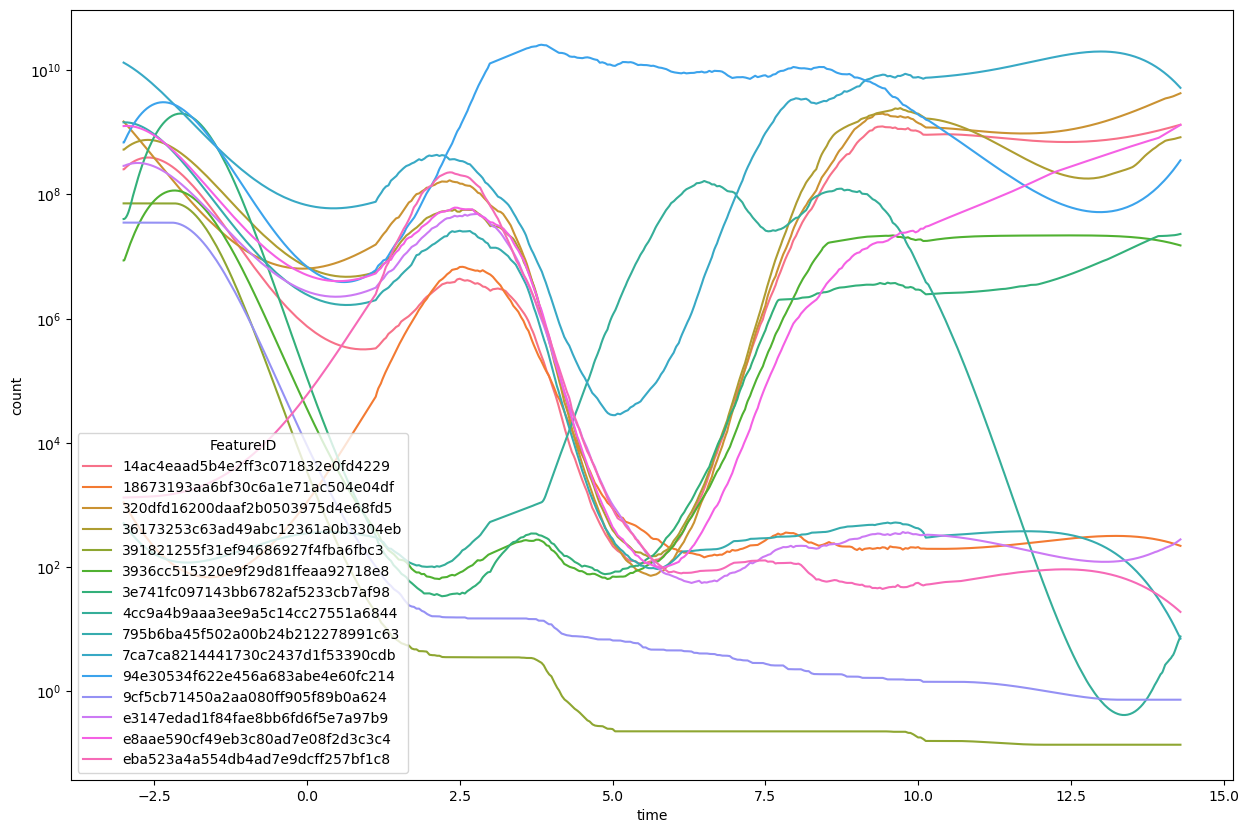

In [105]:


fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=FBA_biomass_df_plot, x='time', y='count', hue = 'FeatureID')
plt.yscale('log')
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_abundances_over_time_test_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()

In [106]:
FBA_biomass_df_plot

FBA_biomass_df_plot_unstack = FBA_biomass_df_plot.pivot(index='FeatureID', columns ='time')['count']
FBA_biomass_df_plot_unstack = pd.DataFrame(FBA_biomass_df_plot_unstack.sum(axis=0)).reset_index()
FBA_biomass_df_plot_unstack.columns = ['time', 'abun']
FBA_biomass_df_plot_unstack['time'] = pd.to_numeric(FBA_biomass_df_plot_unstack['time'])
FBA_biomass_df_plot_unstack['time'] = pd.to_numeric(FBA_biomass_df_plot_unstack['time'])

In [107]:
### Need to plot metabolite trajectories too

met_pool_over_time_df = pd.DataFrame(met_pool_over_time)
met_pool_over_time_df = met_pool_over_time_df.fillna(0)
met_pool_over_time_df_melt= met_pool_over_time_df.melt(ignore_index=False)
met_pool_over_time_df_melt = met_pool_over_time_df_melt.reset_index()
met_pool_over_time_df_melt.columns = ['Time','Metabolite', 'Concentration']
met_pool_over_time_df_melt

Time     Metabolite  Concentration
0          0  EX_cpd35610_b       0.263000
1          1  EX_cpd35610_b       0.262315
2          2  EX_cpd35610_b       0.261632
3          3  EX_cpd35610_b       0.260951
4          4  EX_cpd35610_b       0.260271
...      ...            ...            ...
491503  3316  EX_cpd01914_b       0.000000
491504  3317  EX_cpd01914_b       0.000000
491505  3318  EX_cpd01914_b       0.000000
491506  3319  EX_cpd01914_b       0.000000
491507  3320  EX_cpd01914_b       0.000000

[491508 rows x 3 columns]

In [108]:
met_pool_over_time_df

EX_cpd35610_b  EX_cpd01242_b  EX_cpd01293_b  EX_cpd00035_b  \
0          0.263000       0.285000       0.305000      11.053000   
1          0.262315       0.290014       0.307617      11.033935   
2          0.261632       0.295015       0.310228      11.012169   
3          0.260951       0.300004       0.312831      10.990453   
4          0.260271       0.304979       0.315428      10.968789   
...             ...            ...            ...            ...   
3316       0.000046       2.210120       1.309823       0.113356   
3317       0.000046       2.210121       1.309824       0.113471   
3318       0.000046       2.210122       1.309824       0.113548   
3319       0.000046       2.210123       1.309825       0.113593   
3320       0.000046       2.210124       1.309825       0.113609   

      EX_cpd01055_b  EX_cpd00224_b  EX_cpd00132_b  EX_cpd00041_b  \
0          0.069000      15.784000       0.000000       0.243000   
1          0.069576      15.344484       0.000834       0.243633   
2          0.070150      14.917218       0.001666       0.238850   
3          0.070722      14.497316       0.002495       0.232858   
4          0.071293      14.084830       0.003320       0.226857   
...             ...            ...            ...            ...   
3316       0.289961       0.000918       0.320197       0.003058   
3317       0.289961       0.000912       0.320198       0.003043   
3318       0.289961       0.000906       0.320199       0.003028   
3319       0.289961       0.000901       0.320199       0.003013   
3320       0.289962       0.000896       0.320200       0.002998   

      EX_cpd00158_b  EX_cpd00526_b  ...  EX_cpd00073_b  EX_cpd00264_b  \
0          0.520000       0.895000  ...            0.0            0.0   
1          0.518646       0.892669  ...            0.0            0.0   
2          0.517091       0.890345  ...            0.0            0.0   
3          0.515541       0.888026  ...            0.0            0.0   
4          0.513994       0.885713  ...            0.0            0.0   
...             ...            ...  ...            ...            ...   
3316       0.000000       0.000157  ...            0.0            0.0   
3317       0.000000       0.000157  ...            0.0            0.0   
3318       0.000000       0.000156  ...            0.0            0.0   
3319       0.000000       0.000156  ...            0.0            0.0   
3320       0.000000       0.000156  ...            0.0            0.0   

      EX_cpd11584_b  EX_cpd00007_b  EX_cpd15603_b  EX_cpd00654_b  \
0               0.0            0.0            0.0   0.000000e+00   
1               0.0            0.0            0.0   0.000000e+00   
2               0.0            0.0            0.0   0.000000e+00   
3               0.0            0.0            0.0   0.000000e+00   
4               0.0            0.0            0.0   0.000000e+00   
...             ...            ...            ...            ...   
3316            0.0            0.0            0.0   4.054421e-07   
3317            0.0            0.0            0.0   4.034652e-07   
3318            0.0            0.0            0.0   4.014950e-07   
3319            0.0            0.0            0.0   3.995315e-07   
3320            0.0            0.0            0.0   3.975744e-07   

      EX_cpd15606_b  EX_cpd11591_b  EX_cpd00731_b  EX_cpd01914_b  
0               0.0            0.0   0.000000e+00            0.0  
1               0.0            0.0   0.000000e+00            0.0  
2               0.0            0.0   0.000000e+00            0.0  
3               0.0            0.0   0.000000e+00            0.0  
4               0.0            0.0   0.000000e+00            0.0  
...             ...            ...            ...            ...  
3316            0.0            0.0   3.540076e-21            0.0  
3317            0.0            0.0   3.069345e-21            0.0  
3318            0.0            0.0   2.659877e-21            0.0  
3319    

In [109]:
met_pool_over_time_df_melt[met_pool_over_time_df_melt['Concentration'] < 0]

Empty DataFrame
Columns: [Time, Metabolite, Concentration]
Index: []

In [110]:
met_pool_over_time_df_melt[met_pool_over_time_df_melt['Metabolite'] == 'EX_adn(e)']

Empty DataFrame
Columns: [Time, Metabolite, Concentration]
Index: []

In [111]:
total_abun_MDSINE = pd.DataFrame(bi_hourly_resolution_latent_traj.sum(axis=0)).reset_index()
total_abun_MDSINE.columns = ['time', 'abun']
total_abun_MDSINE['time'] = pd.to_numeric(total_abun_MDSINE['time'])
total_abun_MDSINE.max()

time    1.400000e+01
abun    9.220114e+10
dtype: float64

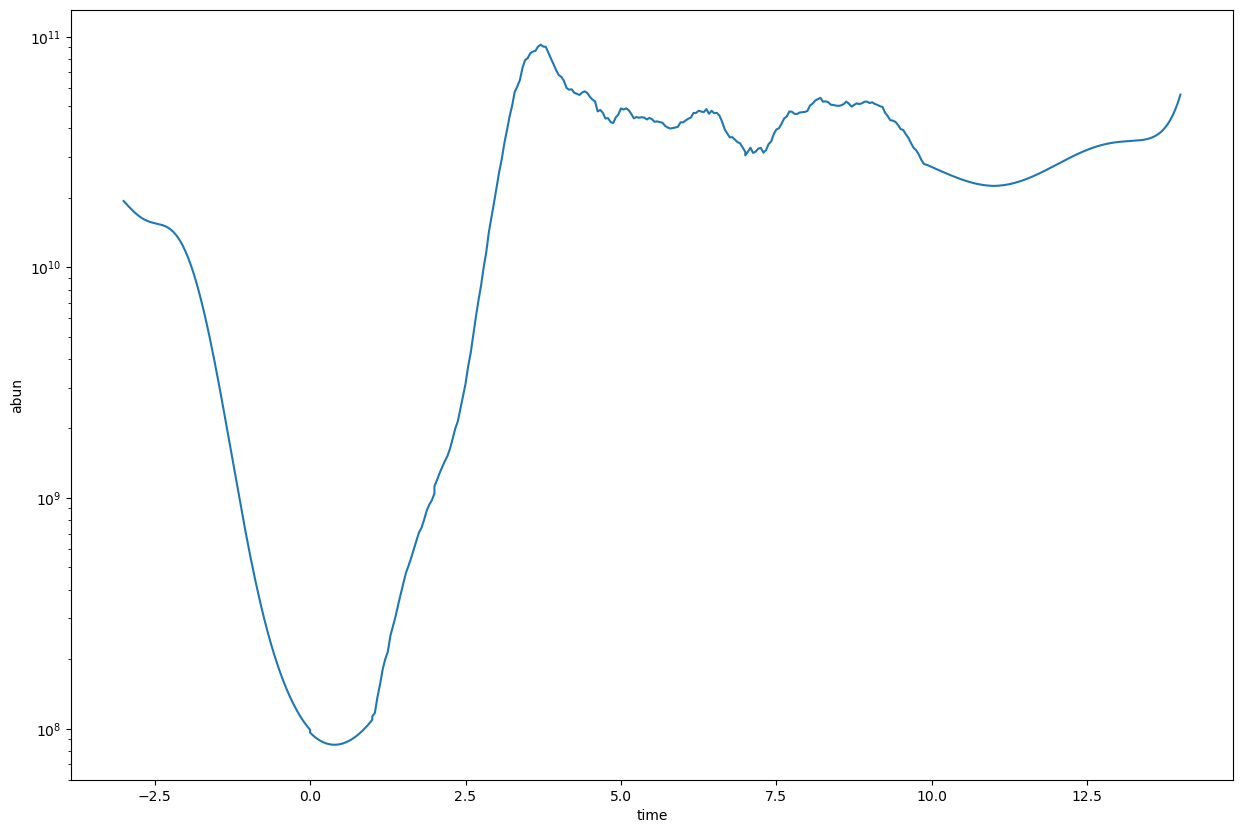

In [112]:
fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=total_abun_MDSINE, x='time', y='abun')
plt.yscale('log')

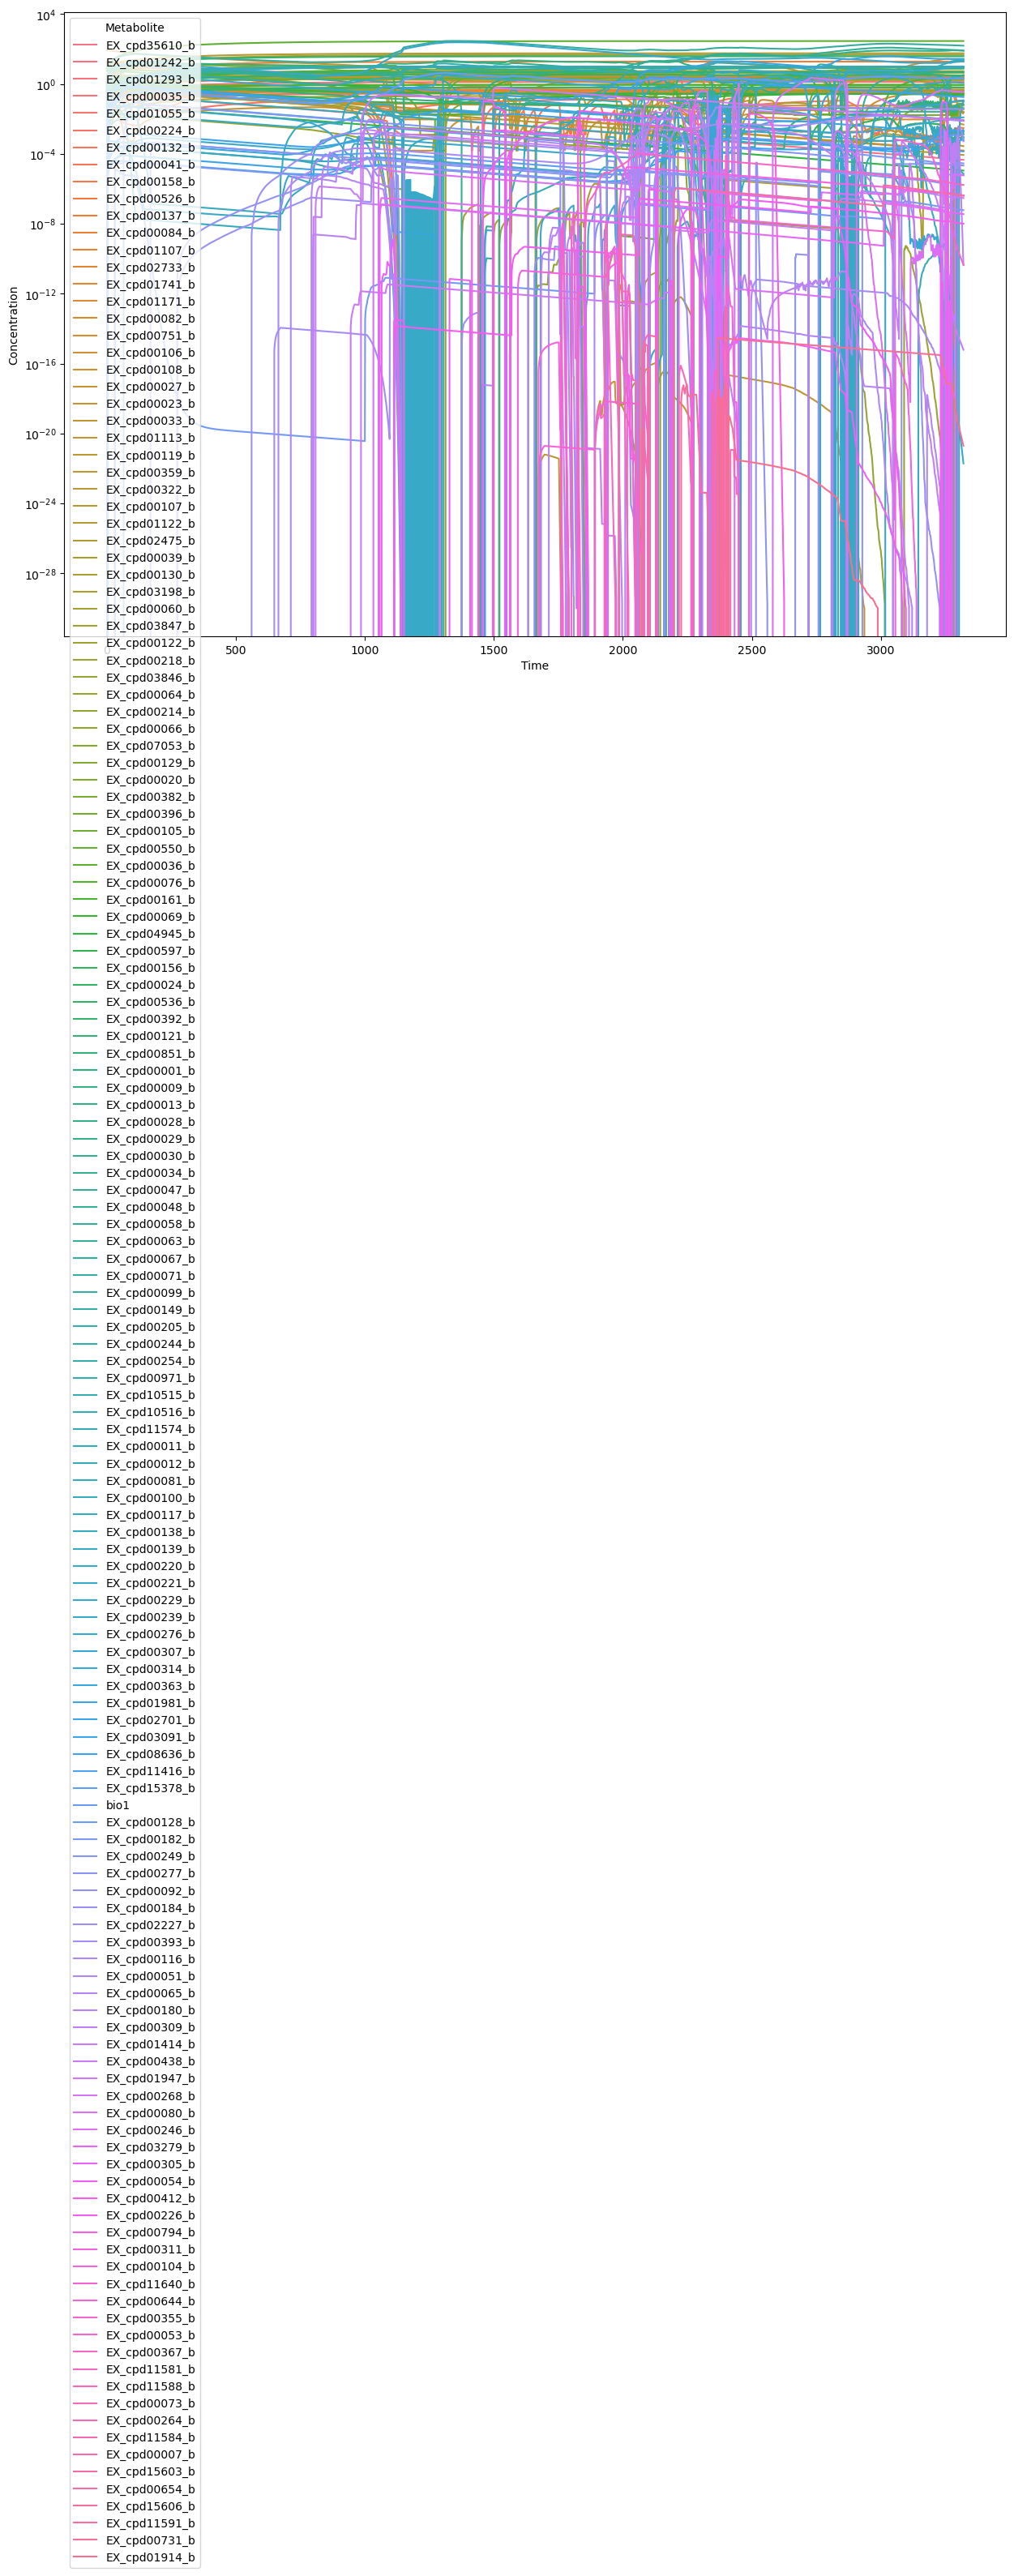

In [113]:
output_folder = 'filtering_hourly_resolution'

#plot_dir_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/MDSINE_vs_Exp_plots_' + output_folder + '/test_' + str(test_num)

plot_dir = Path(plot_dir_path)
os.makedirs(plot_dir, exist_ok=True)

fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=met_pool_over_time_df_melt, x='Time', y='Concentration', hue = 'Metabolite')
plt.yscale('log')
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_metabolites_over_time_test_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()


                                  HF1152  HF1116  HF1181  HF1205  HF1253  \
FeatureID                                                                  
14ac4eaad5b4e2ff3c071832e0fd4229      27     205      26      22       0   
18673193aa6bf30c6a1e71ac504e04df       0       0       0      10       0   
320dfd16200daaf2b0503975d4e68fd5    1435     232     531     375       0   
36173253c63ad49abc12361a0b3304eb     258     813     261     205       0   
391821255f31ef94686927f4fba6fbc3       0     862       0       0       0   
3936cc515320e9f29d81ffeaa92718e8       0      48       0       0       0   
3e741fc097143bb6782af5233cb7af98       0    1098       0       0       0   
4cc9a4b9aaa3ee9a5c14cc27551a6844       0       0       0       0       0   
795b6ba45f502a00b24b212278991c63     152     405     110     108       0   
7ca7ca8214441730c2437d1f53390cdb    1686    5788    1939    1413       0   
94e30534f622e456a683abe4e60fc214     180    2975     285     184   63472   
9cf5cb71450a

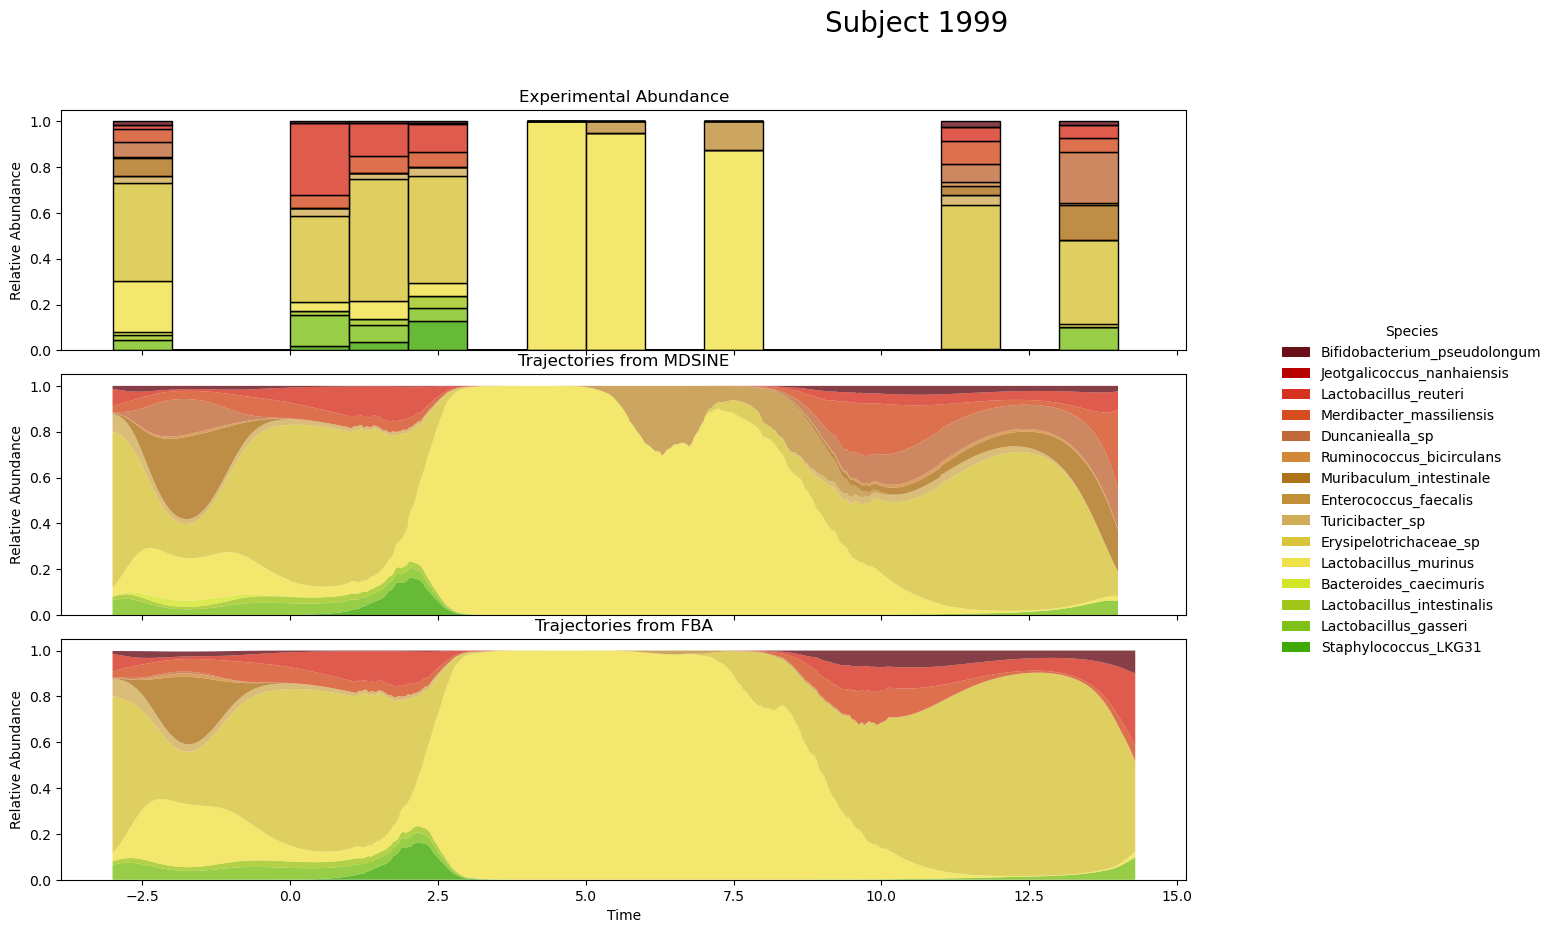

In [114]:
### Stacked plots 

## Directory to save plots to 


output_folder = 'filtering_hourly_resolution'

#plot_dir_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/MDSINE_vs_Exp_plots_' + output_folder + '/test_' + str(test_num)

plot_dir = Path(plot_dir_path)
os.makedirs(plot_dir, exist_ok=True)

samps_for_sub ={}


temp = metadata[metadata['subject'] == subject_to_plot]
testing = counts.filter(temp.index.tolist(), axis=1)
print(testing)
testing = testing.loc[~(testing==0).all(axis=1)]
qpcr_measurements = qpcr.reindex(testing.columns)
qpcr_measurements = qpcr_measurements['measurement1'].to_list()
testing_ra = testing.reindex(index_to_filter_by)
testing_ra = testing/testing.sum(axis=0)
testing_abs_abun = testing_ra*qpcr_measurements
time_dict = dict(zip(temp.index, temp['time'].tolist()))
testing_melt_ra = testing_ra.melt(ignore_index=False)
testing_melt_ra.columns = ['sample', 'count']
testing_melt_ra['time'] = testing_melt_ra['sample'].map(time_dict)
#print(testing_melt_ra.head())
testing_melt_abs_abun = testing_abs_abun.melt(ignore_index=False)
testing_melt_abs_abun.columns = ['sample', 'count']
testing_melt_abs_abun['time'] = testing_melt_abs_abun['sample'].map(time_dict)

# load in MDSINE output for each subject 
output_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/' + output_folder + '/Subject_' + str(subject_to_plot) + '/mean_smoothed.tsv'
MDSINE_output = pd.read_csv(output_path, delimiter='\t', index_col=0)


MDSINE_output = MDSINE_output.reindex(index_to_filter_by)

MDSINE_output = MDSINE_output/MDSINE_output.sum(axis=0)
MDSINE_output = MDSINE_output.melt(ignore_index=False)
MDSINE_output = MDSINE_output.reset_index()
MDSINE_output.columns = ['FeatureID','time', 'count']


###################
### Second plot ###
###################

fig, (ax_top, ax_middle, ax_bottom) = plt.subplots(
3, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]}
)

# Ensure time is numeric
MDSINE_output['time'] = pd.to_numeric(MDSINE_output['time'])
testing_melt_ra['time'] = pd.to_numeric(testing_melt_ra['time'])
FBA_biomass_df['time'] = pd.to_numeric(FBA_biomass_df['time'])

# Define stacking order
feature_order = MDSINE_output['FeatureID'].value_counts().index.tolist()
reversed_order = feature_order[::-1]  # For stackplot

# Assign consistent colors


twentysiz = [
    "#690f19", "#b80000", "#d63220", "#d64e20", "#c1693a",  # reds/oranges
    "#d38838", "#AE7219", "#C09038", "#d1ad57", "#d8c33a", "#f1e149",  # orange/yellows
    "#d2e626", "#a0c618", "#7dc119", "#40a903", "#0c9515",  # yellow/green
    "#1da05a", "#1da18d", "#1d91a1", "#1d6ea1", "#1d31a1",  # green/blue
    "#1a1a87", "#5b5bc9", "#8d8df1", "#8670cc", "#9870cc",  # blue/purple
    "#000000"  # black
]
#sns.set_style("dark")  # or "whitegrid", "dark", etc.
#sns.set_context("notebook")  # or "paper", "talk", "poster"
sns.set_palette(twentysiz)

#palette = sns.color_palette("Spectral", n_colors=len(feature_order))  # or use 'husl', 'Set2', etc.
color_map = dict(zip(feature_order, twentysiz))

# Pivot for stackplot in reversed stacking order
continuous_pivot_MDSINE = (
    MDSINE_output
    .pivot(index='time', columns='FeatureID', values='count')
    .fillna(0)
)[reversed_order]

# Pivot for stackplot in reversed stacking order
continuous_pivot_FBA = (
    FBA_biomass_df
    .pivot(index='time', columns='FeatureID', values='count')
    .fillna(0)
)[reversed_order]



# Set categorical order for histogram
testing_melt_ra['FeatureID'] = pd.Categorical(testing_melt_ra.reset_index()['FeatureID'], categories=feature_order, ordered=True)

# Top: histogram
sns.histplot(
    data=testing_melt_ra,
    x='time',
    weights='count',
    hue='FeatureID',
    multiple='stack',
    ax=ax_top,
    alpha=0.8,
    binwidth=1,
    palette=color_map
)
ax_top.legend_.remove()
ax_top.set_ylabel('Relative Abundance')
ax_top.set_title('Experimental Abundance')
#ax_top.legend(title='FeatureID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Middle: stackplot using reversed order and matching colors
ax_middle.stackplot(
    continuous_pivot_MDSINE.index,
    *[continuous_pivot_MDSINE[col] for col in continuous_pivot_MDSINE.columns],
    alpha=0.8,
    colors=[color_map[feat] for feat in reversed_order],
    labels=reversed_order
)
ax_middle.set_ylabel('Relative Abundance')
#ax_middle.set_xlabel('Time')
ax_middle.set_title('Trajectories from MDSINE')

# Bottom: stackplot using FBA output 

# Bottom: stackplot using reversed order and matching colors
ax_bottom.stackplot(
    continuous_pivot_FBA.index,
    *[continuous_pivot_FBA[col] for col in continuous_pivot_FBA.columns],
    alpha=0.8,
    colors=[color_map[feat] for feat in reversed_order],
    labels=reversed_order
)
ax_bottom.set_ylabel('Relative Abundance')
ax_bottom.set_xlabel('Time')
ax_bottom.set_title('Trajectories from FBA')



# Tidy layout
ax_top.tick_params(labelbottom=False)
plt.subplots_adjust(hspace=0.1, right=0.75)


# Create custom legend handles using your color map
legend_elements = [
    Patch(facecolor=color_map[feat], label=ASV_string_to_species_names_dict[feat])
    for feat in feature_order
]

# Add custom legend to the *figure* (not either axis), outside plot
fig.legend(
    handles=legend_elements,
    title='Species',
    loc='center left',
    bbox_to_anchor=(.8, 0.5),  # Push legend just outside right edge
    borderaxespad=0,
    frameon=False,
    ncol=1
)
# Adjust spacing to make room for the legend
plt.subplots_adjust(hspace=0.1, right=1)  # Shrink plot width
overall_title = 'Subject ' + str(subject_to_plot)
plt.suptitle(overall_title, x=0.6, fontsize = 20)
plt.subplots_adjust(right=0.75)
second_plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_stacked_hist_line_plots_FBA_' + str(test_num) + '.pdf'
plt.savefig(second_plot_file_name, bbox_inches="tight")
plt.show()




In [115]:
testing_melt_abs_abun_unstack = testing_melt_abs_abun.reset_index().pivot(index='FeatureID', columns ='time')['count']
testing_melt_abs_abun_unstack = pd.DataFrame(testing_melt_abs_abun_unstack.sum(axis=0)).reset_index()
testing_melt_abs_abun_unstack.columns = ['time', 'abun']
testing_melt_abs_abun_unstack['time'] = pd.to_numeric(testing_melt_abs_abun_unstack['time'])
testing_melt_abs_abun_unstack

time          abun
0  -3.0  8.858108e+09
1   0.0  7.349007e+05
2   1.0  4.310441e+05
3   2.0  1.438017e+09
4   4.0  4.944492e+10
5   5.0  2.867479e+10
6   7.0  3.360148e+10
7  11.0  1.637381e+10
8  14.0  2.486635e+10

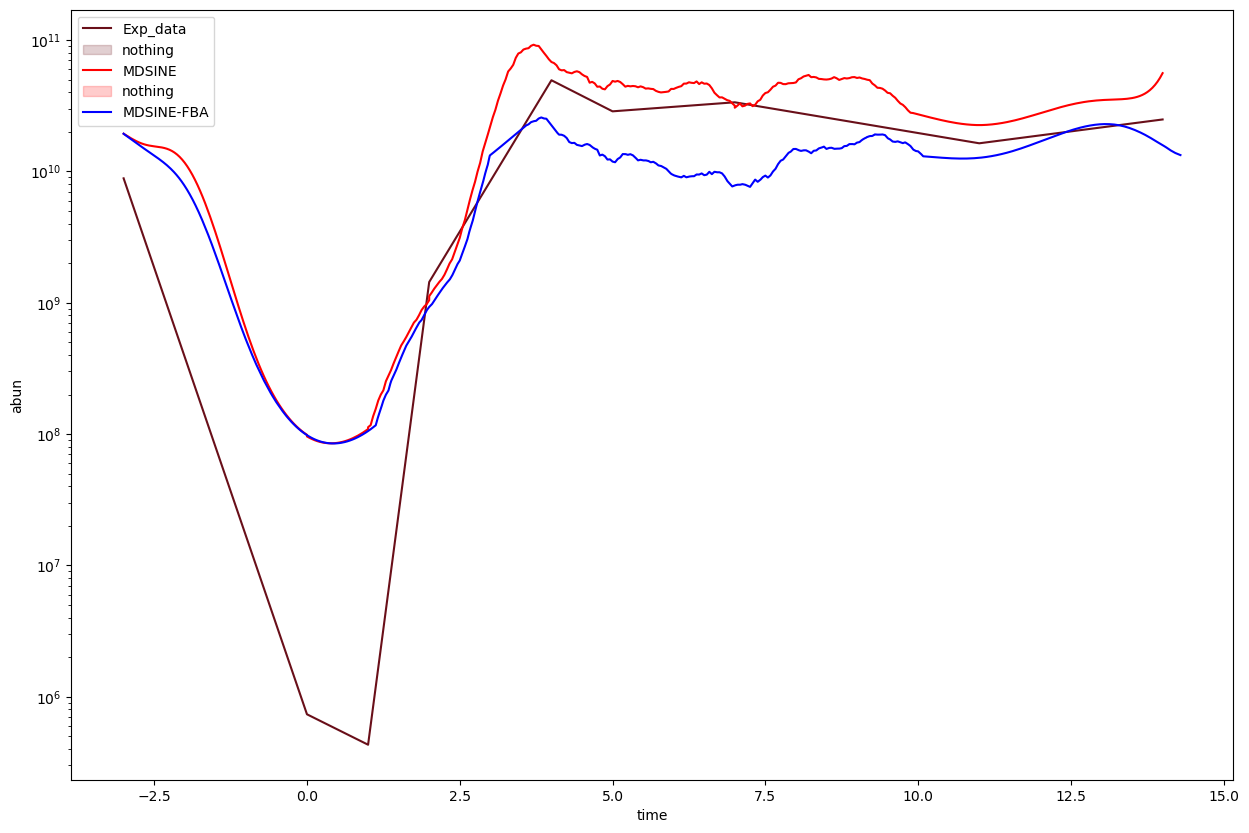

In [116]:
fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=testing_melt_abs_abun_unstack, x='time', y='abun')
sns.lineplot(data=total_abun_MDSINE, x='time', y='abun', color = 'red')
sns.lineplot(data=FBA_biomass_df_plot_unstack, x='time', y='abun', color = 'blue')
plt.legend(['Exp_data', 'nothing', 'MDSINE', 'nothing', 'MDSINE-FBA'])
plt.yscale('log')
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_comparison_abs_abun_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")

In [117]:
### Here plot the metabolomics data 
metabolomics_metadata_sub_1948 = metabolomics_metadata_raw[metabolomics_metadata_raw['Mouse'] == float(subject_to_predict)]
metabolomics_metadata_sub_1948

met_days_1948_dict = dict(zip(metabolomics_metadata_sub_1948.index.tolist(),metabolomics_metadata_sub_1948['Rec_day_adj'].tolist() ))
met_days_1948_dict

metabolomics_metadata_sub_2000 = metabolomics_metadata_raw[metabolomics_metadata_raw['Mouse'] == 2000.0]
metabolomics_metadata_sub_2000

met_days_2000_dict = dict(zip(metabolomics_metadata_sub_2000.index.tolist(),metabolomics_metadata_sub_2000['Rec_day_adj'].tolist() ))
met_days_2000_dict

{'HF2772': 14,
 'HF1115': -3,
 'HF1151': 0,
 'HF1228': 3,
 'HF1275': 5,
 'HF1299': 7,
 'HF1349': 11}

In [118]:
### Filter the metabolomics data by the correct samples

metabolomics_data_sub_1948 = metabolomics_data[metabolomics_data['SampleName'].isin(met_days_1948_dict.keys())]
metabolomics_data_sub_1948 = metabolomics_data_sub_1948.set_index('SampleName')
metabolomics_data_sub_1948_ra = metabolomics_data_sub_1948.T/metabolomics_data_sub_1948.T.sum(axis=0)
metabolomics_data_sub_1948_ra.columns = np.sort(list(met_days_1948_dict.values()))

#change_met_ids = bigg_to_agora_exchange_ids(metabolomics_data_sub_1948_ra.index.tolist())
change_met_ids = []
for i in metabolomics_data_sub_1948_ra.index.tolist():
    change_met_ids.append('EX_' + bigg_to_modelseed[i] + '_b')
metabolomics_data_sub_1948_ra.index = change_met_ids
#metabolomics_data_sub_1948_ra.head()

metabolomics_data_sub_2000 = metabolomics_data[metabolomics_data['SampleName'].isin(met_days_2000_dict.keys())]
metabolomics_data_sub_2000 = metabolomics_data_sub_2000.set_index('SampleName')
metabolomics_data_sub_2000_ra = metabolomics_data_sub_2000.T/metabolomics_data_sub_2000.T.sum(axis=0)
### columns were placed incorrectly it seems so need to match 
change_met_ids = []
for i in metabolomics_data_sub_2000_ra.index.tolist():
    change_met_ids.append('EX_' + bigg_to_modelseed[i] + '_b')
metabolomics_data_sub_2000_ra.index = change_met_ids
metabolomics_data_sub_2000_ra.columns = np.sort(list(met_days_2000_dict.values()))

change_met_ids = metabolomics_data_sub_2000_ra.index.tolist()


bigg_to_modelseed
#metabolomics_data_sub_2000_ra.index = change_met_ids

{'h2o': 'cpd00001',
 'oh1': 'cpd00001',
 'atp': 'cpd00002',
 'nad': 'cpd00003',
 'nadh': 'cpd00004',
 'nadph': 'cpd00005',
 'nadp': 'cpd00006',
 'o2': 'cpd00007',
 'adp': 'cpd00008',
 'pi': 'cpd00009',
 'coa': 'cpd00010',
 'co2': 'cpd00011',
 'ppi': 'cpd00012',
 'nh3': 'cpd00013',
 'nh4': 'cpd00013',
 'udp': 'cpd00014',
 'fad': 'cpd00015',
 'pydx5p': 'cpd00016',
 'amet': 'cpd00017',
 'amp': 'cpd00018',
 'ahcys': 'cpd00019',
 'pyr': 'cpd00020',
 'accoa': 'cpd00022',
 'glu__L': 'cpd00023',
 'akg': 'cpd00024',
 'h2o2': 'cpd00025',
 'udpg': 'cpd00026',
 'glc__D': 'cpd00027',
 'pheme': 'cpd00028',
 'ac': 'cpd00029',
 'mn2': 'cpd00030',
 'gdp': 'cpd00031',
 'oaa': 'cpd00032',
 'gly': 'cpd00033',
 'zn2': 'cpd00034',
 'ala__L': 'cpd00035',
 'succ': 'cpd00036',
 'uacgam': 'cpd00037',
 'gtp': 'cpd00038',
 'lys__L': 'cpd00039',
 'glx': 'cpd00040',
 'asp__L': 'cpd00041',
 'gthrd': 'cpd00042',
 'udpgal': 'cpd00043',
 'paps': 'cpd00044',
 'pap': 'cpd00045',
 'cmp': 'cpd00046',
 'for': 'cpd00047',
 '

In [119]:
metabolomics_data_sub_2000_ra

-3         0         3         5         7         11  \
EX_cpd35610_b  0.001108  0.000109  0.000000  0.000000  0.000000  0.001992   
EX_cpd01242_b  0.001200  0.000255  0.004831  0.001997  0.002819  0.000923   
EX_cpd01293_b  0.001285  0.004200  0.016028  0.029803  0.028420  0.001434   
EX_cpd00035_b  0.046558  0.006271  0.034269  0.043679  0.048582  0.033155   
EX_cpd01055_b  0.000291  0.000962  0.004169  0.003182  0.002255  0.000231   
EX_cpd00224_b  0.066486  0.049681  0.008473  0.020081  0.029647  0.072922   
EX_cpd00132_b  0.000000  0.000816  0.003145  0.008821  0.011209  0.000000   
EX_cpd00041_b  0.001024  0.006376  0.048476  0.080517  0.073653  0.006959   
EX_cpd00158_b  0.002190  0.000000  0.004365  0.003465  0.003913  0.005047   
EX_cpd00526_b  0.003770  0.001046  0.000858  0.001220  0.001128  0.001324   
EX_cpd00137_b  0.000417  0.000356  0.001505  0.004225  0.000431  0.000137   
EX_cpd00084_b  0.014145  0.016802  0.055791  0.075108  0.077881  0.010492   
EX_cpd01107_b  0.000754  0.000222  0.000632  0.001043  0.001094  0.000558   
EX_cpd02733_b  0.080399  0.002272  0.000873  0.000000  0.000000  0.309843   
EX_cpd01741_b  0.000708  0.000000  0.000000  0.000000  0.000000  0.000414   
EX_cpd01171_b  0.000000  0.000000  0.000000  0.009156  0.012834  0.000000   
EX_cpd00082_b  0.003812  0.013484  0.072541  0.036043  0.004228  0.003480   
EX_cpd00751_b  0.001588  0.001887  0.001385  0.003146  0.002504  0.002029   
EX_cpd00106_b  0.002338  0.002339  0.006321  0.010429  0.012253  0.002808   
EX_cpd00108_b  0.062787  0.004573  0.073775  0.011543  0.012353  0.028773   
EX_cpd00027_b  0.360445  0.031809  0.050041  0.011578  0.011656  0.256168   
EX_cpd00023_b  0.000670  0.001807  0.010219  0.013151  0.014127  0.000899   
EX_cpd00033_b  0.002157  0.001067  0.003763  0.005197  0.006085  0.002163   
EX_cpd01113_b  0.001222  0.000372  0.001114  0.002422  0.001824  0.000772   
EX_cpd00119_b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
EX_cpd00359_b  0.003555  0.000000  0.000000  0.000000  0.000000  0.003861   
EX_cpd00322_b  0.011525  0.010129  0.036963  0.084529  0.095921  0.015723   
EX_cpd00107_b  0.031015  0.017710  0.078907  0.162872  0.176140  0.030909   
EX_cpd01122_b  0.054237  0.004937  0.023463  0.033798  0.042182  0.033844   
EX_cpd02475_b  0.002110  0.000096  0.000000  0.000000  0.000000  0.003637   
EX_cpd00039_b  0.000000  0.000782  0.002483  0.008750  0.012867  0.000000   
EX_cpd00130_b  0.001639  0.000075  0.000211  0.000301  0.000365  0.001280   
EX_cpd03198_b  0.000000  0.032072  0.000000  0.000000  0.000000  0.000000   
EX_cpd00060_b  0.001862  0.001293  0.005418  0.012727  0.010943  0.002567   
EX_cpd03847_b  0.006836  0.001192  0.004545  0.006470  0.006019  0.003580   
EX_cpd00122_b  0.004916  0.005033  0.000000  0.000000  0.000000  0.006752   
EX_cpd00218_b  0.014233  0.000360  0.004786  0.005780  0.007196  0.010676   
EX_cpd03846_b  0.003172  0.000971  0.002829  0.004119  0.004311  0.001992   
EX_cpd00064_b  0.000084  0.000310  0.000933  0.005056  0.006848  0.000231   
EX_cpd00214_b  0.006638  0.002326  0.008353  0.012285  0.010827  0.004773   
EX_cpd00066_b  0.003521  0.002318  0.008895  0.024535  0.022815  0.002627   
EX_cpd07053_b  0.001748  0.000824  0.002122  0.003677  0.003532  0.001471   
EX_cpd00129_b  0.022687  0.013312  0.106690  0.051686  0.038402  0.011455   
EX_cpd00020_b  0.004587  0.000402  0.007390  0.019126  0.016598  0.001521   
EX_cpd00382_b  0.000000  0.704494  0.000000  0.000000  0.000000  0.000000   
EX_cpd00396_b  0.003901  0.001498  0.004109  0.003960  0.005936  0.001220   
EX_cpd00105_b  0.037278  0.008129  0.008985  0.008520  0.010877  0.050757   
EX_cpd00550_b  0.003538  0.006464  0.029107  0.002687  0.002636  0.003339   
EX_cpd00036_b  0.032476  0.000130  0.000452  0.000884  0.000746  0.001982   
EX_cpd00076_b  0.002780  0.004029  0.017067  0.014442  0.009070  0.001006   
EX_cpd00161_b  0.001782  0.008372  0.030762  0.070724  0.061118  0.001945   
EX_cpd00069_b  0

In [120]:
met_pool_over_time_df_melt

Time     Metabolite  Concentration
0          0  EX_cpd35610_b       0.263000
1          1  EX_cpd35610_b       0.262315
2          2  EX_cpd35610_b       0.261632
3          3  EX_cpd35610_b       0.260951
4          4  EX_cpd35610_b       0.260271
...      ...            ...            ...
491503  3316  EX_cpd01914_b       0.000000
491504  3317  EX_cpd01914_b       0.000000
491505  3318  EX_cpd01914_b       0.000000
491506  3319  EX_cpd01914_b       0.000000
491507  3320  EX_cpd01914_b       0.000000

[491508 rows x 3 columns]

In [121]:
met_pool_over_time_df_melt_filt = met_pool_over_time_df_melt.set_index('Metabolite').loc[change_met_ids].reset_index()
met_pool_over_time_df_melt_filt.head()

Metabolite  Time  Concentration
0  EX_cpd35610_b     0       0.263000
1  EX_cpd35610_b     1       0.262315
2  EX_cpd35610_b     2       0.261632
3  EX_cpd35610_b     3       0.260951
4  EX_cpd35610_b     4       0.260271

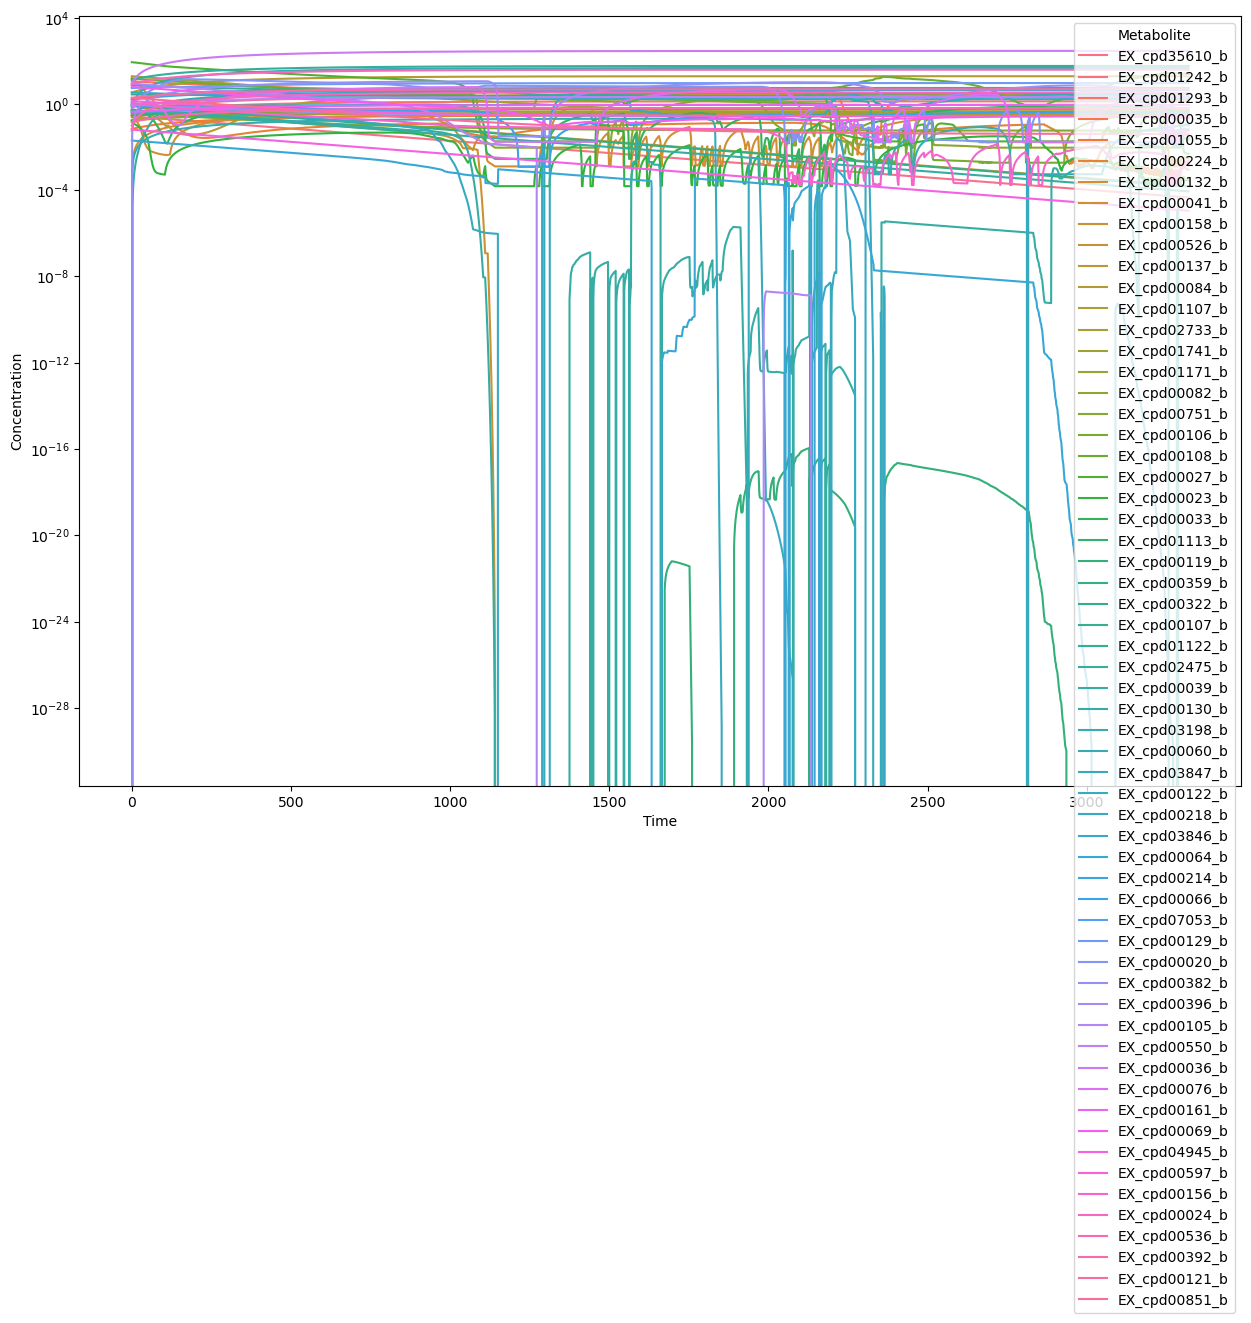

In [122]:
fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=met_pool_over_time_df_melt_filt, x='Time', y='Concentration', hue = 'Metabolite')
plt.yscale('log')
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_metabolites_over_time_test_filt' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()


In [123]:

metabolomics_data_sub_1948_ra_melt = metabolomics_data_sub_1948_ra.melt(ignore_index=False).reset_index()
metabolomics_data_sub_1948_ra_melt.columns = ['metabolites', 'time', 'concentration']
metabolomics_data_sub_1948_ra_melt.head()

metabolomics_data_sub_2000_ra_melt = metabolomics_data_sub_2000_ra.melt(ignore_index=False).reset_index()
metabolomics_data_sub_2000_ra_melt.columns = ['metabolites', 'time', 'concentration']
metabolomics_data_sub_2000_ra_melt.head()

metabolites  time  concentration
0  EX_cpd35610_b    -3       0.001108
1  EX_cpd01242_b    -3       0.001200
2  EX_cpd01293_b    -3       0.001285
3  EX_cpd00035_b    -3       0.046558
4  EX_cpd01055_b    -3       0.000291

In [124]:
cmpd_names_adjust = []
for i in cmpd_names:
    cmpd_names_adjust.append('EX_' + i + '_b')

In [125]:
### Prepare the simulation metabolomic data 

#met_pool_over_time_df_filt = met_pool_over_time_df.T.loc[agora_ex_ids_list]
met_pool_over_time_df_filt = met_pool_over_time_df.T.loc[cmpd_names_adjust]
met_pool_over_time_df_filt = met_pool_over_time_df_filt.T.reset_index()
met_pool_over_time_df_filt['index'] = (met_pool_over_time_df_filt['index']/time_scaler)-3
met_pool_over_time_df_filt = met_pool_over_time_df_filt.set_index('index').T
met_pool_over_time_df_filt_ra = met_pool_over_time_df_filt/met_pool_over_time_df_filt.sum(axis=0)
met_pool_over_time_df_filt_ra_melt = met_pool_over_time_df_filt_ra.melt(ignore_index=False).reset_index()
met_pool_over_time_df_filt_ra_melt.columns = ['metabolites', 'time', 'concentration']
met_pool_over_time_df_filt_ra_melt.head()
# use this to filter, agora_ex_ids_list

metabolites  time  concentration
0  EX_cpd35610_b  -3.0       0.001108
1  EX_cpd01242_b  -3.0       0.001200
2  EX_cpd01293_b  -3.0       0.001285
3  EX_cpd00035_b  -3.0       0.046558
4  EX_cpd01055_b  -3.0       0.000291

In [126]:
met_pool_over_time_df_filt

index          -3.000000   -2.994792   -2.989583   -2.984375   -2.979167   \
EX_cpd35610_b       0.263    0.262315    0.261632    0.260951    0.260271   
EX_cpd01242_b       0.285    0.290014    0.295015    0.300004    0.304979   
EX_cpd01293_b       0.305    0.307617    0.310228    0.312831    0.315428   
EX_cpd00035_b      11.053   11.033935   11.012169   10.990453   10.968789   
EX_cpd01055_b       0.069    0.069576    0.070150    0.070722    0.071293   
EX_cpd00224_b      15.784   15.344484   14.917218   14.497316   14.084830   
EX_cpd00132_b       0.000    0.000834    0.001666    0.002495    0.003320   
EX_cpd00041_b       0.243    0.243633    0.238850    0.232858    0.226857   
EX_cpd00158_b       0.520    0.518646    0.517091    0.515541    0.513994   
EX_cpd00526_b       0.895    0.892669    0.890345    0.888026    0.885713   
EX_cpd00137_b       0.099    0.106102    0.112978    0.119628    0.126193   
EX_cpd00084_b       3.358    3.399322    3.438439    3.477452    3.516361   
EX_cpd01107_b       0.179    0.179732    0.180462    0.181190    0.181916   
EX_cpd02733_b      19.087   19.038023   18.989174   18.940453   18.891858   
EX_cpd01741_b       0.168    0.168552    0.169103    0.169652    0.170200   
EX_cpd01171_b       0.000    0.000000    0.000000    0.000000    0.000000   
EX_cpd00082_b       0.905    0.911986    0.901385    0.890811    0.880266   
EX_cpd00751_b       0.377    0.376168    0.375339    0.374512    0.373687   
EX_cpd00106_b       0.555    0.555430    0.552623    0.550026    0.547460   
EX_cpd00108_b      14.906   14.870900   14.835859   14.800910   14.766052   
EX_cpd00027_b      85.571   85.366420   85.086248   84.788189   84.490034   
EX_cpd00023_b       0.159    0.158739    0.153030    0.146996    0.140969   
EX_cpd00033_b       0.512    0.513496    0.511566    0.508892    0.506225   
EX_cpd01113_b       0.290    0.290781    0.291560    0.292338    0.293113   
EX_cpd00119_b       0.000    0.000000    0.000000    0.000000    0.000000   
EX_cpd00359_b       0.844    0.841802    0.839610    0.837423    0.835243   
EX_cpd00322_b       2.736    2.735005    2.733851    2.732695    2.731537   
EX_cpd00107_b       7.363    7.353140    7.342847    7.332503    7.322181   
EX_cpd01122_b      12.876   12.991740   13.107178   13.222315   13.337153   
EX_cpd02475_b       0.501    0.499695    0.498394    0.497096    0.495802   
EX_cpd00039_b       0.000    0.000000    0.000018    0.000057    0.000123   
EX_cpd00130_b       0.389    0.397935    0.404736    0.411519    0.418284   
EX_cpd03198_b       0.000    0.000547    0.001092    0.001636    0.002179   
EX_cpd00060_b       0.442    0.563033    0.682993    0.802493    0.921679   
EX_cpd03847_b       1.623    1.633023    1.643019    1.652990    1.662934   
EX_cpd00122_b       1.167    1.163961    1.151136    1.137946    1.124791   
EX_cpd00218_b       3.379    3.374515    3.370031    3.365559    3.361098   
EX_cpd03846_b       0.753    0.753368    0.753735    0.754101    0.754466   
EX_cpd00064_b       0.020    0.019948    0.019896    0.019844    0.019792   
EX_cpd00214_b       1.576    1.583233    1.590448    1.597643    1.604820   
EX_cpd00066_b       0.836    0.835030    0.833759    0.832428    0.831100   
EX_cpd07053_b       0.415    0.415586    0.416170    0.416753    0.417335   
EX_cpd00129_b       5.386    5.396056    5.406073    5.416051    5.425993   
EX_cpd00020_b       1.089    1.102701    1.132079    1.162516    1.193869   
EX_cpd00382_b       0.000    0.031042    0.062002    0.092883    0.123682   
EX_cpd00396_b       0.926    0.924292    0.922588    0.920888    0.919193   
EX_cpd00105_b       8.850    8.826953    8.799290    8.771699    8.744180   
EX_cpd00550_b       0.840    0.843307    0.846606    0.849896    0.853178   
EX_cpd00036_b       7.710    8.433437    9.158958    9.882569   10.604278   
EX_cpd00076_b       0.660    0.675737    0.691270    0.706596    0.721724   
EX_cpd00161_b       0.423    0.424279    0.425543    0.426792    0.428025

Text(0.5, 1.0, 'Experimental Abundance')

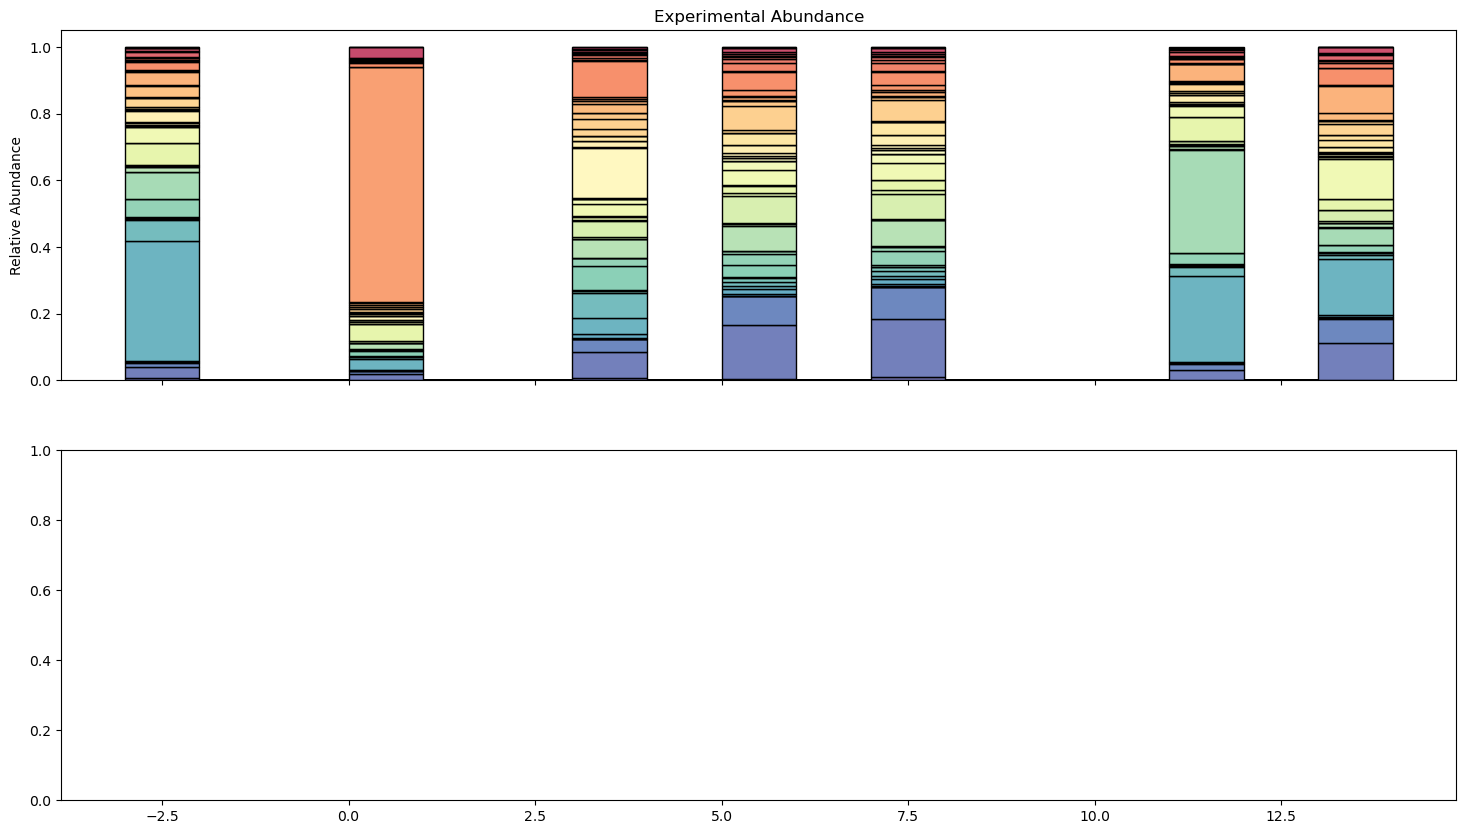

In [127]:
fig, (ax_top, ax_bottom) = plt.subplots(
2, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]}
)

# Define stacking order
feature_order = metabolomics_data_sub_2000_ra_melt['metabolites'].value_counts().index.tolist()
reversed_order = feature_order[::-1]  # For stackplot



palette = sns.color_palette("Spectral", n_colors=len(feature_order))  # or use 'husl', 'Set2', etc.
color_map = dict(zip(feature_order, palette))

# Pivot for stackplot in reversed stacking order
met_pool_over_time_df_filt_ra_pivot = (
    met_pool_over_time_df_filt_ra_melt
    .pivot(index='time', columns='metabolites', values='concentration')
    .fillna(0)
)[reversed_order]

# Set categorical order for histogram
metabolomics_data_sub_2000_ra_melt['metabolites'] = pd.Categorical(metabolomics_data_sub_2000_ra_melt.reset_index()['metabolites'], categories=feature_order, ordered=True)

# Top: histogram
sns.histplot(
    data=metabolomics_data_sub_2000_ra_melt,
    x='time',
    weights='concentration',
    hue='metabolites',
    multiple='stack',
    ax=ax_top,
    alpha=0.8,
    binwidth=1,
    palette=color_map
)
ax_top.legend_.remove()
ax_top.set_ylabel('Relative Abundance')
ax_top.set_title('Experimental Abundance')
#ax_top.legend(title='FeatureID', bbox_to_anchor=(1.05, 1), loc='upper left')


In [128]:
met_pool_over_time_df_filt_ra_pivot.sum(axis=1)

time
-3.000000     1.0
-2.994792     1.0
-2.989583     1.0
-2.984375     1.0
-2.979167     1.0
             ... 
 14.270833    1.0
 14.276042    1.0
 14.281250    1.0
 14.286458    1.0
 14.291667    1.0
Length: 3321, dtype: float64

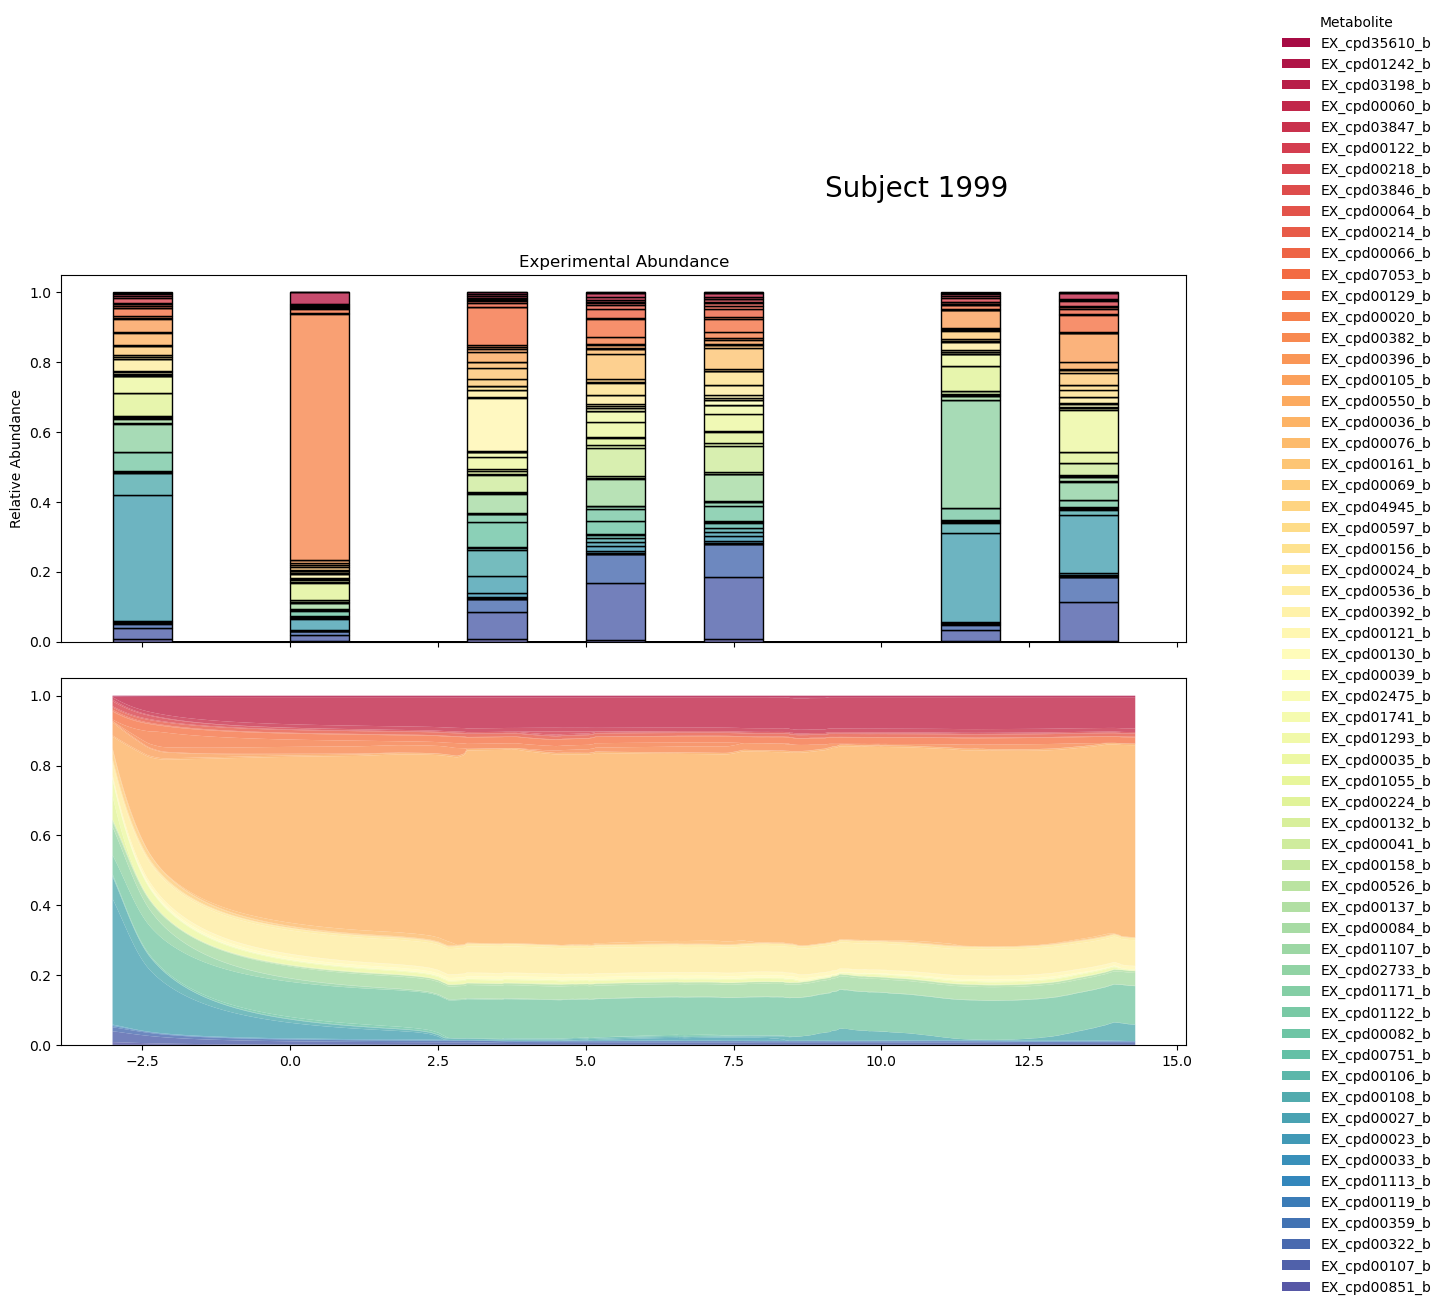

In [129]:
fig, (ax_top, ax_bottom) = plt.subplots(
2, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]}
)

# Define stacking order
feature_order = metabolomics_data_sub_1948_ra_melt['metabolites'].value_counts().index.tolist()
reversed_order = feature_order[::-1]  # For stackplot



palette = sns.color_palette("Spectral", n_colors=len(feature_order))  # or use 'husl', 'Set2', etc.
color_map = dict(zip(feature_order, palette))

# Pivot for stackplot in reversed stacking order
met_pool_over_time_df_filt_ra_pivot = (
    met_pool_over_time_df_filt_ra_melt
    .pivot(index='time', columns='metabolites', values='concentration')
    .fillna(0)
)[reversed_order]

# Set categorical order for histogram
metabolomics_data_sub_1948_ra_melt['metabolites'] = pd.Categorical(metabolomics_data_sub_1948_ra_melt.reset_index()['metabolites'], categories=feature_order, ordered=True)

# Top: histogram
sns.histplot(
    data=metabolomics_data_sub_1948_ra_melt,
    x='time',
    weights='concentration',
    hue='metabolites',
    multiple='stack',
    ax=ax_top,
    alpha=0.8,
    binwidth=1,
    palette=color_map
)
ax_top.legend_.remove()
ax_top.set_ylabel('Relative Abundance')
ax_top.set_title('Experimental Abundance')
#ax_top.legend(title='FeatureID', bbox_to_anchor=(1.05, 1), loc='upper left')

ax_bottom.stackplot(
    met_pool_over_time_df_filt_ra_pivot.index,
    *[met_pool_over_time_df_filt_ra_pivot[col] for col in met_pool_over_time_df_filt_ra_pivot.columns],
    alpha=0.8,
    colors=[color_map[feat] for feat in reversed_order],
    labels=reversed_order
)

# Create custom legend handles using your color map
legend_elements = [
    Patch(facecolor=color_map[feat], label=feat)
    for feat in feature_order
]

# Add custom legend to the *figure* (not either axis), outside plot
fig.legend(
    handles=legend_elements,
    title='Metabolite',
    loc='center left',
    bbox_to_anchor=(.8, 0.5),  # Push legend just outside right edge
    borderaxespad=0,
    frameon=False,
    ncol=1
)
# Adjust spacing to make room for the legend
plt.subplots_adjust(hspace=0.1, right=1)  # Shrink plot width
overall_title = 'Subject ' + str(subject_to_plot)
plt.suptitle(overall_title, x=0.6, fontsize = 20)
plt.subplots_adjust(right=0.75)
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_exp_vs_sim_over_time_test_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()

In [130]:
met_days_1948_dict.values()

dict_values([14, -3, 0, 3, 5, 7, 11])

In [131]:
met_pool_over_time_df_filt_ra

index          -3.000000   -2.994792     -2.989583     -2.984375   \
EX_cpd35610_b    0.001108    0.001103  1.098794e-03  1.094612e-03   
EX_cpd01242_b    0.001200    0.001220  1.238996e-03  1.258428e-03   
EX_cpd01293_b    0.001285    0.001294  1.302884e-03  1.312236e-03   
EX_cpd00035_b    0.046558    0.046399  4.624857e-02  4.610177e-02   
EX_cpd01055_b    0.000291    0.000293  2.946119e-04  2.966586e-04   
EX_cpd00224_b    0.066486    0.064525  6.264887e-02  6.081204e-02   
EX_cpd00132_b    0.000000    0.000004  6.997021e-06  1.046468e-05   
EX_cpd00041_b    0.001024    0.001025  1.003115e-03  9.767737e-04   
EX_cpd00158_b    0.002190    0.002181  2.171664e-03  2.162543e-03   
EX_cpd00526_b    0.003770    0.003754  3.739242e-03  3.725012e-03   
EX_cpd00137_b    0.000417    0.000446  4.744813e-04  5.018031e-04   
EX_cpd00084_b    0.014145    0.014295  1.444065e-02  1.458690e-02   
EX_cpd01107_b    0.000754    0.000756  7.578972e-04  7.600379e-04   
EX_cpd02733_b    0.080399    0.080057  7.975015e-02  7.944971e-02   
EX_cpd01741_b    0.000708    0.000709  7.101924e-04  7.116408e-04   
EX_cpd01171_b    0.000000    0.000000  0.000000e+00  0.000000e+00   
EX_cpd00082_b    0.003812    0.003835  3.785607e-03  3.736696e-03   
EX_cpd00751_b    0.001588    0.001582  1.576337e-03  1.570969e-03   
EX_cpd00106_b    0.002338    0.002336  2.320891e-03  2.307201e-03   
EX_cpd00108_b    0.062787    0.062534  6.230718e-02  6.208553e-02   
EX_cpd00027_b    0.360445    0.358975  3.573426e-01  3.556619e-01   
EX_cpd00023_b    0.000670    0.000668  6.426909e-04  6.166036e-04   
EX_cpd00033_b    0.002157    0.002159  2.148461e-03  2.134656e-03   
EX_cpd01113_b    0.001222    0.001223  1.224487e-03  1.226272e-03   
EX_cpd00119_b    0.000000    0.000000  0.000000e+00  0.000000e+00   
EX_cpd00359_b    0.003555    0.003540  3.526168e-03  3.512749e-03   
EX_cpd00322_b    0.011525    0.011501  1.148154e-02  1.146286e-02   
EX_cpd00107_b    0.031015    0.030921  3.083826e-02  3.075772e-02   
EX_cpd01122_b    0.054237    0.054632  5.504712e-02  5.546378e-02   
EX_cpd02475_b    0.002110    0.002101  2.093140e-03  2.085174e-03   
EX_cpd00039_b    0.000000    0.000000  7.734435e-08  2.379515e-07   
EX_cpd00130_b    0.001639    0.001673  1.699796e-03  1.726202e-03   
EX_cpd03198_b    0.000000    0.000002  4.587516e-06  6.864041e-06   
EX_cpd00060_b    0.001862    0.002368  2.868415e-03  3.366224e-03   
EX_cpd03847_b    0.006836    0.006867  6.900301e-03  6.933812e-03   
EX_cpd00122_b    0.004916    0.004895  4.834506e-03  4.773355e-03   
EX_cpd00218_b    0.014233    0.014190  1.415335e-02  1.411754e-02   
EX_cpd03846_b    0.003172    0.003168  3.165512e-03  3.163234e-03   
EX_cpd00064_b    0.000084    0.000084  8.355848e-05  8.324049e-05   
EX_cpd00214_b    0.006638    0.006658  6.679513e-03  6.701651e-03   
EX_cpd00066_b    0.003521    0.003511  3.501597e-03  3.491795e-03   
EX_cpd07053_b    0.001748    0.001748  1.747819e-03  1.748159e-03   
EX_cpd00129_b    0.022687    0.022691  2.270426e-02  2.271877e-02   
EX_cpd00020_b    0.004587    0.004637  4.754469e-03  4.876419e-03   
EX_cpd00382_b    0.000000    0.000131  2.603962e-04  3.896160e-04   
EX_cpd00396_b    0.003901    0.003887  3.874656e-03  3.862860e-03   
EX_cpd00105_b    0.037278    0.037118  3.695499e-02  3.679474e-02   
EX_cpd00550_b    0.003538    0.003546  3.555550e-03  3.565068e-03   
EX_cpd00036_b    0.032476    0.035464  3.846551e-02  4.145452e-02   
EX_cpd00076_b    0.002780    0.002842  2.903173e-03  2.963966e-03   
EX_cpd00161_b    0.001782    0.001784  1.787184e-03  1.790270e-03   
EX_cpd00069_b    0.025711    0.025604  2.550776e-02  2.541298e-02   
EX_cpd04945_b    0.000270    0.000268  2.673871e-04  2.663696e-04   
EX_cpd00597_b    0.005687    0.005665  5.646095e-03  5.627558e-03   
EX_cpd00156_b    0.004574    0.004556  4.537505e-03  4.519740e-03   
EX_cpd00024_b    0.000236    0.000272  3.349453e-04  3.971966e-04   
EX_cpd00536_b    0.035345    0.035614  3.589626e-02  3.617934e-02  

In [132]:
metabolomics_data_sub_1948 = metabolomics_data_sub_1948.T

metabolomics_data_sub_1948.columns = np.sort(list(met_days_1948_dict.values()))
metabolomics_data_sub_1948


-3        0      3      5       7       11      14
12_Ketolithocholic acid   0.263    0.026  0.000  0.000   0.000   0.596   0.043
drib                      0.285    0.061  0.321  0.113   0.170   0.276   0.092
5oxpro                    0.305    1.004  1.065  1.686   1.714   0.429   0.983
ala__L                   11.053    1.499  2.277  2.471   2.930   9.919  16.571
all__D                    0.069    0.230  0.277  0.180   0.136   0.069   0.024
arab__L                  15.784   11.875  0.563  1.136   1.788  21.816   4.562
asn__L                    0.000    0.195  0.209  0.499   0.676   0.000   0.121
asp__L                    0.243    1.524  3.221  4.555   4.442   2.082   4.680
cellb                     0.520    0.000  0.290  0.196   0.236   1.510   0.444
cholate                   0.895    0.250  0.057  0.069   0.068   0.396   0.084
cit                       0.099    0.085  0.100  0.239   0.026   0.041   0.040
cys__L                    3.358    4.016  3.707  4.249   4.697   3.139   1.934
dca                       0.179    0.053  0.042  0.059   0.066   0.167   0.051
dchac                    19.087    0.543  0.058  0.000   0.000  92.696   7.257
ddca                      0.168    0.000  0.000  0.000   0.000   0.124   0.034
galt                      0.000    0.000  0.000  0.518   0.774   0.000   0.000
fru                       0.905    3.223  4.820  2.039   0.255   1.041   0.592
fuc__L                    0.377    0.451  0.092  0.178   0.151   0.607   0.094
fum                       0.555    0.559  0.420  0.590   0.739   0.840   0.472
gal                      14.906    1.093  4.902  0.653   0.745   8.608   2.045
glc__D                   85.571    7.603  3.325  0.655   0.703  76.638  23.174
glu__L                    0.159    0.432  0.679  0.744   0.852   0.269   0.956
gly                       0.512    0.255  0.250  0.294   0.367   0.647   0.339
hxa                       0.290    0.089  0.074  0.137   0.110   0.231   0.103
his__L                    0.000    0.000  0.000  0.000   0.000   0.000   0.000
indole                    0.844    0.000  0.000  0.000   0.000   1.155   0.111
ile__L                    2.736    2.421  2.456  4.782   5.785   4.704  10.128
leu__L                    7.363    4.233  5.243  9.214  10.623   9.247  15.495
lnlcACP                  12.876    1.180  1.559  1.912   2.544  10.125   2.842
HC02191                   0.501    0.023  0.000  0.000   0.000   1.088   0.264
lys__L                    0.000    0.187  0.165  0.495   0.776   0.000   1.018
mal__L                    0.389    0.018  0.014  0.017   0.022   0.383   0.146
melib                     0.000    7.666  0.000  0.000   0.000   0.000   0.000
met__L                    0.442    0.309  0.360  0.720   0.660   0.768   2.493
ttdca                     1.623    0.285  0.302  0.366   0.363   1.071   0.402
acgam                     1.167    1.203  0.000  0.000   0.000   2.020   0.440
nac                       3.379    0.086  0.318  0.327   0.434   3.194   2.052
octa                      0.753    0.232  0.188  0.233   0.260   0.596   0.178
orn__L                    0.020    0.074  0.062  0.286   0.413   0.069   0.221
hdca                      1.576    0.556  0.555  0.695   0.653   1.428   0.631
phe__L                    0.836    0.554  0.591  1.388   1.376   0.786   2.222
C10164                    0.415    0.197  0.141  0.208   0.213   0.440   0.162
pro__L                    5.386    3.182  7.089  2.924   2.316   3.427   6.832
pyr                       1.089    0.096  0.491  1.082   1.001   0.455   0.289
raffin                    0.000  168.391  0.000  0.000   0.000   0.000   0.000
rmn                       0.926    0.358  0.273  0.224   0.358   0.365   0.081
rib__D                    8.850    1.943  0.597  0.482   0.656  15.185  11.648
ser__D                    0.840    1.545  1.934  0.152   0.159   0.999   2.636
succ                      7.710    0.031  0.030  0.050   0.045   0.593   0.519
sucr                      0.660    0.963  1.134  0.817   0.547   0.301   0.155

In [133]:
#change_met_ids = bigg_to_agora_exchange_ids(metabolomics_data_sub_1948.index.tolist())
metabolomics_data_sub_1948.index = change_met_ids
metabolomics_data_sub_1948.head()

-3      0      3      5      7      11      14
EX_cpd35610_b   0.263  0.026  0.000  0.000  0.000  0.596   0.043
EX_cpd01242_b   0.285  0.061  0.321  0.113  0.170  0.276   0.092
EX_cpd01293_b   0.305  1.004  1.065  1.686  1.714  0.429   0.983
EX_cpd00035_b  11.053  1.499  2.277  2.471  2.930  9.919  16.571
EX_cpd01055_b   0.069  0.230  0.277  0.180  0.136  0.069   0.024

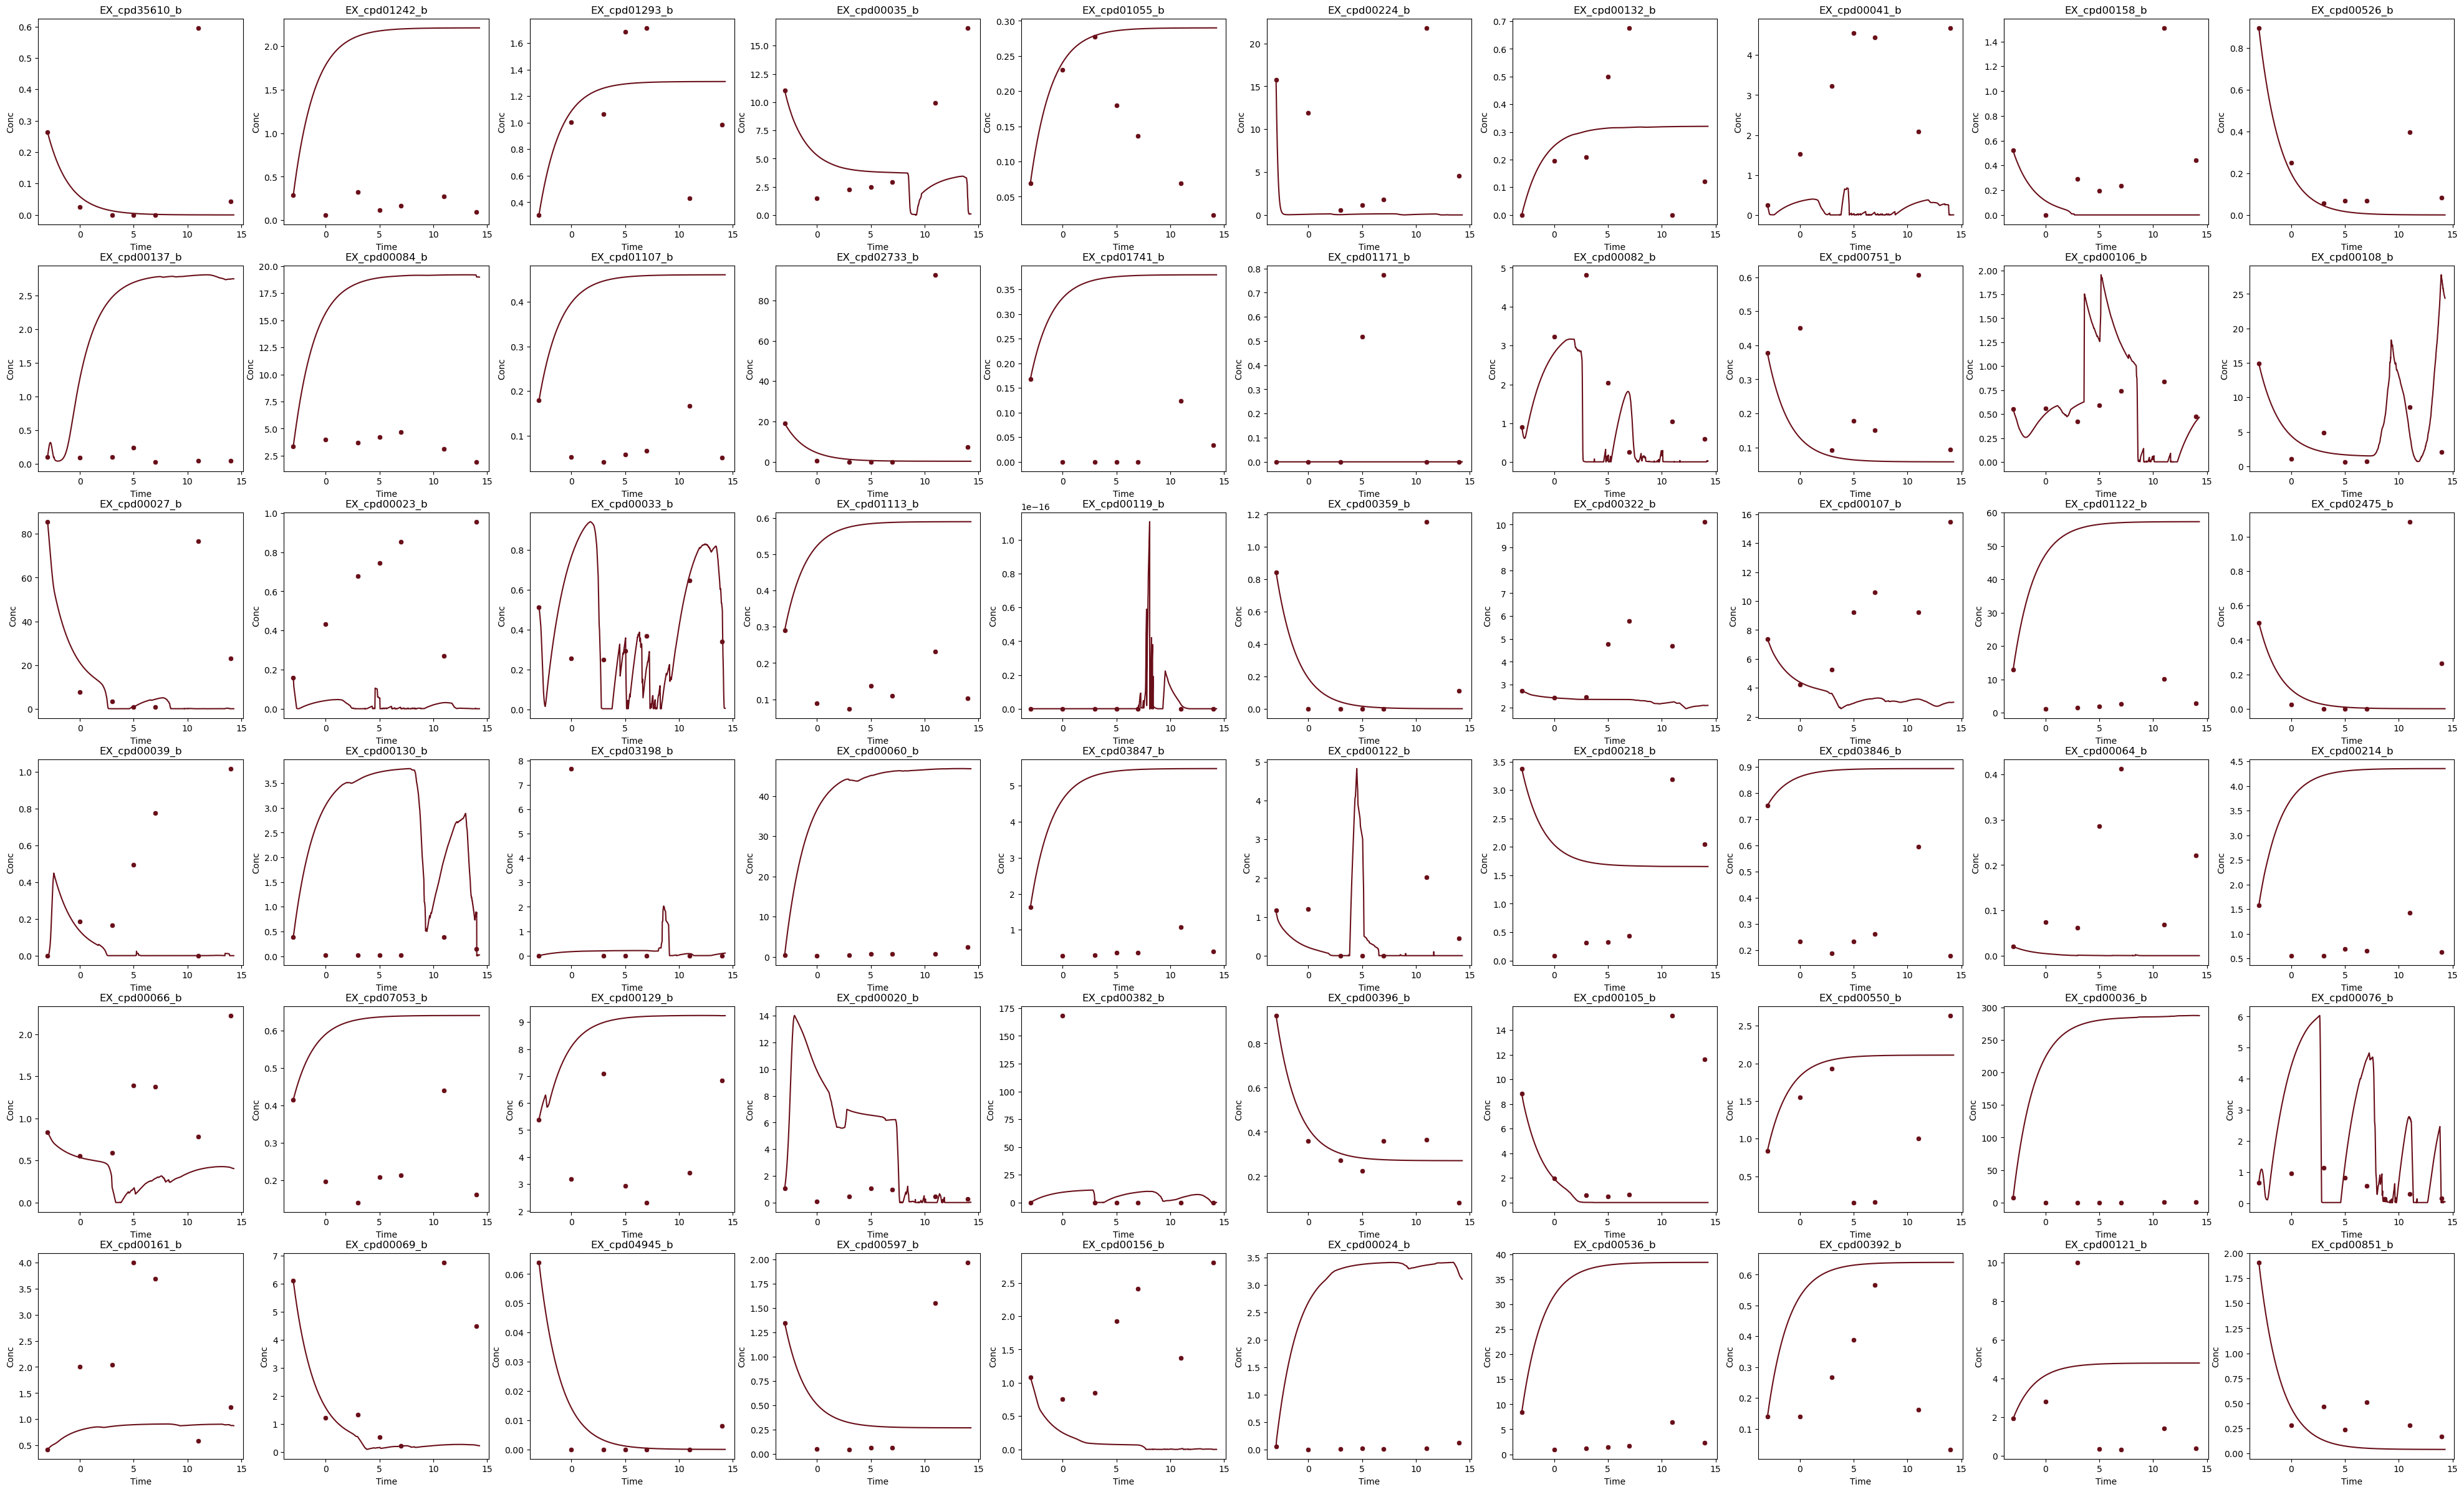

In [134]:
num_plots = 60
cols = 10  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i,met in enumerate(met_pool_over_time_df_filt.index.tolist()):
    temp_sim = met_pool_over_time_df_filt.loc[met,:]
    temp_exp = metabolomics_data_sub_1948.loc[met,:]
        # Scatter plot on the respective subplot
    sns.lineplot(ax=axes[i], 
                    x=temp_sim.index.to_list(), y=temp_sim.to_list())
    sns.scatterplot(ax=axes[i], 
                    x=temp_exp.index.to_list(), y=temp_exp.to_list())

    axes[i].set_title(f"{met}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Conc')
    #axes[i].set_yscale('log')
    #axes[i].legend_.remove()

# Hide any empty subplots if the number of plots is not a perfect square
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])


plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_exp_vs_sim_individual_scatterplots_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")

In [135]:
metabolomics_data_sub_1948_melt = metabolomics_data_sub_1948.melt(ignore_index=False).reset_index()
metabolomics_data_sub_1948_melt.columns = ['metabolites', 'time', 'concentration']
metabolomics_data_sub_1948_melt.head()

metabolites  time  concentration
0  EX_cpd35610_b    -3          0.263
1  EX_cpd01242_b    -3          0.285
2  EX_cpd01293_b    -3          0.305
3  EX_cpd00035_b    -3         11.053
4  EX_cpd01055_b    -3          0.069

In [136]:
### Prepare the simulation metabolomic data 
met_pool_over_time_df_filt_melt = met_pool_over_time_df_filt.melt(ignore_index=False).reset_index()
met_pool_over_time_df_filt_melt.columns = ['metabolites', 'time', 'concentration']
met_pool_over_time_df_filt_melt.head()
# use this to filter, agora_ex_ids_list

metabolites  time  concentration
0  EX_cpd35610_b  -3.0          0.263
1  EX_cpd01242_b  -3.0          0.285
2  EX_cpd01293_b  -3.0          0.305
3  EX_cpd00035_b  -3.0         11.053
4  EX_cpd01055_b  -3.0          0.069

In [137]:
final_rounded_time_pt = met_pool_over_time_df_filt_melt['time'].max().round()


In [138]:
met_pool_over_time_df_filt_melt.loc[
    met_pool_over_time_df_filt_melt['time'] == met_pool_over_time_df_filt_melt['time'].max(), 
    'time'
] = 14


In [139]:
met_pool_over_time_df_filt_melt

metabolites  time  concentration
0       EX_cpd35610_b  -3.0       0.263000
1       EX_cpd01242_b  -3.0       0.285000
2       EX_cpd01293_b  -3.0       0.305000
3       EX_cpd00035_b  -3.0      11.053000
4       EX_cpd01055_b  -3.0       0.069000
...               ...   ...            ...
199255  EX_cpd00024_b  14.0       3.108926
199256  EX_cpd00536_b  14.0      38.414778
199257  EX_cpd00392_b  14.0       0.639913
199258  EX_cpd00121_b  14.0       4.793678
199259  EX_cpd00851_b  14.0       0.040325

[199260 rows x 3 columns]

In [140]:
### ok now make scatterplot for each time point 

metabolomics_data_sub_1948_melt['time'] = pd.to_numeric(metabolomics_data_sub_1948_melt['time'], downcast='float') 
merged_exp_sim_met_data = metabolomics_data_sub_1948_melt.merge(met_pool_over_time_df_filt_melt, on=['time', 'metabolites'])
merged_exp_sim_met_data.columns = ['metabolites', 'time', 'exp_conc', 'sim_conc']
#met_pool_over_time_df_filt_ra

In [141]:
merged_exp_sim_met_data

metabolites  time  exp_conc   sim_conc
0    EX_cpd35610_b  -3.0     0.263   0.263000
1    EX_cpd01242_b  -3.0     0.285   0.285000
2    EX_cpd01293_b  -3.0     0.305   0.305000
3    EX_cpd00035_b  -3.0    11.053  11.053000
4    EX_cpd01055_b  -3.0     0.069   0.069000
..             ...   ...       ...        ...
475  EX_cpd00392_b  14.0     0.033   0.639913
476  EX_cpd00121_b  14.0     0.380   4.793600
477  EX_cpd00121_b  14.0     0.380   4.793678
478  EX_cpd00851_b  14.0     0.167   0.040376
479  EX_cpd00851_b  14.0     0.167   0.040325

[480 rows x 4 columns]

In [142]:
x = y = np.linspace(0,25,50)

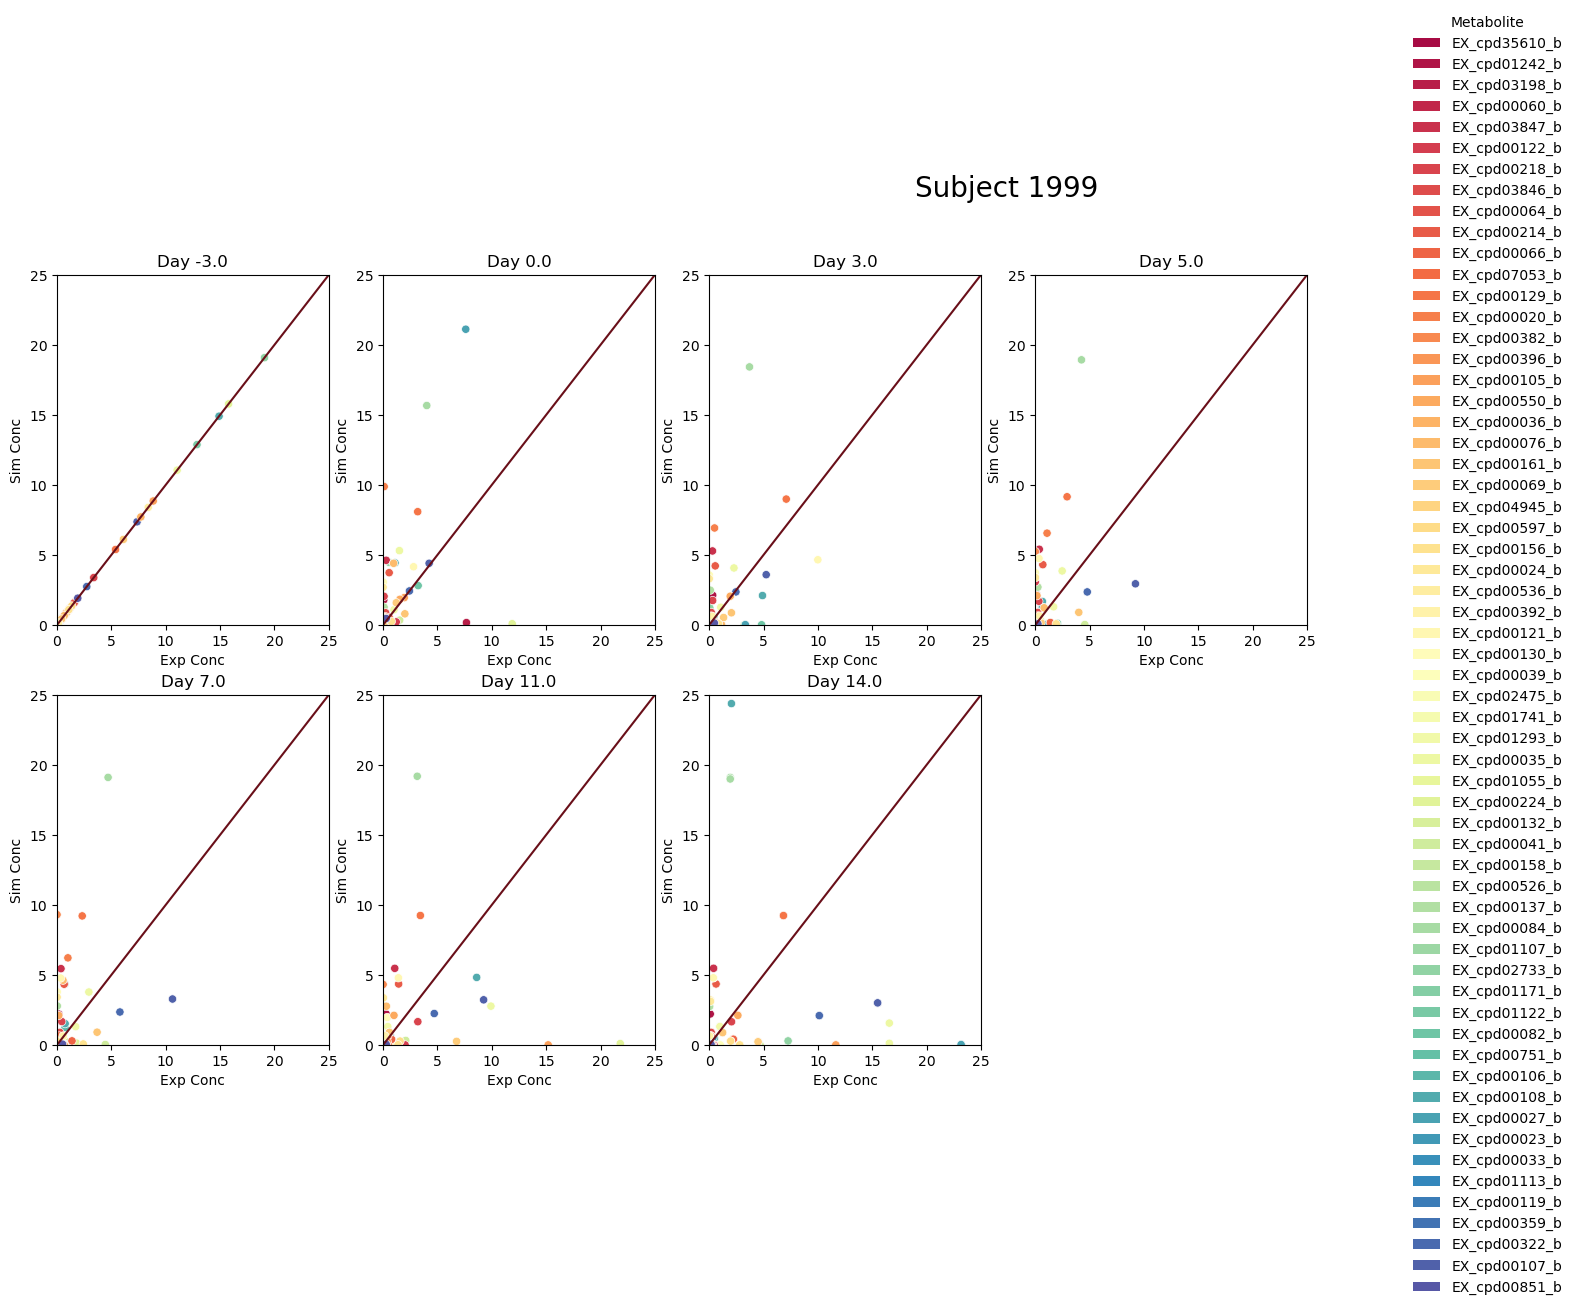

In [143]:
num_plots = 7
cols = 4  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i,time in enumerate(merged_exp_sim_met_data['time'].unique().tolist()):
    temp = merged_exp_sim_met_data[merged_exp_sim_met_data['time'] == time]
    
        # Scatter plot on the respective subplot
    sns.scatterplot(ax=axes[i], data=temp, 
                    x=temp['exp_conc'], y=temp['sim_conc'], hue='metabolites', palette=color_map)

    sns.lineplot(ax=axes[i], x=x, y = y)

    axes[i].set_xlim(0,25)
    axes[i].set_ylim(0,25)
    axes[i].set_title(f"Day {time}")
    axes[i].set_xlabel('Exp Conc')
    axes[i].set_ylabel('Sim Conc')
    axes[i].legend_.remove()

# Hide any empty subplots if the number of plots is not a perfect square
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Add custom legend to the *figure* (not either axis), outside plot
fig.legend(
    handles=legend_elements,
    title='Metabolite',
    loc='center left',
    bbox_to_anchor=(.8, 0.5),  # Push legend just outside right edge
    borderaxespad=0,
    frameon=False,
    ncol=1
)
# Adjust spacing to make room for the legend
plt.subplots_adjust(hspace=.2, right=1)  # Shrink plot width
overall_title = 'Subject ' + str(subject_to_plot)
plt.suptitle(overall_title, x=0.6, fontsize = 20)
plt.subplots_adjust(right=0.75)
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_scatter_exp_vs_sim_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()

In [144]:
### Ok now look at the utilization and production of things by the bacteria themselves 

for key in model_abun_dict:
    temp_df = pd.DataFrame(model_abun_dict[key]['flux_up'])
    print(key)

14ac4eaad5b4e2ff3c071832e0fd4229
18673193aa6bf30c6a1e71ac504e04df
320dfd16200daaf2b0503975d4e68fd5
36173253c63ad49abc12361a0b3304eb
391821255f31ef94686927f4fba6fbc3
3936cc515320e9f29d81ffeaa92718e8
3e741fc097143bb6782af5233cb7af98
4cc9a4b9aaa3ee9a5c14cc27551a6844
795b6ba45f502a00b24b212278991c63
7ca7ca8214441730c2437d1f53390cdb
94e30534f622e456a683abe4e60fc214
9cf5cb71450a2aa080ff905f89b0a624
e3147edad1f84fae8bb6fd6f5e7a97b9
e8aae590cf49eb3c80ad7e08f2d3c3c4
eba523a4a554db4ad7e9dcff257bf1c8


In [145]:
temp_1 = pd.DataFrame(model_abun_dict['14ac4eaad5b4e2ff3c071832e0fd4229']['flux_up']).fillna(0)
temp_2 = pd.DataFrame(model_abun_dict['4cc9a4b9aaa3ee9a5c14cc27551a6844']['flux_up']).fillna(0)


In [146]:
temp_1.add(temp_2, fill_value=0)

EX_cpd00001_b  EX_cpd00009_b  EX_cpd00011_b  EX_cpd00013_b  \
0          0.000000       0.000000       0.000000        0.00000   
1          0.000000       0.000357       0.000000        0.00000   
2          0.000000       0.000357       0.000000        0.00000   
3          0.000000       0.000357       0.000000        0.00000   
4          0.000000       0.000357       0.000000        0.00000   
...             ...            ...            ...            ...   
3315       0.006191       0.000509       0.006811        0.00292   
3316       0.006192       0.000509       0.006810        0.00292   
3317       0.006194       0.000509       0.006809        0.00292   
3318       0.006196       0.000509       0.006808        0.00292   
3319       0.006197       0.000509       0.006807        0.00292   

      EX_cpd00020_b  EX_cpd00027_b  EX_cpd00028_b  EX_cpd00029_b  \
0      0.000000e+00       0.000000   0.000000e+00            0.0   
1      0.000000e+00       0.000177   2.031371e-06            0.0   
2      0.000000e+00       0.000177   2.031371e-06            0.0   
3      0.000000e+00       0.000177   2.031371e-06            0.0   
4      0.000000e+00       0.000177   2.031371e-06            0.0   
...             ...            ...            ...            ...   
3315   2.423059e-11       0.003171   1.272505e-13            0.0   
3316   2.484750e-11       0.003166   1.278392e-13            0.0   
3317   2.546007e-11       0.003161   1.284836e-13            0.0   
3318   2.607079e-11       0.003156   1.291881e-13            0.0   
3319   2.668117e-11       0.003152   1.347734e-13            0.0   

      EX_cpd00030_b  EX_cpd00034_b  ...  EX_cpd00309_b  EX_cpd00322_b  \
0          0.000000       0.000000  ...            0.0   0.000000e+00   
1          0.000002       0.000002  ...            0.0   0.000000e+00   
2          0.000002       0.000002  ...            0.0   0.000000e+00   
3          0.000002       0.000002  ...            0.0   0.000000e+00   
4          0.000002       0.000002  ...            0.0   0.000000e+00   
...             ...            ...  ...            ...            ...   
3315       0.000003       0.000003  ...            0.0   5.091935e-12   
3316       0.000003       0.000003  ...            0.0   5.115492e-12   
3317       0.000003       0.000003  ...            0.0   5.141277e-12   
3318       0.000003       0.000003  ...            0.0   5.169468e-12   
3319       0.000003       0.000003  ...            0.0   5.392966e-12   

      EX_cpd00363_b  EX_cpd00382_b  EX_cpd00393_b  EX_cpd00644_b  \
0               0.0       0.000000            0.0            0.0   
1               0.0       0.000000            0.0            0.0   
2               0.0       0.000000            0.0            0.0   
3               0.0       0.000000            0.0            0.0   
4               0.0       0.000000            0.0            0.0   
...             ...            ...            ...            ...   
3315            0.0       0.003202            0.0            0.0   
3316            0.0       0.003203            0.0            0.0   
3317            0.0       0.003204            0.0            0.0   
3318            0.0       0.003206            0.0            0.0   
3319            0.0       0.003207            0.0            0.0   

      EX_cpd00731_b  EX_cpd01414_b  EX_cpd10515_b  EX_cpd10516_b  
0      0.000000e+00            0.0       0.000000       0.000000  
1      0.000000e+00            0.0       0.000004       0.000002  
2      0.000000e+00            0.0       0.000004       0.000002  
3      0.000000e+00            0.0       0.000004       0.000002  
4      0.000000e+00            0.0       0.000004       0.000002  
...             ...            ...            ...            ...  
3315   5.316391e-22            0.0       0.000009       0.000003  
3316   4.627165e-22            0.0       0.000009       0.000003  
3317   4.025233e-22            0.0       0.000009       0.000003  
3318   3

In [147]:

flux_up_df = pd.DataFrame()

for key in model_abun_dict:
    temp_up = pd.DataFrame(model_abun_dict[key]['flux_up']).fillna(0)
    flux_up_df = flux_up_df.add(temp_up, fill_value=0)

flux_up_df

EX_cpd00001_b  EX_cpd00007_b  EX_cpd00009_b  EX_cpd00011_b  \
0          0.000000            0.0       0.000000       0.000000   
1          0.000204            0.0       0.003235       0.000000   
2          0.000204            0.0       0.003848       0.000000   
3          0.000204            0.0       0.004020       0.000000   
4          0.000204            0.0       0.004184       0.000000   
...             ...            ...            ...            ...   
3315       0.021961            0.0       0.004894       0.006866   
3316       0.021971            0.0       0.004884       0.006863   
3317       0.021977            0.0       0.004875       0.006860   
3318       0.021981            0.0       0.004866       0.006858   
3319       0.022070            0.0       0.004876       0.006859   

      EX_cpd00012_b  EX_cpd00013_b  EX_cpd00020_b  EX_cpd00023_b  \
0               0.0       0.000000       0.000000       0.000000   
1               0.0       0.000127       0.000000       0.005463   
2               0.0       0.000258       0.000000       0.005804   
3               0.0       0.000390       0.000000       0.005812   
4               0.0       0.000508       0.000000       0.005813   
...             ...            ...            ...            ...   
3315            0.0       0.021898       0.018290       0.000154   
3316            0.0       0.021900       0.018311       0.000154   
3317            0.0       0.021902       0.018330       0.000154   
3318            0.0       0.015096       0.018347       0.000154   
3319            0.0       0.015115       0.018364       0.000154   

      EX_cpd00024_b  EX_cpd00027_b  ...  EX_cpd11587_b  EX_cpd11588_b  \
0          0.000000       0.000000  ...            0.0            0.0   
1          0.000000       0.076324  ...            0.0            0.0   
2          0.000000       0.094989  ...            0.0            0.0   
3          0.000000       0.095864  ...            0.0            0.0   
4          0.000000       0.096025  ...            0.0            0.0   
...             ...            ...  ...            ...            ...   
3315       0.002179       0.018364  ...            0.0            0.0   
3316       0.002179       0.018363  ...            0.0            0.0   
3317       0.002179       0.018362  ...            0.0            0.0   
3318       0.002179       0.018361  ...            0.0            0.0   
3319       0.002179       0.018359  ...            0.0            0.0   

      EX_cpd11590_b  EX_cpd11591_b  EX_cpd11592_b  EX_cpd11593_b  \
0               0.0            0.0            0.0            0.0   
1               0.0            0.0            0.0            0.0   
2               0.0            0.0            0.0            0.0   
3               0.0            0.0            0.0            0.0   
4               0.0            0.0            0.0            0.0   
...             ...            ...            ...            ...   
3315            0.0            0.0            0.0            0.0   
3316            0.0            0.0            0.0            0.0   
3317            0.0            0.0            0.0            0.0   
3318            0.0            0.0            0.0            0.0   
3319            0.0            0.0            0.0            0.0   

      EX_cpd11640_b  EX_cpd15603_b  EX_cpd15605_b  EX_cpd15606_b  
0               0.0            0.0            0.0            0.0  
1               0.0            0.0            0.0            0.0  
2               0.0            0.0            0.0            0.0  
3               0.0            0.0            0.0            0.0  
4               0.0            0.0            0.0            0.0  
...             ...            ...            ...            ...  
3315            0.0            0.0            0.0            0.0  
3316            0.0            0.0            0.0            0.0  
3317            0.0            0.0            0.0            0.0  
3318    

In [148]:
flux_sec_df = pd.DataFrame()

for key in model_abun_dict:
    temp_sec = pd.DataFrame(model_abun_dict[key]['flux_sec']).fillna(0)
    flux_sec_df = flux_sec_df.add(temp_sec, fill_value=0)

flux_sec_df.columns

Index(['EX_cpd00001_b', 'EX_cpd00007_b', 'EX_cpd00009_b', 'EX_cpd00011_b',
       'EX_cpd00012_b', 'EX_cpd00013_b', 'EX_cpd00020_b', 'EX_cpd00023_b',
       'EX_cpd00024_b', 'EX_cpd00027_b',
       ...
       'EX_cpd11416_b', 'EX_cpd11581_b', 'EX_cpd11584_b', 'EX_cpd11588_b',
       'EX_cpd11591_b', 'EX_cpd11640_b', 'EX_cpd15378_b', 'EX_cpd15603_b',
       'EX_cpd15606_b', 'bio1'],
      dtype='object', length=107)

In [149]:
### filter dataframes by metabolites of interest 

flux_up_df_filt = flux_up_df[flux_up_df.columns.intersection(change_met_ids)]
flux_up_df_filt

flux_sec_df_filt = flux_sec_df[flux_sec_df.columns.intersection(change_met_ids)]
flux_sec_df_filt

EX_cpd00020_b  EX_cpd00023_b  EX_cpd00024_b  EX_cpd00027_b  \
0          0.000000            0.0       0.000000            0.0   
1         -0.015753            0.0      -0.006237            0.0   
2         -0.016893            0.0      -0.006237            0.0   
3         -0.017890            0.0      -0.006237            0.0   
4         -0.018509            0.0      -0.006237            0.0   
...             ...            ...            ...            ...   
3315      -0.001678            0.0       0.000000            0.0   
3316      -0.001695            0.0       0.000000            0.0   
3317      -0.001713            0.0       0.000000            0.0   
3318      -0.001731            0.0       0.000000            0.0   
3319      -0.001627            0.0       0.000000            0.0   

      EX_cpd00033_b  EX_cpd00035_b  EX_cpd00036_b  EX_cpd00039_b  \
0               0.0            0.0       0.000000       0.000000   
1               0.0            0.0      -0.003978      -0.000018   
2               0.0            0.0      -0.003958      -0.000038   
3               0.0            0.0      -0.003940      -0.000066   
4               0.0            0.0      -0.003921      -0.000096   
...             ...            ...            ...            ...   
3315            0.0            0.0       0.000000       0.000000   
3316            0.0            0.0       0.000000       0.000000   
3317            0.0            0.0       0.000000       0.000000   
3318            0.0            0.0       0.000000       0.000000   
3319            0.0            0.0       0.000000       0.000000   

      EX_cpd00041_b  EX_cpd00060_b  ...  EX_cpd00108_b  EX_cpd00119_b  \
0               0.0            0.0  ...       0.000000            0.0   
1               0.0            0.0  ...       0.000000            0.0   
2               0.0            0.0  ...       0.000000            0.0   
3               0.0            0.0  ...       0.000000            0.0   
4               0.0            0.0  ...       0.000000            0.0   
...             ...            ...  ...            ...            ...   
3315            0.0            0.0  ...      -0.063751            0.0   
3316            0.0            0.0  ...      -0.063672            0.0   
3317            0.0            0.0  ...      -0.063620            0.0   
3318            0.0            0.0  ...      -0.055327            0.0   
3319            0.0            0.0  ...      -0.055314            0.0   

      EX_cpd00122_b  EX_cpd00129_b  EX_cpd00130_b  EX_cpd00137_b  \
0               0.0            0.0       0.000000            0.0   
1               0.0            0.0       0.000000            0.0   
2               0.0            0.0       0.000000            0.0   
3               0.0            0.0       0.000000            0.0   
4               0.0            0.0       0.000000            0.0   
...             ...            ...            ...            ...   
3315            0.0            0.0      -0.000012            0.0   
3316            0.0            0.0      -0.000012            0.0   
3317            0.0            0.0      -0.000012            0.0   
3318            0.0            0.0      -0.000012            0.0   
3319            0.0            0.0      -0.000012            0.0   

      EX_cpd00161_b  EX_cpd00218_b  EX_cpd00382_b  EX_cpd03198_b  
0               0.0            0.0            0.0            0.0  
1               0.0            0.0            0.0            0.0  
2               0.0            0.0            0.0            0.0  
3               0.0            0.0            0.0            0.0  
4               0.0            0.0            0.0            0.0  
...             ...            ...            ...            ...  
3315            0.0            0.0            0.0            0.0  
3316            0.0            0.0            0.0            0.0  
3317            0.0            0.0            0.0            0.0  
3318    

In [150]:
### Ok now here filter the initial metabolite conditions by the columns but then add them to the time zero and cumsum after that 


### need to multiply the uptake and secretion dataframes by -1 because opposite of how we would think of these things currently

flux_sec_df_filt = flux_sec_df_filt*-1.0
flux_up_df_filt = flux_up_df_filt*-1.0

In [151]:
# Merge with suffixes to distinguish common columns
merged_bac_met_use_df = flux_sec_df_filt.merge(flux_up_df_filt, how='outer', left_index=True, right_index=True)
merged_bac_met_use_df

EX_cpd00020_b_x  EX_cpd00023_b_x  EX_cpd00024_b_x  EX_cpd00027_b_x  \
0           -0.000000             -0.0        -0.000000             -0.0   
1            0.015753             -0.0         0.006237             -0.0   
2            0.016893             -0.0         0.006237             -0.0   
3            0.017890             -0.0         0.006237             -0.0   
4            0.018509             -0.0         0.006237             -0.0   
...               ...              ...              ...              ...   
3315         0.001678             -0.0        -0.000000             -0.0   
3316         0.001695             -0.0        -0.000000             -0.0   
3317         0.001713             -0.0        -0.000000             -0.0   
3318         0.001731             -0.0        -0.000000             -0.0   
3319         0.001627             -0.0        -0.000000             -0.0   

      EX_cpd00033_b_x  EX_cpd00035_b_x  EX_cpd00036_b_x  EX_cpd00039_b_x  \
0                -0.0             -0.0        -0.000000        -0.000000   
1                -0.0             -0.0         0.003978         0.000018   
2                -0.0             -0.0         0.003958         0.000038   
3                -0.0             -0.0         0.003940         0.000066   
4                -0.0             -0.0         0.003921         0.000096   
...               ...              ...              ...              ...   
3315             -0.0             -0.0        -0.000000        -0.000000   
3316             -0.0             -0.0        -0.000000        -0.000000   
3317             -0.0             -0.0        -0.000000        -0.000000   
3318             -0.0             -0.0        -0.000000        -0.000000   
3319             -0.0             -0.0        -0.000000        -0.000000   

      EX_cpd00041_b_x  EX_cpd00060_b_x  ...  EX_cpd00137_b_y  EX_cpd00156_b  \
0                -0.0             -0.0  ...        -0.000000      -0.000000   
1                -0.0             -0.0  ...        -0.000209      -0.000280   
2                -0.0             -0.0  ...        -0.000417      -0.000292   
3                -0.0             -0.0  ...        -0.000484      -0.000303   
4                -0.0             -0.0  ...        -0.000515      -0.000310   
...               ...              ...  ...              ...            ...   
3315             -0.0             -0.0  ...        -0.000276      -0.000083   
3316             -0.0             -0.0  ...        -0.000288      -0.000081   
3317             -0.0             -0.0  ...        -0.000300      -0.000079   
3318             -0.0             -0.0  ...        -0.000313      -0.000703   
3319             -0.0             -0.0  ...        -0.000244      -0.000705   

      EX_cpd00158_b  EX_cpd00161_b_y  EX_cpd00214_b  EX_cpd00218_b_y  \
0         -0.000000        -0.000000      -0.000000        -0.000000   
1         -0.000205        -0.000011      -0.000000        -0.000010   
2         -0.000205        -0.000024      -0.000000        -0.000010   
3         -0.000205        -0.000036      -0.000000        -0.000010   
4         -0.000205        -0.000040      -0.000000        -0.000010   
...             ...              ...            ...              ...   
3315      -0.000000        -0.000382      -0.000001        -0.000003   
3316      -0.000000        -0.000382      -0.000001        -0.000003   
3317      -0.000000        -0.000382      -0.000001        -0.000003   
3318      -0.000000        -0.000382      -0.000002        -0.000003   
3319      -0.000000        -0.000382      -0.000001        -0.000003   

      EX_cpd00224_b  EX_cpd00322_b  EX_cpd00382_b_y  EX_cpd03198_b_y  
0         -0.399831      -0.000000        -0.000000             -0.0  
1         -0.388697      -0.000162        -0.000000             -0.0  
2         -0.382428      -0.000168        -0.000000             -0.0  
3         -0.376090      -0.000172        -0.000000             -0.0  
4         -

In [152]:
### Ok now need to figure out how to add the correct columns together into a new column and then drop any columns with _x or _y

for column in merged_bac_met_use_df.columns:
    if column.endswith(('_x')):
        temp_col = column.split('_')
        #print(temp_col)
        temp_col = temp_col[0] + '_' + temp_col[1] + '_' +temp_col[2] + '_y'
        #print(temp_col)
        merged_bac_met_use_df.loc[:,column] = merged_bac_met_use_df.loc[:,column] + merged_bac_met_use_df.loc[:,temp_col]
    else:
        continue
merged_bac_met_use_df

EX_cpd00020_b_x  EX_cpd00023_b_x  EX_cpd00024_b_x  EX_cpd00027_b_x  \
0           -0.000000        -0.000000        -0.000000        -0.000000   
1            0.015753        -0.005463         0.006237        -0.076324   
2            0.016893        -0.005804         0.006237        -0.094989   
3            0.017890        -0.005812         0.006237        -0.095864   
4            0.018509        -0.005813         0.006237        -0.096025   
...               ...              ...              ...              ...   
3315        -0.016612        -0.000154        -0.002179        -0.018364   
3316        -0.016616        -0.000154        -0.002179        -0.018363   
3317        -0.016617        -0.000154        -0.002179        -0.018362   
3318        -0.016616        -0.000154        -0.002179        -0.018361   
3319        -0.016737        -0.000154        -0.002179        -0.018359   

      EX_cpd00033_b_x  EX_cpd00035_b_x  EX_cpd00036_b_x  EX_cpd00039_b_x  \
0           -0.000000        -0.000000        -0.000000        -0.000000   
1           -0.003430        -0.002757         0.003978         0.000018   
2           -0.004182        -0.002764         0.003958         0.000038   
3           -0.004182        -0.002769         0.003940         0.000066   
4           -0.004182        -0.002774         0.003921         0.000096   
...               ...              ...              ...              ...   
3315        -0.002854        -0.009292        -0.000000        -0.000000   
3316        -0.002854        -0.009333        -0.000000        -0.000000   
3317        -0.002853        -0.009370        -0.000000        -0.000000   
3318        -0.002853        -0.009403        -0.000000        -0.000000   
3319        -0.002853        -0.009431        -0.000000        -0.000000   

      EX_cpd00041_b_x  EX_cpd00060_b_x  ...  EX_cpd00137_b_y  EX_cpd00156_b  \
0           -0.000000        -0.000000  ...        -0.000000      -0.000000   
1           -0.005428        -0.000760  ...        -0.000209      -0.000280   
2           -0.006652        -0.000909  ...        -0.000417      -0.000292   
3           -0.006677        -0.000910  ...        -0.000484      -0.000303   
4           -0.006684        -0.000910  ...        -0.000515      -0.000310   
...               ...              ...  ...              ...            ...   
3315        -0.001276        -0.000766  ...        -0.000276      -0.000083   
3316        -0.001276        -0.000765  ...        -0.000288      -0.000081   
3317        -0.001276        -0.000764  ...        -0.000300      -0.000079   
3318        -0.001276        -0.000763  ...        -0.000313      -0.000703   
3319        -0.001276        -0.000764  ...        -0.000244      -0.000705   

      EX_cpd00158_b  EX_cpd00161_b_y  EX_cpd00214_b  EX_cpd00218_b_y  \
0         -0.000000        -0.000000      -0.000000        -0.000000   
1         -0.000205        -0.000011      -0.000000        -0.000010   
2         -0.000205        -0.000024      -0.000000        -0.000010   
3         -0.000205        -0.000036      -0.000000        -0.000010   
4         -0.000205        -0.000040      -0.000000        -0.000010   
...             ...              ...            ...              ...   
3315      -0.000000        -0.000382      -0.000001        -0.000003   
3316      -0.000000        -0.000382      -0.000001        -0.000003   
3317      -0.000000        -0.000382      -0.000001        -0.000003   
3318      -0.000000        -0.000382      -0.000002        -0.000003   
3319      -0.000000        -0.000382      -0.000001        -0.000003   

      EX_cpd00224_b  EX_cpd00322_b  EX_cpd00382_b_y  EX_cpd03198_b_y  
0         -0.399831      -0.000000        -0.000000             -0.0  
1         -0.388697      -0.000162        -0.000000             -0.0  
2         -0.382428      -0.000168        -0.000000             -0.0  
3         -0.376090      -0.000172        -0.000000             -0.0  
4         -

In [153]:
### Ok now take columns, drop the _y columns and then 
# Drop all columns ending with '_y'
merged_bac_met_use_df = merged_bac_met_use_df.drop(columns=[col for col in merged_bac_met_use_df.columns if col.endswith('_y')])

# Rename columns ending with '_x' by removing the '_x' suffix
merged_bac_met_use_df.columns = [col.replace('_x', '') if col.endswith('_x') else col for col in merged_bac_met_use_df.columns]

merged_bac_met_use_df

EX_cpd00020_b  EX_cpd00023_b  EX_cpd00024_b  EX_cpd00027_b  \
0         -0.000000      -0.000000      -0.000000      -0.000000   
1          0.015753      -0.005463       0.006237      -0.076324   
2          0.016893      -0.005804       0.006237      -0.094989   
3          0.017890      -0.005812       0.006237      -0.095864   
4          0.018509      -0.005813       0.006237      -0.096025   
...             ...            ...            ...            ...   
3315      -0.016612      -0.000154      -0.002179      -0.018364   
3316      -0.016616      -0.000154      -0.002179      -0.018363   
3317      -0.016617      -0.000154      -0.002179      -0.018362   
3318      -0.016616      -0.000154      -0.002179      -0.018361   
3319      -0.016737      -0.000154      -0.002179      -0.018359   

      EX_cpd00033_b  EX_cpd00035_b  EX_cpd00036_b  EX_cpd00039_b  \
0         -0.000000      -0.000000      -0.000000      -0.000000   
1         -0.003430      -0.002757       0.003978       0.000018   
2         -0.004182      -0.002764       0.003958       0.000038   
3         -0.004182      -0.002769       0.003940       0.000066   
4         -0.004182      -0.002774       0.003921       0.000096   
...             ...            ...            ...            ...   
3315      -0.002854      -0.009292      -0.000000      -0.000000   
3316      -0.002854      -0.009333      -0.000000      -0.000000   
3317      -0.002853      -0.009370      -0.000000      -0.000000   
3318      -0.002853      -0.009403      -0.000000      -0.000000   
3319      -0.002853      -0.009431      -0.000000      -0.000000   

      EX_cpd00041_b  EX_cpd00060_b  ...  EX_cpd00161_b  EX_cpd00218_b  \
0         -0.000000      -0.000000  ...      -0.000000      -0.000000   
1         -0.005428      -0.000760  ...      -0.000011      -0.000010   
2         -0.006652      -0.000909  ...      -0.000024      -0.000010   
3         -0.006677      -0.000910  ...      -0.000036      -0.000010   
4         -0.006684      -0.000910  ...      -0.000040      -0.000010   
...             ...            ...  ...            ...            ...   
3315      -0.001276      -0.000766  ...      -0.000382      -0.000003   
3316      -0.001276      -0.000765  ...      -0.000382      -0.000003   
3317      -0.001276      -0.000764  ...      -0.000382      -0.000003   
3318      -0.001276      -0.000763  ...      -0.000382      -0.000003   
3319      -0.001276      -0.000764  ...      -0.000382      -0.000003   

      EX_cpd00382_b  EX_cpd03198_b  EX_cpd00132_b  EX_cpd00156_b  \
0         -0.000000           -0.0  -0.000000e+00      -0.000000   
1         -0.000000           -0.0  -7.196301e-07      -0.000280   
2         -0.000000           -0.0  -1.452349e-06      -0.000292   
3         -0.000000           -0.0  -2.223615e-06      -0.000303   
4         -0.000000           -0.0  -0.000000e+00      -0.000310   
...             ...            ...            ...            ...   
3315      -0.031325           -0.0  -2.792849e-12      -0.000083   
3316      -0.031308           -0.0  -2.805770e-12      -0.000081   
3317      -0.031297           -0.0  -2.819912e-12      -0.000079   
3318      -0.031290           -0.0  -2.835375e-12      -0.000703   
3319      -0.031285           -0.0  -2.957960e-12      -0.000705   

      EX_cpd00158_b  EX_cpd00214_b  EX_cpd00224_b  EX_cpd00322_b  
0         -0.000000      -0.000000      -0.399831      -0.000000  
1         -0.000205      -0.000000      -0.388697      -0.000162  
2         -0.000205      -0.000000      -0.382428      -0.000168  
3         -0.000205      -0.000000      -0.376090      -0.000172  
4         -0.000205      -0.000000      -0.369690      -0.000175  
...             ...            ...            ...            ...  
3315      -0.000000      -0.000001      -0.000385      -0.000851  
3316      -0.000000      -0.000001      -0.000383      -0.000849  
3317      -0.000000      -0.000001      -0.000382      -0.000847  
3318    

In [154]:
for i in merged_bac_met_use_df.columns:
    if i in metabolomics_data_initial_sub_1948['reaction'].to_list():
        merged_bac_met_use_df.loc[0,i] = metabolomics_data_initial_sub_1948[metabolomics_data_initial_sub_1948['reaction'] == i]['fluxValue'].iloc[0]
    else:
        continue

merged_bac_met_use_df

EX_cpd00020_b  EX_cpd00023_b  EX_cpd00024_b  EX_cpd00027_b  \
0          1.089000       0.159000       0.056000      85.571000   
1          0.015753      -0.005463       0.006237      -0.076324   
2          0.016893      -0.005804       0.006237      -0.094989   
3          0.017890      -0.005812       0.006237      -0.095864   
4          0.018509      -0.005813       0.006237      -0.096025   
...             ...            ...            ...            ...   
3315      -0.016612      -0.000154      -0.002179      -0.018364   
3316      -0.016616      -0.000154      -0.002179      -0.018363   
3317      -0.016617      -0.000154      -0.002179      -0.018362   
3318      -0.016616      -0.000154      -0.002179      -0.018361   
3319      -0.016737      -0.000154      -0.002179      -0.018359   

      EX_cpd00033_b  EX_cpd00035_b  EX_cpd00036_b  EX_cpd00039_b  \
0          0.512000      11.053000       7.710000       0.000000   
1         -0.003430      -0.002757       0.003978       0.000018   
2         -0.004182      -0.002764       0.003958       0.000038   
3         -0.004182      -0.002769       0.003940       0.000066   
4         -0.004182      -0.002774       0.003921       0.000096   
...             ...            ...            ...            ...   
3315      -0.002854      -0.009292      -0.000000      -0.000000   
3316      -0.002854      -0.009333      -0.000000      -0.000000   
3317      -0.002853      -0.009370      -0.000000      -0.000000   
3318      -0.002853      -0.009403      -0.000000      -0.000000   
3319      -0.002853      -0.009431      -0.000000      -0.000000   

      EX_cpd00041_b  EX_cpd00060_b  ...  EX_cpd00161_b  EX_cpd00218_b  \
0          0.243000       0.442000  ...       0.423000       3.379000   
1         -0.005428      -0.000760  ...      -0.000011      -0.000010   
2         -0.006652      -0.000909  ...      -0.000024      -0.000010   
3         -0.006677      -0.000910  ...      -0.000036      -0.000010   
4         -0.006684      -0.000910  ...      -0.000040      -0.000010   
...             ...            ...  ...            ...            ...   
3315      -0.001276      -0.000766  ...      -0.000382      -0.000003   
3316      -0.001276      -0.000765  ...      -0.000382      -0.000003   
3317      -0.001276      -0.000764  ...      -0.000382      -0.000003   
3318      -0.001276      -0.000763  ...      -0.000382      -0.000003   
3319      -0.001276      -0.000764  ...      -0.000382      -0.000003   

      EX_cpd00382_b  EX_cpd03198_b  EX_cpd00132_b  EX_cpd00156_b  \
0          0.000000            0.0   0.000000e+00       1.086000   
1         -0.000000           -0.0  -7.196301e-07      -0.000280   
2         -0.000000           -0.0  -1.452349e-06      -0.000292   
3         -0.000000           -0.0  -2.223615e-06      -0.000303   
4         -0.000000           -0.0  -0.000000e+00      -0.000310   
...             ...            ...            ...            ...   
3315      -0.031325           -0.0  -2.792849e-12      -0.000083   
3316      -0.031308           -0.0  -2.805770e-12      -0.000081   
3317      -0.031297           -0.0  -2.819912e-12      -0.000079   
3318      -0.031290           -0.0  -2.835375e-12      -0.000703   
3319      -0.031285           -0.0  -2.957960e-12      -0.000705   

      EX_cpd00158_b  EX_cpd00214_b  EX_cpd00224_b  EX_cpd00322_b  
0          0.520000       1.576000      15.784000       2.736000  
1         -0.000205      -0.000000      -0.388697      -0.000162  
2         -0.000205      -0.000000      -0.382428      -0.000168  
3         -0.000205      -0.000000      -0.376090      -0.000172  
4         -0.000205      -0.000000      -0.369690      -0.000175  
...             ...            ...            ...            ...  
3315      -0.000000      -0.000001      -0.000385      -0.000851  
3316      -0.000000      -0.000001      -0.000383      -0.000849  
3317      -0.000000      -0.000001      -0.000382      -0.000847  
3318    

In [155]:
### ok here now cumsum sec and uptake dfs

merged_bac_met_use_df = merged_bac_met_use_df.cumsum()

In [156]:
merged_bac_met_use_df.reset_index()

index  EX_cpd00020_b  EX_cpd00023_b  EX_cpd00024_b  EX_cpd00027_b  \
0         0       1.089000       0.159000       0.056000      85.571000   
1         1       1.104753       0.153537       0.062237      85.494676   
2         2       1.121646       0.147733       0.068474      85.399687   
3         3       1.139537       0.141921       0.074711      85.303823   
4         4       1.158046       0.136107       0.080948      85.207798   
...     ...            ...            ...            ...            ...   
3315   3315     -15.985130      -0.324562      -0.154007      21.990137   
3316   3316     -16.001747      -0.324716      -0.156186      21.971775   
3317   3317     -16.018364      -0.324870      -0.158365      21.953413   
3318   3318     -16.034980      -0.325025      -0.160544      21.935053   
3319   3319     -16.051717      -0.325179      -0.162723      21.916693   

      EX_cpd00033_b  EX_cpd00035_b  EX_cpd00036_b  EX_cpd00039_b  \
0          0.512000      11.053000       7.710000       0.000000   
1          0.508570      11.050243       7.713978       0.000018   
2          0.504389      11.047479       7.717936       0.000057   
3          0.500207      11.044710       7.721876       0.000123   
4          0.496025      11.041936       7.725797       0.000220   
...             ...            ...            ...            ...   
3315      -4.785491       4.773238      11.168917       0.458028   
3316      -4.788344       4.763905      11.168917       0.458028   
3317      -4.791198       4.754535      11.168917       0.458028   
3318      -4.794051       4.745133      11.168917       0.458028   
3319      -4.796904       4.735702      11.168917       0.458028   

      EX_cpd00041_b  ...  EX_cpd00161_b  EX_cpd00218_b  EX_cpd00382_b  \
0          0.243000  ...       0.423000       3.379000       0.000000   
1          0.237572  ...       0.422989       3.378990       0.000000   
2          0.230920  ...       0.422965       3.378980       0.000000   
3          0.224242  ...       0.422929       3.378969       0.000000   
4          0.217559  ...       0.422889       3.378959       0.000000   
...             ...  ...            ...            ...            ...   
3315      -2.419096  ...       0.272627       3.372783     -36.886044   
3316      -2.420373  ...       0.272245       3.372780     -36.917352   
3317      -2.421649  ...       0.271863       3.372777     -36.948650   
3318      -2.422924  ...       0.271481       3.372774     -36.979940   
3319      -2.424200  ...       0.271100       3.372771     -37.011225   

      EX_cpd03198_b  EX_cpd00132_b  EX_cpd00156_b  EX_cpd00158_b  \
0          0.000000   0.000000e+00       1.086000       0.520000   
1          0.000000  -7.196301e-07       1.085720       0.519795   
2          0.000000  -2.171979e-06       1.085428       0.519591   
3          0.000000  -4.395594e-06       1.085125       0.519386   
4          0.000000  -4.395594e-06       1.084815       0.519182   
...             ...            ...            ...            ...   
3315      -0.698499  -8.213664e-03       0.694528       0.477939   
3316      -0.698499  -8.213664e-03       0.694447       0.477939   
3317      -0.698499  -8.213664e-03       0.694368       0.477939   
3318      -0.698499  -8.213664e-03       0.693665       0.477939   
3319      -0.698499  -8.213664e-03       0.692960       0.477939   

      EX_cpd00214_b  EX_cpd00224_b  EX_cpd00322_b  
0          1.576000      15.784000       2.736000  
1          1.576000      15.395303       2.735838  
2          1.576000      15.012875       2.735670  
3          1.576000      14.636785       2.735498  
4          1.576000      14.267095       2.735323  
...             ...            ...            ...  
3315       1.557529       1.083805       2.164831  
3316       1.557528       1.083422       2.163981  
3317       1.557526       1.083040       2.163134  
3318       1.557525       1.082658       2.162289  
3319       1.557524   

In [157]:
merged_bac_met_use_df = merged_bac_met_use_df.reset_index()
merged_bac_met_use_df['index'] = (merged_bac_met_use_df['index']/time_scaler)-3
merged_bac_met_use_df = merged_bac_met_use_df.set_index('index').T
merged_bac_met_use_df

index          -3.000000     -2.994792   -2.989583   -2.984375   -2.979167   \
EX_cpd00020_b       1.089  1.104753e+00    1.121646    1.139537    1.158046   
EX_cpd00023_b       0.159  1.535370e-01    0.147733    0.141921    0.136107   
EX_cpd00024_b       0.056  6.223709e-02    0.068474    0.074711    0.080948   
EX_cpd00027_b      85.571  8.549468e+01   85.399687   85.303823   85.207798   
EX_cpd00033_b       0.512  5.085703e-01    0.504389    0.500207    0.496025   
EX_cpd00035_b      11.053  1.105024e+01   11.047479   11.044710   11.041936   
EX_cpd00036_b       7.710  7.713978e+00    7.717936    7.721876    7.725797   
EX_cpd00039_b       0.000  1.846442e-05    0.000057    0.000123    0.000220   
EX_cpd00041_b       0.243  2.375723e-01    0.230920    0.224242    0.217559   
EX_cpd00060_b       0.442  4.412403e-01    0.440331    0.439421    0.438511   
EX_cpd00064_b       0.020  2.000000e-02    0.020000    0.020000    0.020000   
EX_cpd00066_b       0.836  8.356968e-01    0.835329    0.834962    0.834594   
EX_cpd00069_b       6.104  6.103822e+00    6.103599    6.103375    6.103151   
EX_cpd00076_b       0.660  6.598355e-01    0.659505    0.659016    0.658366   
EX_cpd00082_b       0.905  8.873858e-01    0.869772    0.852157    0.834543   
EX_cpd00084_b       3.358  3.355897e+00    3.353791    3.351684    3.349576   
EX_cpd00105_b       8.850  8.845311e+00    8.840623    8.835934    8.831246   
EX_cpd00106_b       0.555  5.517567e-01    0.548716    0.545699    0.542701   
EX_cpd00107_b       7.363  7.362539e+00    7.362001    7.361458    7.360915   
EX_cpd00108_b      14.906  1.490597e+01   14.905936   14.905904   14.905873   
EX_cpd00119_b       0.000  0.000000e+00    0.000000    0.000000    0.000000   
EX_cpd00122_b       1.167  1.157181e+00    1.146962    1.136743    1.126525   
EX_cpd00129_b       5.386  5.385987e+00    5.385962    5.385925    5.385880   
EX_cpd00130_b       0.389  3.868836e-01    0.384767    0.382651    0.380534   
EX_cpd00137_b       0.099  9.879118e-02    0.098374    0.097890    0.097374   
EX_cpd00161_b       0.423  4.229885e-01    0.422965    0.422929    0.422889   
EX_cpd00218_b       3.379  3.378990e+00    3.378980    3.378969    3.378959   
EX_cpd00382_b       0.000  0.000000e+00    0.000000    0.000000    0.000000   
EX_cpd03198_b       0.000  0.000000e+00    0.000000    0.000000    0.000000   
EX_cpd00132_b       0.000 -7.196301e-07   -0.000002   -0.000004   -0.000004   
EX_cpd00156_b       1.086  1.085720e+00    1.085428    1.085125    1.084815   
EX_cpd00158_b       0.520  5.197955e-01    0.519591    0.519386    0.519182   
EX_cpd00214_b       1.576  1.576000e+00    1.576000    1.576000    1.576000   
EX_cpd00224_b      15.784  1.539530e+01   15.012875   14.636785   14.267095   
EX_cpd00322_b       2.736  2.735838e+00    2.735670    2.735498    2.735323   

index          -2.973958   -2.968750   -2.963542   -2.958333   -2.953125   \
EX_cpd00020_b    1.177108    1.196738    1.216958    1.237435    1.258553   
EX_cpd00023_b    0.130294    0.124481    0.118667    0.116730    0.114793   
EX_cpd00024_b    0.087185    0.093423    0.099660    0.099660    0.099660   
EX_cpd00027_b   85.111782   85.015775   84.919778   84.812441   84.705113   
EX_cpd00033_b    0.491844    0.487662    0.483480    0.479049    0.474617   
EX_cpd00035_b   11.039158   11.036375   11.033587   11.030961   11.028330   
EX_cpd00036_b    7.729700    7.733585    7.737452    7.741302    7.745134   
EX_cpd00039_b    0.000347    0.000506    0.000697    0.000922    0.001181   
EX_cpd00041_b    0.210875    0.204191    0.197508    0.190169    0.182831   
EX_cpd00060_b    0.437600    0.436690    0.435780    0.434790    0.433800   
EX_cpd00064_b    0.020000    0.020000    0.020000    0.020000    0.020000   
EX_cpd00066_b    0.834226    0.833859    0.833491    0.833086    0.832682   
EX_cpd00069_b    6.102927    6.102703    6.102479    6.102228    6.101977   
EX_cpd00076_b    0.657553    0.656573    0.655419    0.654086    0.652565   


In [158]:
merged_bac_met_use_df.shape[0]

35

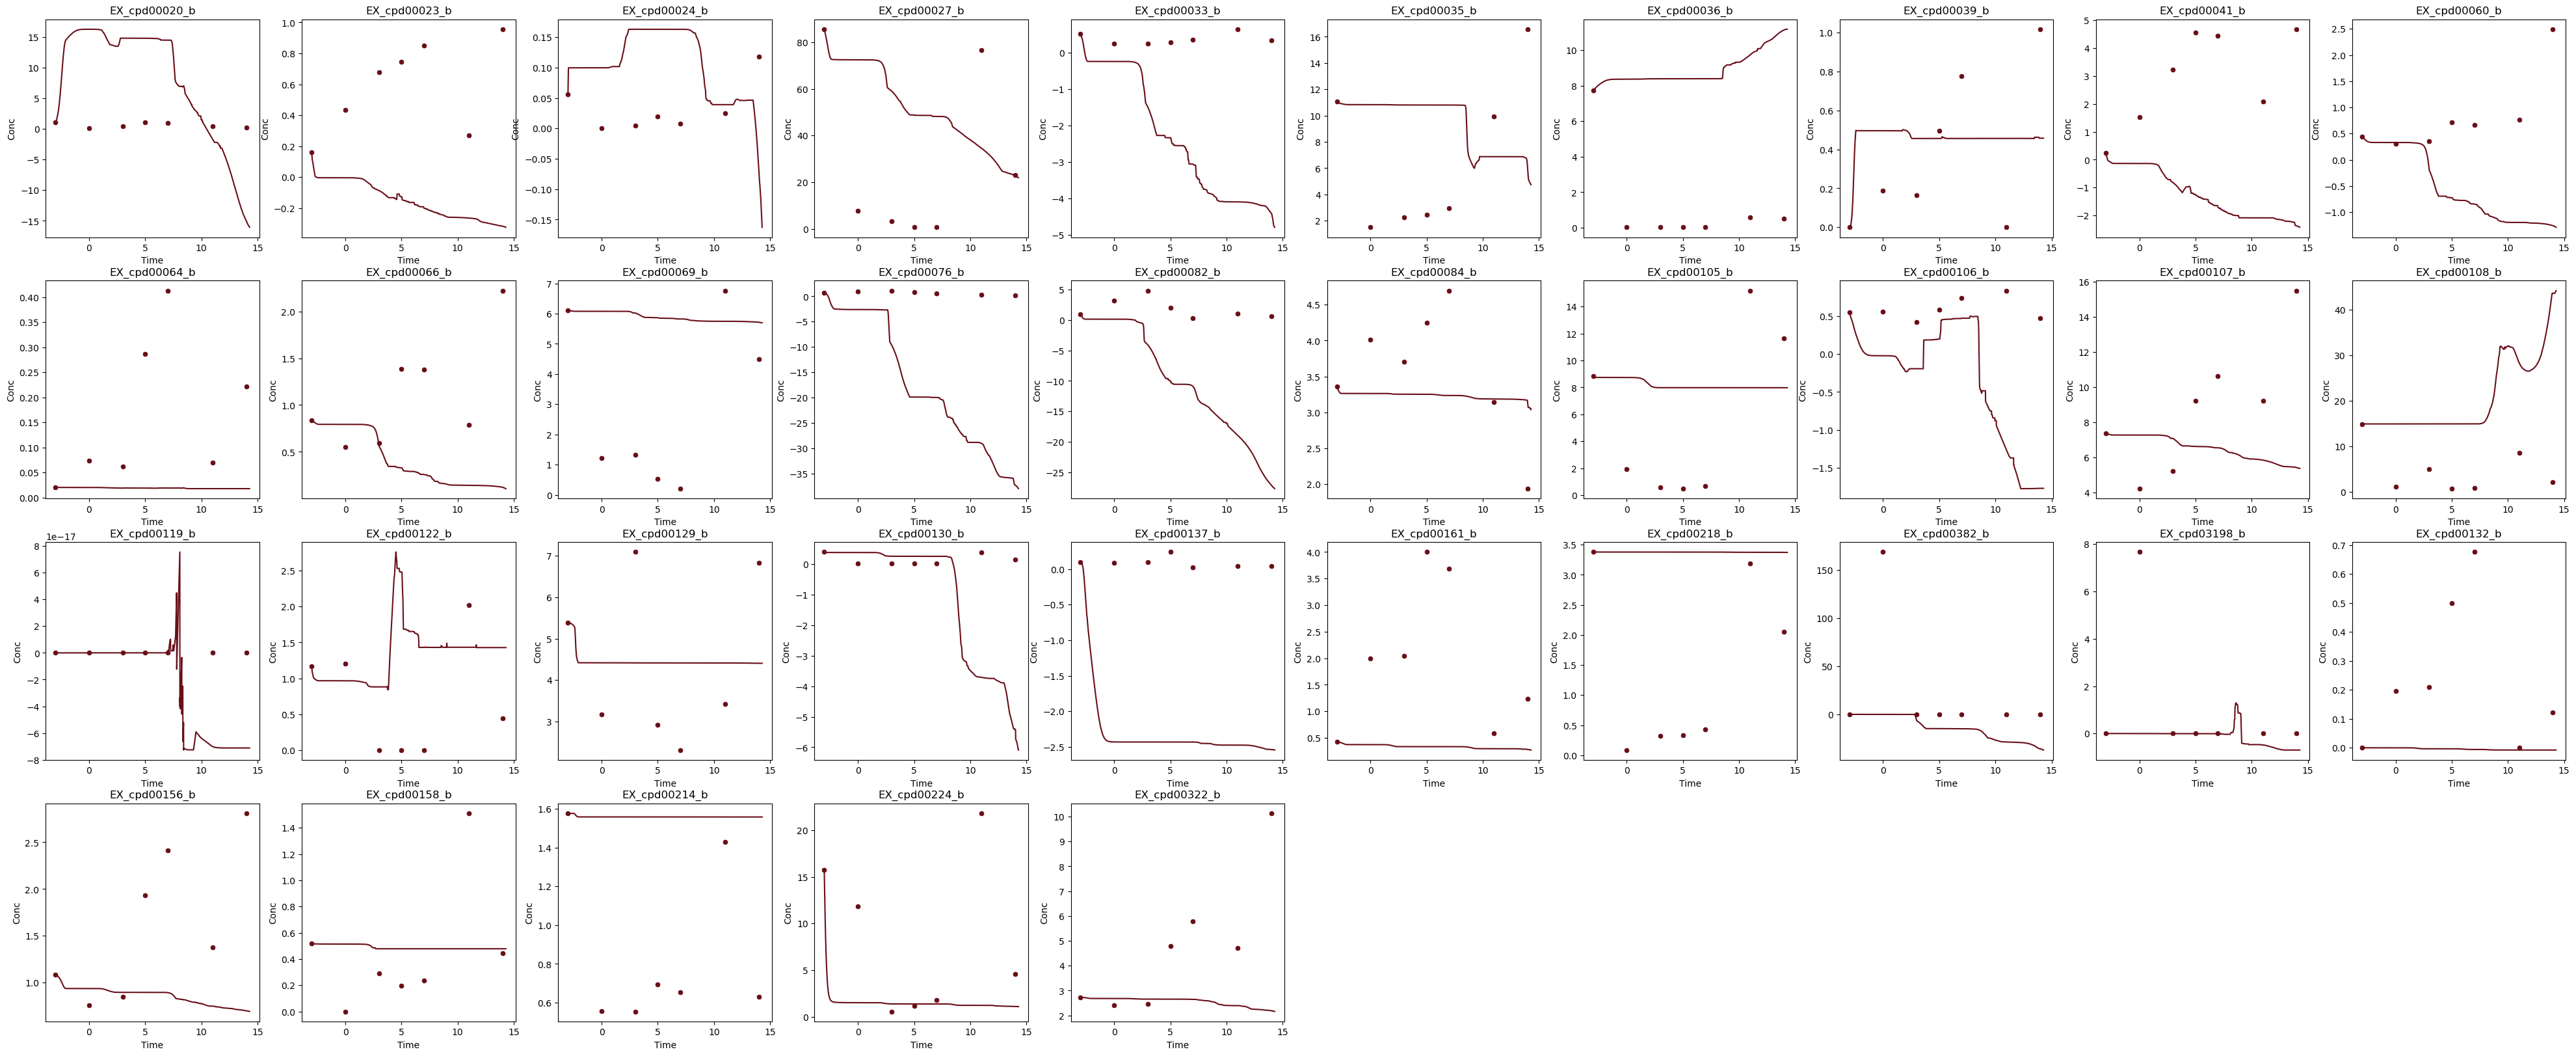

In [159]:
num_plots = merged_bac_met_use_df.shape[0]
cols = 10  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i,met in enumerate(merged_bac_met_use_df.index.tolist()):
    temp_sim = merged_bac_met_use_df.loc[met,:]
    temp_exp = metabolomics_data_sub_1948.loc[met,:]
        # Scatter plot on the respective subplot
    sns.lineplot(ax=axes[i], 
                    x=temp_sim.index.to_list(), y=temp_sim.to_list())
    sns.scatterplot(ax=axes[i], 
                    x=temp_exp.index.to_list(), y=temp_exp.to_list())

    axes[i].set_title(f"{met}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Conc')
    #axes[i].set_yscale('log')
    #axes[i].legend_.remove()

# Hide any empty subplots if the number of plots is not a perfect square
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])


plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_exp_vs_sim_individual_scatterplots_' + str(test_num) + '.pdf'
#plt.savefig(plot_file_name, bbox_inches="tight")